# Basic CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

landsat_dataset = rasterio.open('/deep_data/LC08_CU_028012_20140814_20171017_C01_V01_SR/combined.tif')


In [3]:
# What is the raster's projection?
image_proj = landsat_dataset.crs # 4326
print('Image projection:')
print(image_proj)

# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Labels projection:
EPSG:32618


## Data Generator and Prep Fcns

This is a typical Keras generator that I've written to allow it to ingest a set of random pixel locations so we can randomly sample throughout the images.

In [4]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                middle_pixel_r = r + np.ceil(tile_width/2)
                middle_pixel_c = c + np.ceil(tile_height/2)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(middle_pixel_r, middle_pixel_c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)
              

This function takes in a list of raster datasets and randomly samples `train_count` and `val_count` random pixels from each dataset.

It doesn't sample within tile_size / 2 of the edge in order to avoid missing data.

In [5]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a randomly selected number of pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    total_count = train_count + val_count
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count)
        
        dataset_index = [index] * total_count
        
        dataset_pixels = list(zip(points, dataset_index))
        
        train_pixels += dataset_pixels[:train_count]
        val_pixels += dataset_pixels[train_count:]
        
        
    return (train_pixels, val_pixels)

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [6]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations([landsat_dataset], 100, 20, 11)

In [7]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, 2):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----


### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

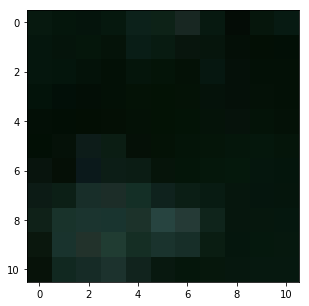

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

## Let's get to the CNN Development!!

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [10]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [11]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
img_rows, img_cols = 11, 11
img_bands = landsat_dataset.count

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(11, 11, 7)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [12]:
model = Sequential()
model.add(Conv2D(11, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(44, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 11)          704       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 22)          2200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 22)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 22)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 198)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                8756      
_________________________________________________________________
dropout_2 (Dropout)          (None, 44)                0         
__________

#### Generate the train/validation pixel locations to train with

In [13]:
train_px, val_px = gen_pixel_locations(image_datasets=[landsat_dataset], 
                                       train_count=10000, val_count=50, tile_size=11)

#### set up the remaining model hyperparameters and compile

In [14]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [15]:
model.fit_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator([landsat_dataset], label_dataset, 11, 11, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
400/400 [==============================] - 20s 50ms/step - loss: 2.0852 - acc: 0.3285 - val_loss: 2.1293 - val_acc: 0.3400
Epoch 2/50
400/400 [==============================] - 12s 30ms/step - loss: 1.9307 - acc: 0.3599 - val_loss: 2.0578 - val_acc: 0.3400
Epoch 3/50
400/400 [==============================] - 11s 28ms/step - loss: 1.8974 - acc: 0.3707 - val_loss: 2.0671 - val_acc: 0.3000
Epoch 4/50
400/400 [==============================] - 11s 29ms/step - loss: 1.8748 - acc: 0.3741 - val_loss: 2.1160 - val_acc: 0.3400
Epoch 5/50
400/400 [==============================] - 12s 29ms/step - loss: 1.8525 - acc: 0.3874 - val_loss: 2.1463 - val_acc: 0.3400
Epoch 6/50
400/400 [==============================] - 12s 29ms/step - loss: 1.8433 - acc: 0.3813 - val_loss: 2.0759 - val_acc: 0.3600
Epoch 7/50
400/400 [==============================] - 12s 29ms/step - loss: 1.8333 - acc: 0.3932 - val_loss: 2.1017 - val_acc: 0.2400
Epoch 8/50
400/400 [==============================] - 11s 28ms

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

In [16]:
test_px, val_px = gen_pixel_locations([landsat_dataset], train_count=500, val_count=0, tile_size=11)

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [17]:
model.evaluate_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

20/20 [==============================] - 8s 376ms/step


[1.7532305300235749, 0.415999998152256]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

In [18]:
predictions = model.predict_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)


20/20 [==============================] - 8s 376ms/step


In [19]:
eval_generator = tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size=1)

In [20]:
labels = np.empty(predictions.shape)
count = 0
while count < len(test_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

In [21]:
labels.shape

(500, 23)

In [22]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [23]:
label_index[:10]

array([21, 10,  6, 15, 21, 12,  6, 10,  4,  4])

In [24]:
pred_index[:10]

array([21, 13, 10, 13, 21,  6,  6, 13,  4, 10])

In [25]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [26]:
correct_predictions[:20]

array([1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0.])

In [27]:
np.count_nonzero(correct_predictions) / len(test_px)

0.416

In [28]:
predictions[:3]

array([[9.70876624e-09, 1.72885120e-08, 1.10155788e-07, 2.93066605e-05,
        8.15481087e-07, 5.30327915e-09, 8.66736804e-12, 2.22762537e-08,
        3.09864299e-05, 4.31555037e-07, 9.92404413e-04, 5.38855638e-05,
        1.45279569e-06, 9.39271047e-07, 1.01657104e-04, 5.18397545e-04,
        8.45230730e-09, 8.67214389e-09, 9.49429497e-02, 7.45580019e-03,
        1.30490836e-04, 8.95740211e-01, 8.44357295e-09],
       [8.25590978e-05, 9.36226716e-05, 2.25400203e-04, 1.89735423e-04,
        9.84964520e-03, 4.36705258e-03, 1.39946312e-01, 2.46487965e-04,
        5.74454889e-02, 4.31355601e-03, 2.14295045e-01, 3.55376713e-02,
        1.48536593e-01, 2.29772106e-01, 1.22776605e-01, 2.78273113e-02,
        1.09486580e-04, 2.50640820e-04, 1.10602111e-03, 6.91513778e-05,
        1.93347479e-03, 9.49315203e-04, 7.67342790e-05],
       [4.62722601e-05, 6.89396766e-05, 4.73296765e-04, 9.65687912e-04,
        5.10044098e-02, 2.46157087e-02, 1.92974284e-02, 2.55282357e-04,
        8.10894296e-02

In [29]:
np.argmax(predictions, axis=1)[:20]

array([21, 13, 10, 13, 21,  6,  6, 13,  4, 10,  6,  6,  6, 21, 21, 21,  6,
       21, 21, 13])

In [30]:
labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
conf_matrix = confusion_matrix(label_index, pred_index)

In [33]:
conf_matrix

array([[ 0,  3,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0,  7,  0,  9,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  7,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0, 15,  0,  3,  8,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  8,  0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0, 16,  0,  0, 41,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  2,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  7,  0,  6, 27,  2,  0,  0,  0,  0,  0],
       [ 0,  3,  0, 12,  0,  0, 12,  0,  0, 63,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  8,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,

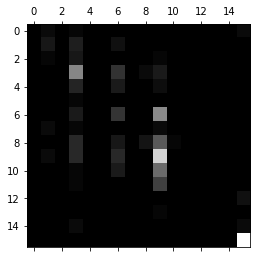

In [34]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)

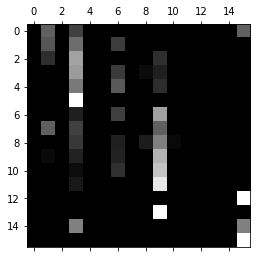

In [35]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

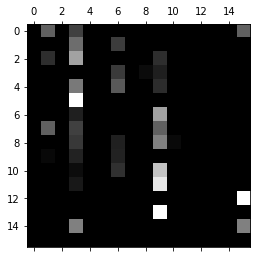

In [36]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

In [63]:
Xtrain = []
ytrain = []
count = 0
for x in tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, 1):
    if count > 50:
        break
    else:
        Xtrain.append(np.ravel(x[0]))
        ytrain.append(np.ravel(np.argwhere(np.ravel(x[1]))))
        count += 1

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)

In [62]:
np.ravel(np.argwhere(y_train[0]))

array([21])

In [79]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [80]:
neigh.score(X_test, y_test)

0.11764705882352941

In [104]:
train_size = np.linspace(100,1000,901)
best_score = 0
best_params = []

In [109]:
import sys
!{sys.executable} -m pip install tqdm
from tqdm import trange

    100% |################################| 51kB 2.5MB/s ta 0:00:011
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
for x in trange(len(train_size)):
    tz = train_size[x]
    print("Train size: {}".format(tz))
    Xtrain = []
    ytrain = []
    count = 0
    for x in tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, 1):
        if count > tz:
            break
        else:
            Xtrain.append(np.ravel(x[0]))
            ytrain.append(np.ravel(np.argwhere(np.ravel(x[1]))))
            count += 1
    X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.33, random_state=42)
    for neighbors in np.linspace(1,30,30):
        print("\tNeighbors: {}".format(neighbors))
        neigh = KNeighborsClassifier(n_neighbors=int(neighbors))
        neigh.fit(X_train, y_train)
        score = neigh.score(X_test, y_test)
        print("\t\t{}".format(score))
        if score > best_score:
            best_score = score
            best_params = [tz, neighbors, score]
print(best_params)



  0%|          | 0/901 [00:00<?, ?it/s]

Train size: 100.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.35294117647058826
	Neighbors: 2.0
		0.3235294117647059
	Neighbors: 3.0
		0.4411764705882353
	Neighbors: 4.0
		0.35294117647058826
	Neighbors: 5.0
		0.38235294117647056
	Neighbors: 6.0
		0.4117647058823529
	Neighbors: 7.0
		0.38235294117647056
	Neighbors: 8.0
		0.38235294117647056
	Neighbors: 9.0
		0.35294117647058826
	Neighbors: 10.0
		0.35294117647058826
	Neighbors: 11.0
		0.38235294117647056
	Neighbors: 12.0
		0.38235294117647056
	Neighbors: 13.0
		0.35294117647058826
	Neighbors: 14.0
		0.38235294117647056
	Neighbors: 15.0
		0.3235294117647059
	Neighbors: 16.0
		0.35294117647058826
	Neighbors: 17.0
		0.35294117647058826
	Neighbors: 18.0
		0.35294117647058826
	Neighbors: 19.0
		0.38235294117647056
	Neighbors: 20.0
		0.4117647058823529
	Neighbors: 21.0
		0.4117647058823529
	Neighbors: 22.0
		0.4411764705882353
	Neighbors: 23.0
		0.38235294117647056
	Neighbors: 24.0
		0.4117647058823529
	Neighbors: 25.0
		0.38235294117647056
	Neighbors: 26.0
		0.4117647058823529
	Nei

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.35294117647058826
	Neighbors: 2.0
		0.29411764705882354
	Neighbors: 3.0
		0.29411764705882354
	Neighbors: 4.0
		0.3235294117647059
	Neighbors: 5.0
		0.29411764705882354
	Neighbors: 6.0
		0.29411764705882354
	Neighbors: 7.0
		0.29411764705882354
	Neighbors: 8.0
		0.2647058823529412
	Neighbors: 9.0
		0.29411764705882354
	Neighbors: 10.0
		0.20588235294117646
	Neighbors: 11.0
		0.2647058823529412
	Neighbors: 12.0
		0.3235294117647059
	Neighbors: 13.0
		0.3235294117647059
	Neighbors: 14.0
		0.2647058823529412
	Neighbors: 15.0
		0.29411764705882354
	Neighbors: 16.0
		0.29411764705882354
	Neighbors: 17.0
		0.29411764705882354
	Neighbors: 18.0
		0.29411764705882354
	Neighbors: 19.0
		0.29411764705882354
	Neighbors: 20.0
		0.3235294117647059
	Neighbors: 21.0
		0.29411764705882354
	Neighbors: 22.0
		0.35294117647058826
	Neighbors: 23.0
		0.38235294117647056
	Neighbors: 24.0
		0.38235294117647056
	Neighbors: 25.0
		0.38235294117647056
	Neighbors: 26.0
		0.38235294117647056
	N

Train size: 102.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.3235294117647059
	Neighbors: 2.0
		0.29411764705882354
	Neighbors: 3.0
		0.29411764705882354
	Neighbors: 4.0
		0.3235294117647059
	Neighbors: 5.0
		0.2647058823529412
	Neighbors: 6.0
		0.3235294117647059
	Neighbors: 7.0
		0.3235294117647059
	Neighbors: 8.0
		0.2647058823529412
	Neighbors: 9.0
		0.2647058823529412
	Neighbors: 10.0
		0.29411764705882354
	Neighbors: 11.0
		0.20588235294117646
	Neighbors: 12.0
		0.29411764705882354
	Neighbors: 13.0
		0.3235294117647059
	Neighbors: 14.0
		0.3235294117647059
	Neighbors: 15.0
		0.2647058823529412
	Neighbors: 16.0
		0.29411764705882354
	Neighbors: 17.0
		0.29411764705882354
	Neighbors: 18.0
		0.29411764705882354
	Neighbors: 19.0
		0.29411764705882354
	Neighbors: 20.0
		0.29411764705882354
	Neighbors: 21.0
		0.3235294117647059
	Neighbors: 22.0
		0.29411764705882354
	Neighbors: 23.0
		0.35294117647058826
	Neighbors: 24.0
		0.38235294117647056
	Neighbors: 25.0
		0.38235294117647056
	Neighbors: 26.0
		0.38235294117647056
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.34285714285714286
	Neighbors: 2.0
		0.34285714285714286
	Neighbors: 3.0
		0.3142857142857143
	Neighbors: 4.0
		0.37142857142857144
	Neighbors: 5.0
		0.34285714285714286
	Neighbors: 6.0
		0.37142857142857144
	Neighbors: 7.0
		0.37142857142857144
	Neighbors: 8.0
		0.3142857142857143
	Neighbors: 9.0
		0.2857142857142857
	Neighbors: 10.0
		0.2857142857142857
	Neighbors: 11.0
		0.3142857142857143
	Neighbors: 12.0
		0.3142857142857143
	Neighbors: 13.0
		0.34285714285714286
	Neighbors: 14.0
		0.2857142857142857
	Neighbors: 15.0
		0.3142857142857143
	Neighbors: 16.0
		0.37142857142857144
	Neighbors: 17.0
		0.37142857142857144
	Neighbors: 18.0
		0.34285714285714286
	Neighbors: 19.0
		0.34285714285714286
	Neighbors: 20.0
		0.34285714285714286
	Neighbors: 21.0
		0.3142857142857143
	Neighbors: 22.0
		0.3142857142857143
	Neighbors: 23.0
		0.3142857142857143
	Neighbors: 24.0
		0.34285714285714286
	Neighbors: 25.0
		0.3142857142857143
	Neighbors: 26.0
		0.34285714285714286
	Neighb

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.3142857142857143
	Neighbors: 2.0
		0.4
	Neighbors: 3.0
		0.37142857142857144
	Neighbors: 4.0
		0.4
	Neighbors: 5.0
		0.4
	Neighbors: 6.0
		0.42857142857142855
	Neighbors: 7.0
		0.4
	Neighbors: 8.0
		0.3142857142857143
	Neighbors: 9.0
		0.3142857142857143
	Neighbors: 10.0
		0.34285714285714286
	Neighbors: 11.0
		0.3142857142857143
	Neighbors: 12.0
		0.4
	Neighbors: 13.0
		0.4
	Neighbors: 14.0
		0.37142857142857144
	Neighbors: 15.0
		0.4
	Neighbors: 16.0
		0.37142857142857144
	Neighbors: 17.0
		0.37142857142857144
	Neighbors: 18.0
		0.4
	Neighbors: 19.0
		0.3142857142857143
	Neighbors: 20.0
		0.3142857142857143
	Neighbors: 21.0
		0.3142857142857143
	Neighbors: 22.0
		0.34285714285714286
	Neighbors: 23.0
		0.4
	Neighbors: 24.0
		0.4
	Neighbors: 25.0
		0.37142857142857144
	Neighbors: 26.0
		0.37142857142857144
	Neighbors: 27.0
		0.37142857142857144
	Neighbors: 28.0
		0.4
	Neighbors: 29.0
		0.34285714285714286
	Neighbors: 30.0
		0.3142857142857143


Train size: 105.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 1.0
		0.37142857142857144
	Neighbors: 2.0
		0.3142857142857143
	Neighbors: 3.0
		0.2571428571428571
	Neighbors: 4.0
		0.34285714285714286
	Neighbors: 5.0
		0.2571428571428571
	Neighbors: 6.0
		0.2571428571428571
	Neighbors: 7.0
		0.2857142857142857
	Neighbors: 8.0
		0.2571428571428571
	Neighbors: 9.0
		0.2571428571428571
	Neighbors: 10.0
		0.2857142857142857
	Neighbors: 11.0
		0.2857142857142857
	Neighbors: 12.0
		0.2857142857142857
	Neighbors: 13.0
		0.2857142857142857
	Neighbors: 14.0
		0.2571428571428571
	Neighbors: 15.0
		0.2571428571428571
	Neighbors: 16.0
		0.2857142857142857
	Neighbors: 17.0
		0.2857142857142857
	Neighbors: 18.0
		0.2571428571428571
	Neighbors: 19.0
		0.2857142857142857
	Neighbors: 20.0
		0.2857142857142857
	Neighbors: 21.0
		0.3142857142857143
	Neighbors: 22.0
		0.2857142857142857
	Neighbors: 23.0
		0.4
	Neighbors: 24.0
		0.42857142857142855
	Neighbors: 25.0
		0.4
	Neighbors: 26.0
		0.4
	Neighbors: 27.0
		0.4
	Neighbors: 28.0
		0.37142857142857144
	

  1%|          | 6/901 [00:43<1:47:22,  7.20s/it]

Train size: 106.0
	Neighbors: 1.0
		0.3333333333333333
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.3333333333333333
	Neighbors: 4.0
		0.3611111111111111
	Neighbors: 5.0
		0.3611111111111111
	Neighbors: 6.0
		0.3055555555555556
	Neighbors: 7.0
		0.3055555555555556
	Neighbors: 8.0
		0.3055555555555556
	Neighbors: 9.0
		0.2777777777777778
	Neighbors: 10.0
		0.2777777777777778
	Neighbors: 11.0
		0.3055555555555556
	Neighbors: 12.0
		0.2777777777777778
	Neighbors: 13.0
		0.3055555555555556
	Neighbors: 14.0
		0.2777777777777778
	Neighbors: 15.0
		0.2777777777777778
	Neighbors: 16.0
		0.2777777777777778
	Neighbors: 17.0
		0.2777777777777778
	Neighbors: 18.0
		0.2777777777777778
	Neighbors: 19.0
		0.2777777777777778
	Neighbors: 20.0
		0.3055555555555556
	Neighbors: 21.0
		0.3611111111111111
	Neighbors: 22.0
		0.3611111111111111
	Neighbors: 23.0
		0.3611111111111111
	Neighbors: 24.0
		0.3333333333333333
	Neighbors: 25.0
		0.2777777777777778
	Neighbors: 26.0
		0.3055555555555556
	Ne

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3055555555555556
	Neighbors: 30.0
		0.25
Train size: 107.0
	Neighbors: 1.0
		0.4166666666666667
	Neighbors: 2.0
		0.3611111111111111
	Neighbors: 3.0
		0.3055555555555556
	Neighbors: 4.0
		0.3055555555555556
	Neighbors: 5.0
		0.3055555555555556
	Neighbors: 6.0
		0.2777777777777778
	Neighbors: 7.0
		0.2777777777777778
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3055555555555556
	Neighbors: 10.0
		0.3055555555555556
	Neighbors: 11.0
		0.3055555555555556
	Neighbors: 12.0
		0.2777777777777778
	Neighbors: 13.0
		0.25
	Neighbors: 14.0
		0.25
	Neighbors: 15.0
		0.19444444444444445
	Neighbors: 16.0
		0.1388888888888889
	Neighbors: 17.0
		0.1388888888888889
	Neighbors: 18.0
		0.16666666666666666
	Neighbors: 19.0
		0.1111111111111111
	Neighbors: 20.0
		0.08333333333333333
	Neighbors: 21.0
		0.08333333333333333
	Neighbors: 22.0
		0.08333333333333333
	Neighbors: 23.0
		0.08333333333333333
	Neighbors: 24.0
		0.05555555555555555
	Neighbors: 25.0
		0.08333333333333333
	Neighbors: 26.0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.05555555555555555
Train size: 108.0
	Neighbors: 1.0
		0.4166666666666667
	Neighbors: 2.0
		0.4166666666666667
	Neighbors: 3.0
		0.3611111111111111
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.3611111111111111
	Neighbors: 6.0
		0.3333333333333333
	Neighbors: 7.0
		0.3611111111111111
	Neighbors: 8.0
		0.3611111111111111
	Neighbors: 9.0
		0.2777777777777778
	Neighbors: 10.0
		0.3055555555555556
	Neighbors: 11.0
		0.3055555555555556
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3611111111111111
	Neighbors: 15.0
		0.3333333333333333
	Neighbors: 16.0
		0.3333333333333333
	Neighbors: 17.0
		0.3055555555555556
	Neighbors: 18.0
		0.2777777777777778
	Neighbors: 19.0
		0.2777777777777778
	Neighbors: 20.0
		0.25
	Neighbors: 21.0
		0.2777777777777778
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.19444444444444445
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.25
	Neighbors: 26.0
		0.3055555555555556
	Neighbors: 27.0
		0.222222222222222

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2222222222222222
	Neighbors: 30.0
		0.19444444444444445
Train size: 109.0
	Neighbors: 1.0
		0.40540540540540543
	Neighbors: 2.0
		0.43243243243243246
	Neighbors: 3.0
		0.3783783783783784
	Neighbors: 4.0
		0.32432432432432434
	Neighbors: 5.0
		0.40540540540540543
	Neighbors: 6.0
		0.40540540540540543
	Neighbors: 7.0
		0.3783783783783784
	Neighbors: 8.0
		0.3783783783783784
	Neighbors: 9.0
		0.32432432432432434
	Neighbors: 10.0
		0.3783783783783784
	Neighbors: 11.0
		0.3783783783783784
	Neighbors: 12.0
		0.32432432432432434
	Neighbors: 13.0
		0.32432432432432434
	Neighbors: 14.0
		0.35135135135135137
	Neighbors: 15.0
		0.32432432432432434
	Neighbors: 16.0
		0.3783783783783784
	Neighbors: 17.0
		0.32432432432432434
	Neighbors: 18.0
		0.2702702702702703
	Neighbors: 19.0
		0.35135135135135137
	Neighbors: 20.0
		0.21621621621621623
	Neighbors: 21.0
		0.2702702702702703
	Neighbors: 22.0
		0.2702702702702703
	Neighbors: 23.0
		0.24324324324324326
	Neighbors: 24.0
		0.1891891891891892
	Neig

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2702702702702703
	Neighbors: 28.0
		0.24324324324324326
	Neighbors: 29.0
		0.1891891891891892
	Neighbors: 30.0
		0.21621621621621623
Train size: 110.0
	Neighbors: 1.0
		0.40540540540540543
	Neighbors: 2.0
		0.40540540540540543
	Neighbors: 3.0
		0.35135135135135137
	Neighbors: 4.0
		0.35135135135135137
	Neighbors: 5.0
		0.40540540540540543
	Neighbors: 6.0
		0.3783783783783784
	Neighbors: 7.0
		0.35135135135135137
	Neighbors: 8.0
		0.35135135135135137
	Neighbors: 9.0
		0.2972972972972973
	Neighbors: 10.0
		0.2972972972972973
	Neighbors: 11.0
		0.2972972972972973
	Neighbors: 12.0
		0.32432432432432434
	Neighbors: 13.0
		0.32432432432432434
	Neighbors: 14.0
		0.35135135135135137
	Neighbors: 15.0
		0.32432432432432434
	Neighbors: 16.0
		0.32432432432432434
	Neighbors: 17.0
		0.2972972972972973
	Neighbors: 18.0
		0.2702702702702703
	Neighbors: 19.0
		0.2702702702702703
	Neighbors: 20.0
		0.24324324324324326
	Neighbors: 21.0
		0.2972972972972973
	Neighbors: 22.0
		0.1891891891891892
	Neig

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2702702702702703
	Neighbors: 30.0
		0.2702702702702703
Train size: 111.0
	Neighbors: 1.0
		0.35135135135135137
	Neighbors: 2.0
		0.35135135135135137
	Neighbors: 3.0
		0.2972972972972973
	Neighbors: 4.0
		0.2972972972972973
	Neighbors: 5.0
		0.32432432432432434
	Neighbors: 6.0
		0.40540540540540543
	Neighbors: 7.0
		0.3783783783783784
	Neighbors: 8.0
		0.32432432432432434
	Neighbors: 9.0
		0.35135135135135137
	Neighbors: 10.0
		0.32432432432432434
	Neighbors: 11.0
		0.32432432432432434
	Neighbors: 12.0
		0.35135135135135137
	Neighbors: 13.0
		0.35135135135135137
	Neighbors: 14.0
		0.35135135135135137
	Neighbors: 15.0
		0.40540540540540543
	Neighbors: 16.0
		0.3783783783783784
	Neighbors: 17.0
		0.35135135135135137
	Neighbors: 18.0
		0.32432432432432434
	Neighbors: 19.0
		0.24324324324324326
	Neighbors: 20.0
		0.24324324324324326
	Neighbors: 21.0
		0.24324324324324326
	Neighbors: 22.0
		0.21621621621621623
	Neighbors: 23.0
		0.21621621621621623
	Neighbors: 24.0
		0.1891891891891892
	

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.21621621621621623
	Neighbors: 30.0
		0.16216216216216217
Train size: 112.0
	Neighbors: 1.0
		0.3157894736842105
	Neighbors: 2.0
		0.34210526315789475
	Neighbors: 3.0
		0.2631578947368421
	Neighbors: 4.0
		0.2894736842105263
	Neighbors: 5.0
		0.3157894736842105
	Neighbors: 6.0
		0.34210526315789475
	Neighbors: 7.0
		0.3157894736842105
	Neighbors: 8.0
		0.3157894736842105
	Neighbors: 9.0
		0.2631578947368421
	Neighbors: 10.0
		0.23684210526315788
	Neighbors: 11.0
		0.2894736842105263
	Neighbors: 12.0
		0.23684210526315788
	Neighbors: 13.0
		0.23684210526315788
	Neighbors: 14.0
		0.2631578947368421
	Neighbors: 15.0
		0.2894736842105263
	Neighbors: 16.0
		0.23684210526315788
	Neighbors: 17.0
		0.23684210526315788
	Neighbors: 18.0
		0.2631578947368421
	Neighbors: 19.0
		0.23684210526315788
	Neighbors: 20.0
		0.23684210526315788
	Neighbors: 21.0
		0.2631578947368421
	Neighbors: 22.0
		0.23684210526315788
	Neighbors: 23.0
		0.23684210526315788
	Neighbors: 24.0
		0.23684210526315788
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.13157894736842105
	Neighbors: 29.0
		0.13157894736842105
	Neighbors: 30.0
		0.13157894736842105
Train size: 113.0
	Neighbors: 1.0
		0.34210526315789475
	Neighbors: 2.0
		0.3684210526315789
	Neighbors: 3.0
		0.2894736842105263
	Neighbors: 4.0
		0.3157894736842105
	Neighbors: 5.0
		0.3157894736842105
	Neighbors: 6.0
		0.3684210526315789
	Neighbors: 7.0
		0.3157894736842105
	Neighbors: 8.0
		0.3157894736842105
	Neighbors: 9.0
		0.2894736842105263
	Neighbors: 10.0
		0.2631578947368421
	Neighbors: 11.0
		0.2894736842105263
	Neighbors: 12.0
		0.21052631578947367
	Neighbors: 13.0
		0.21052631578947367
	Neighbors: 14.0
		0.23684210526315788
	Neighbors: 15.0
		0.2631578947368421
	Neighbors: 16.0
		0.2894736842105263
	Neighbors: 17.0
		0.2894736842105263
	Neighbors: 18.0
		0.3157894736842105
	Neighbors: 19.0
		0.2894736842105263
	Neighbors: 20.0
		0.2631578947368421
	Neighbors: 21.0
		0.2894736842105263
	Neighbors: 22.0
		0.2894736842105263
	Neighbors: 23.0
		0.2894736842105263
	Neighbors: 2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.13157894736842105
	Neighbors: 29.0
		0.13157894736842105
	Neighbors: 30.0
		0.13157894736842105
Train size: 114.0
	Neighbors: 1.0
		0.3157894736842105
	Neighbors: 2.0
		0.3684210526315789
	Neighbors: 3.0
		0.34210526315789475
	Neighbors: 4.0
		0.3684210526315789
	Neighbors: 5.0
		0.3157894736842105
	Neighbors: 6.0
		0.34210526315789475
	Neighbors: 7.0
		0.34210526315789475
	Neighbors: 8.0
		0.2894736842105263
	Neighbors: 9.0
		0.2631578947368421
	Neighbors: 10.0
		0.2894736842105263
	Neighbors: 11.0
		0.3684210526315789
	Neighbors: 12.0
		0.3684210526315789
	Neighbors: 13.0
		0.2631578947368421
	Neighbors: 14.0
		0.2894736842105263
	Neighbors: 15.0
		0.3157894736842105
	Neighbors: 16.0
		0.23684210526315788
	Neighbors: 17.0
		0.2894736842105263
	Neighbors: 18.0
		0.34210526315789475
	Neighbors: 19.0
		0.3684210526315789
	Neighbors: 20.0
		0.2631578947368421
	Neighbors: 21.0
		0.2894736842105263
	Neighbors: 22.0
		0.2631578947368421
	Neighbors: 23.0
		0.2894736842105263
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.21052631578947367
	Neighbors: 29.0
		0.15789473684210525
	Neighbors: 30.0
		0.13157894736842105
Train size: 115.0
	Neighbors: 1.0
		0.23076923076923078
	Neighbors: 2.0
		0.28205128205128205
	Neighbors: 3.0
		0.23076923076923078
	Neighbors: 4.0
		0.28205128205128205
	Neighbors: 5.0
		0.23076923076923078
	Neighbors: 6.0
		0.28205128205128205
	Neighbors: 7.0
		0.2564102564102564
	Neighbors: 8.0
		0.23076923076923078
	Neighbors: 9.0
		0.23076923076923078
	Neighbors: 10.0
		0.20512820512820512
	Neighbors: 11.0
		0.23076923076923078
	Neighbors: 12.0
		0.28205128205128205
	Neighbors: 13.0
		0.2564102564102564
	Neighbors: 14.0
		0.2564102564102564
	Neighbors: 15.0
		0.23076923076923078
	Neighbors: 16.0
		0.2564102564102564
	Neighbors: 17.0
		0.20512820512820512
	Neighbors: 18.0
		0.10256410256410256
	Neighbors: 19.0
		0.07692307692307693
	Neighbors: 20.0
		0.1282051282051282
	Neighbors: 21.0
		0.1282051282051282
	Neighbors: 22.0
		0.1282051282051282
	Neighbors: 23.0
		0.10256410256410256
	

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.10256410256410256
	Neighbors: 28.0
		0.1282051282051282
	Neighbors: 29.0
		0.10256410256410256
	Neighbors: 30.0
		0.1282051282051282
Train size: 116.0
	Neighbors: 1.0
		0.3333333333333333
	Neighbors: 2.0
		0.38461538461538464
	Neighbors: 3.0
		0.3076923076923077
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.358974358974359
	Neighbors: 6.0
		0.2564102564102564
	Neighbors: 7.0
		0.3076923076923077
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3333333333333333
	Neighbors: 10.0
		0.3076923076923077
	Neighbors: 11.0
		0.3076923076923077
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.2564102564102564
	Neighbors: 14.0
		0.2564102564102564
	Neighbors: 15.0
		0.1794871794871795
	Neighbors: 16.0
		0.1794871794871795
	Neighbors: 17.0
		0.1794871794871795
	Neighbors: 18.0
		0.20512820512820512
	Neighbors: 19.0
		0.23076923076923078
	Neighbors: 20.0
		0.20512820512820512
	Neighbors: 21.0
		0.20512820512820512
	Neighbors: 22.0
		0.1794871794871795
	Neighbors: 23

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.10256410256410256
	Neighbors: 29.0
		0.07692307692307693
	Neighbors: 30.0
		0.07692307692307693
Train size: 117.0
	Neighbors: 1.0
		0.28205128205128205
	Neighbors: 2.0
		0.2564102564102564
	Neighbors: 3.0
		0.20512820512820512
	Neighbors: 4.0
		0.23076923076923078
	Neighbors: 5.0
		0.23076923076923078
	Neighbors: 6.0
		0.23076923076923078
	Neighbors: 7.0
		0.28205128205128205
	Neighbors: 8.0
		0.28205128205128205
	Neighbors: 9.0
		0.2564102564102564
	Neighbors: 10.0
		0.2564102564102564
	Neighbors: 11.0
		0.2564102564102564
	Neighbors: 12.0
		0.23076923076923078
	Neighbors: 13.0
		0.23076923076923078
	Neighbors: 14.0
		0.23076923076923078
	Neighbors: 15.0
		0.2564102564102564
	Neighbors: 16.0
		0.23076923076923078
	Neighbors: 17.0
		0.2564102564102564
	Neighbors: 18.0
		0.2564102564102564
	Neighbors: 19.0
		0.2564102564102564
	Neighbors: 20.0
		0.2564102564102564
	Neighbors: 21.0
		0.28205128205128205
	Neighbors: 22.0
		0.23076923076923078
	Neighbors: 23.0
		0.2564102564102564
	Nei

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.23076923076923078
	Neighbors: 28.0
		0.20512820512820512
	Neighbors: 29.0
		0.23076923076923078
	Neighbors: 30.0
		0.23076923076923078
Train size: 118.0
	Neighbors: 1.0
		0.275
	Neighbors: 2.0
		0.325
	Neighbors: 3.0
		0.275
	Neighbors: 4.0
		0.275
	Neighbors: 5.0
		0.275
	Neighbors: 6.0
		0.275
	Neighbors: 7.0
		0.3
	Neighbors: 8.0
		0.325
	Neighbors: 9.0
		0.3
	Neighbors: 10.0
		0.275
	Neighbors: 11.0
		0.25
	Neighbors: 12.0
		0.225
	Neighbors: 13.0
		0.225
	Neighbors: 14.0
		0.225
	Neighbors: 15.0
		0.225
	Neighbors: 16.0
		0.225
	Neighbors: 17.0
		0.25
	Neighbors: 18.0
		0.275
	Neighbors: 19.0
		0.275
	Neighbors: 20.0
		0.3
	Neighbors: 21.0
		0.275
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.25
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.2
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.225
	Neighbors: 27.0
		0.2
	Neighbors: 28.0
		0.2
	Neighbors: 29.0
		0.2
	Neighbors: 30.0
		0.2
Train size: 119.0
	Neighbors: 1.0
		0.275
	Neighbors: 2.0
		0.375
	Neighbors: 3.0
		0.325
	Neighbors: 4.0
		0.375
	Neighbors: 5.0
		0.35
	Neighbors: 6.0
		0.375
	Neighbors: 7.0
		0.325
	Neighbors: 8.0
		0.325
	Neighbors: 9.0
		0.35
	Neighbors: 10.0
		0.275
	Neighbors: 11.0
		0.25
	Neighbors: 12.0
		0.275
	Neighbors: 13.0
		0.275
	Neighbors: 14.0
		0.3
	Neighbors: 15.0
		0.3
	Neighbors: 16.0
		0.3
	Neighbors: 17.0
		0.3
	Neighbors: 18.0
		0.3
	Neighbors: 19.0
		0.325
	Neighbors: 20.0
		0.3
	Neighbors: 21.0
		0.325
	Neighbors: 22.0
		0.35
	Neighbors: 23.0
		0.325
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.25
	Neighbors: 26.0
		0.25
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3
	Neighbors: 28.0
		0.325
	Neighbors: 29.0
		0.25
	Neighbors: 30.0
		0.25
Train size: 120.0
	Neighbors: 1.0
		0.275
	Neighbors: 2.0
		0.4
	Neighbors: 3.0
		0.325
	Neighbors: 4.0
		0.275
	Neighbors: 5.0
		0.225
	Neighbors: 6.0
		0.275
	Neighbors: 7.0
		0.225
	Neighbors: 8.0
		0.2
	Neighbors: 9.0
		0.2
	Neighbors: 10.0
		0.175
	Neighbors: 11.0
		0.175
	Neighbors: 12.0
		0.175
	Neighbors: 13.0
		0.2
	Neighbors: 14.0
		0.225
	Neighbors: 15.0
		0.225
	Neighbors: 16.0
		0.225
	Neighbors: 17.0
		0.225
	Neighbors: 18.0
		0.225
	Neighbors: 19.0
		0.2
	Neighbors: 20.0
		0.25
	Neighbors: 21.0
		0.275
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.225
	Neighbors: 24.0
		0.225
	Neighbors: 25.0
		0.225
	Neighbors: 26.0
		0.225


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 27.0
		0.225
	Neighbors: 28.0
		0.2
	Neighbors: 29.0
		0.2
	Neighbors: 30.0
		0.175
Train size: 121.0
	Neighbors: 1.0
		0.2682926829268293
	Neighbors: 2.0
		0.3170731707317073
	Neighbors: 3.0
		0.24390243902439024
	Neighbors: 4.0
		0.2926829268292683
	Neighbors: 5.0
		0.24390243902439024
	Neighbors: 6.0
		0.24390243902439024
	Neighbors: 7.0
		0.2682926829268293
	Neighbors: 8.0
		0.1951219512195122
	Neighbors: 9.0
		0.24390243902439024
	Neighbors: 10.0
		0.2682926829268293
	Neighbors: 11.0
		0.2926829268292683
	Neighbors: 12.0
		0.2926829268292683
	Neighbors: 13.0
		0.2926829268292683
	Neighbors: 14.0
		0.2926829268292683
	Neighbors: 15.0
		0.2926829268292683
	Neighbors: 16.0
		0.3170731707317073
	Neighbors: 17.0
		0.2926829268292683
	Neighbors: 18.0
		0.3170731707317073
	Neighbors: 19.0
		0.2926829268292683
	Neighbors: 20.0
		0.2926829268292683
	Neighbors: 21.0
		0.3170731707317073
	Neighbors: 22.0
		0.34146341463414637
	Neighbors: 23.0
		0.3170731707317073
	Neighbors: 24.0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24390243902439024
	Neighbors: 27.0
		0.24390243902439024
	Neighbors: 28.0
		0.24390243902439024
	Neighbors: 29.0
		0.2682926829268293
	Neighbors: 30.0
		0.21951219512195122
Train size: 122.0
	Neighbors: 1.0
		0.3170731707317073
	Neighbors: 2.0
		0.34146341463414637
	Neighbors: 3.0
		0.3902439024390244
	Neighbors: 4.0
		0.36585365853658536
	Neighbors: 5.0
		0.3170731707317073
	Neighbors: 6.0
		0.34146341463414637
	Neighbors: 7.0
		0.3170731707317073
	Neighbors: 8.0
		0.34146341463414637
	Neighbors: 9.0
		0.3170731707317073
	Neighbors: 10.0
		0.3170731707317073
	Neighbors: 11.0
		0.36585365853658536
	Neighbors: 12.0
		0.3170731707317073
	Neighbors: 13.0
		0.34146341463414637
	Neighbors: 14.0
		0.34146341463414637
	Neighbors: 15.0
		0.34146341463414637
	Neighbors: 16.0
		0.2926829268292683
	Neighbors: 17.0
		0.34146341463414637
	Neighbors: 18.0
		0.34146341463414637
	Neighbors: 19.0
		0.2926829268292683
	Neighbors: 20.0
		0.36585365853658536
	Neighbors: 21.0
		0.36585365853658536
	Nei

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34146341463414637
	Neighbors: 27.0
		0.2926829268292683
	Neighbors: 28.0
		0.2682926829268293
	Neighbors: 29.0
		0.2682926829268293
	Neighbors: 30.0
		0.2926829268292683
Train size: 123.0
	Neighbors: 1.0
		0.34146341463414637
	Neighbors: 2.0
		0.2682926829268293
	Neighbors: 3.0
		0.3170731707317073
	Neighbors: 4.0
		0.2682926829268293
	Neighbors: 5.0
		0.2682926829268293
	Neighbors: 6.0
		0.36585365853658536
	Neighbors: 7.0
		0.24390243902439024
	Neighbors: 8.0
		0.2682926829268293
	Neighbors: 9.0
		0.2926829268292683
	Neighbors: 10.0
		0.2926829268292683
	Neighbors: 11.0
		0.21951219512195122
	Neighbors: 12.0
		0.17073170731707318
	Neighbors: 13.0
		0.1951219512195122
	Neighbors: 14.0
		0.21951219512195122
	Neighbors: 15.0
		0.2926829268292683
	Neighbors: 16.0
		0.24390243902439024
	Neighbors: 17.0
		0.21951219512195122
	Neighbors: 18.0
		0.21951219512195122
	Neighbors: 19.0
		0.24390243902439024
	Neighbors: 20.0
		0.21951219512195122
	Neighbors: 21.0
		0.2682926829268293
	Neighbo

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2682926829268293
	Neighbors: 27.0
		0.2926829268292683
	Neighbors: 28.0
		0.2926829268292683
	Neighbors: 29.0
		0.3170731707317073
	Neighbors: 30.0
		0.2926829268292683
Train size: 124.0
	Neighbors: 1.0
		0.3333333333333333
	Neighbors: 2.0
		0.35714285714285715
	Neighbors: 3.0
		0.35714285714285715
	Neighbors: 4.0
		0.30952380952380953
	Neighbors: 5.0
		0.2857142857142857
	Neighbors: 6.0
		0.3333333333333333
	Neighbors: 7.0
		0.21428571428571427
	Neighbors: 8.0
		0.2857142857142857
	Neighbors: 9.0
		0.2857142857142857
	Neighbors: 10.0
		0.23809523809523808
	Neighbors: 11.0
		0.23809523809523808
	Neighbors: 12.0
		0.23809523809523808
	Neighbors: 13.0
		0.2857142857142857
	Neighbors: 14.0
		0.3333333333333333
	Neighbors: 15.0
		0.2857142857142857
	Neighbors: 16.0
		0.2619047619047619
	Neighbors: 17.0
		0.2857142857142857
	Neighbors: 18.0
		0.2857142857142857
	Neighbors: 19.0
		0.21428571428571427
	Neighbors: 20.0
		0.2857142857142857
	Neighbors: 21.0
		0.2857142857142857
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2857142857142857
	Neighbors: 27.0
		0.2857142857142857
	Neighbors: 28.0
		0.3333333333333333
	Neighbors: 29.0
		0.3333333333333333
	Neighbors: 30.0
		0.2857142857142857
Train size: 125.0
	Neighbors: 1.0
		0.30952380952380953
	Neighbors: 2.0
		0.2619047619047619
	Neighbors: 3.0
		0.3333333333333333
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.35714285714285715
	Neighbors: 6.0
		0.2857142857142857
	Neighbors: 7.0
		0.23809523809523808
	Neighbors: 8.0
		0.2619047619047619
	Neighbors: 9.0
		0.2857142857142857
	Neighbors: 10.0
		0.23809523809523808
	Neighbors: 11.0
		0.21428571428571427
	Neighbors: 12.0
		0.23809523809523808
	Neighbors: 13.0
		0.23809523809523808
	Neighbors: 14.0
		0.21428571428571427
	Neighbors: 15.0
		0.23809523809523808
	Neighbors: 16.0
		0.2619047619047619
	Neighbors: 17.0
		0.23809523809523808
	Neighbors: 18.0
		0.23809523809523808
	Neighbors: 19.0
		0.2619047619047619
	Neighbors: 20.0
		0.2619047619047619
	Neighbors: 21.0
		0.23809523809523808
	Neighbo

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.19047619047619047
	Neighbors: 25.0
		0.23809523809523808
	Neighbors: 26.0
		0.23809523809523808
	Neighbors: 27.0
		0.21428571428571427
	Neighbors: 28.0
		0.23809523809523808
	Neighbors: 29.0
		0.21428571428571427
	Neighbors: 30.0
		0.21428571428571427
Train size: 126.0
	Neighbors: 1.0
		0.38095238095238093
	Neighbors: 2.0
		0.30952380952380953
	Neighbors: 3.0
		0.38095238095238093
	Neighbors: 4.0
		0.38095238095238093
	Neighbors: 5.0
		0.38095238095238093
	Neighbors: 6.0
		0.30952380952380953
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.30952380952380953
	Neighbors: 9.0
		0.2619047619047619
	Neighbors: 10.0
		0.2619047619047619
	Neighbors: 11.0
		0.21428571428571427
	Neighbors: 12.0
		0.2619047619047619
	Neighbors: 13.0
		0.23809523809523808
	Neighbors: 14.0
		0.2619047619047619
	Neighbors: 15.0
		0.23809523809523808
	Neighbors: 16.0
		0.23809523809523808
	Neighbors: 17.0
		0.21428571428571427
	Neighbors: 18.0
		0.21428571428571427
	Neighbors: 19.0
		0.23809523809523808

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 26.0
		0.3333333333333333
	Neighbors: 27.0
		0.3333333333333333
	Neighbors: 28.0
		0.2857142857142857
	Neighbors: 29.0
		0.2857142857142857
	Neighbors: 30.0
		0.3333333333333333
Train size: 127.0
	Neighbors: 1.0
		0.37209302325581395
	Neighbors: 2.0
		0.37209302325581395
	Neighbors: 3.0
		0.37209302325581395
	Neighbors: 4.0
		0.3488372093023256
	Neighbors: 5.0
		0.3953488372093023
	Neighbors: 6.0
		0.3953488372093023
	Neighbors: 7.0
		0.3488372093023256
	Neighbors: 8.0
		0.27906976744186046
	Neighbors: 9.0
		0.2558139534883721
	Neighbors: 10.0
		0.27906976744186046
	Neighbors: 11.0
		0.2558139534883721
	Neighbors: 12.0
		0.2558139534883721
	Neighbors: 13.0
		0.2558139534883721
	Neighbors: 14.0
		0.2558139534883721
	Neighbors: 15.0
		0.27906976744186046
	Neighbors: 16.0
		0.3023255813953488
	Neighbors: 17.0
		0.3023255813953488
	Neighbors: 18.0
		0.2558139534883721
	Neighbors: 19.0
		0.27906976744186046
	Neighbors: 20.0
		0.27906976744186046
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3488372093023256
	Neighbors: 26.0
		0.3488372093023256
	Neighbors: 27.0
		0.32558139534883723
	Neighbors: 28.0
		0.32558139534883723
	Neighbors: 29.0
		0.3023255813953488
	Neighbors: 30.0
		0.2558139534883721
Train size: 128.0
	Neighbors: 1.0
		0.37209302325581395
	Neighbors: 2.0
		0.32558139534883723
	Neighbors: 3.0
		0.32558139534883723
	Neighbors: 4.0
		0.37209302325581395
	Neighbors: 5.0
		0.3488372093023256
	Neighbors: 6.0
		0.32558139534883723
	Neighbors: 7.0
		0.32558139534883723
	Neighbors: 8.0
		0.32558139534883723
	Neighbors: 9.0
		0.3023255813953488
	Neighbors: 10.0
		0.27906976744186046
	Neighbors: 11.0
		0.2558139534883721
	Neighbors: 12.0
		0.27906976744186046
	Neighbors: 13.0
		0.27906976744186046
	Neighbors: 14.0
		0.3023255813953488
	Neighbors: 15.0
		0.32558139534883723
	Neighbors: 16.0
		0.32558139534883723
	Neighbors: 17.0
		0.3023255813953488
	Neighbors: 18.0
		0.32558139534883723
	Neighbors: 19.0
		0.32558139534883723
	Neighbors: 20.0
		0.3023255813953488
	Nei

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3023255813953488
	Neighbors: 26.0
		0.27906976744186046
	Neighbors: 27.0
		0.27906976744186046
	Neighbors: 28.0
		0.2558139534883721
	Neighbors: 29.0
		0.2558139534883721
	Neighbors: 30.0
		0.2558139534883721
Train size: 129.0
	Neighbors: 1.0
		0.4186046511627907
	Neighbors: 2.0
		0.3953488372093023
	Neighbors: 3.0
		0.3488372093023256
	Neighbors: 4.0
		0.3953488372093023
	Neighbors: 5.0
		0.3953488372093023
	Neighbors: 6.0
		0.3488372093023256
	Neighbors: 7.0
		0.32558139534883723
	Neighbors: 8.0
		0.3023255813953488
	Neighbors: 9.0
		0.32558139534883723
	Neighbors: 10.0
		0.32558139534883723
	Neighbors: 11.0
		0.27906976744186046
	Neighbors: 12.0
		0.2558139534883721
	Neighbors: 13.0
		0.27906976744186046
	Neighbors: 14.0
		0.20930232558139536
	Neighbors: 15.0
		0.2558139534883721
	Neighbors: 16.0
		0.3488372093023256
	Neighbors: 17.0
		0.37209302325581395
	Neighbors: 18.0
		0.32558139534883723
	Neighbors: 19.0
		0.32558139534883723
	Neighbors: 20.0
		0.32558139534883723
	Neighbo

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3023255813953488
	Neighbors: 26.0
		0.3023255813953488
	Neighbors: 27.0
		0.32558139534883723
	Neighbors: 28.0
		0.32558139534883723
	Neighbors: 29.0
		0.3023255813953488
	Neighbors: 30.0
		0.3023255813953488
Train size: 130.0
	Neighbors: 1.0
		0.4090909090909091
	Neighbors: 2.0
		0.4090909090909091
	Neighbors: 3.0
		0.3409090909090909
	Neighbors: 4.0
		0.3409090909090909
	Neighbors: 5.0
		0.38636363636363635
	Neighbors: 6.0
		0.3181818181818182
	Neighbors: 7.0
		0.3409090909090909
	Neighbors: 8.0
		0.29545454545454547
	Neighbors: 9.0
		0.29545454545454547
	Neighbors: 10.0
		0.3181818181818182
	Neighbors: 11.0
		0.29545454545454547
	Neighbors: 12.0
		0.25
	Neighbors: 13.0
		0.2727272727272727
	Neighbors: 14.0
		0.25
	Neighbors: 15.0
		0.25
	Neighbors: 16.0
		0.2727272727272727
	Neighbors: 17.0
		0.3409090909090909
	Neighbors: 18.0
		0.3409090909090909
	Neighbors: 19.0
		0.3409090909090909
	Neighbors: 20.0
		0.29545454545454547
	Neighbors: 21.0
		0.3181818181818182
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29545454545454547
	Neighbors: 25.0
		0.25
	Neighbors: 26.0
		0.25
	Neighbors: 27.0
		0.3181818181818182
	Neighbors: 28.0
		0.3181818181818182
	Neighbors: 29.0
		0.29545454545454547
	Neighbors: 30.0
		0.29545454545454547
Train size: 131.0
	Neighbors: 1.0
		0.38636363636363635
	Neighbors: 2.0
		0.3409090909090909
	Neighbors: 3.0
		0.38636363636363635
	Neighbors: 4.0
		0.4090909090909091
	Neighbors: 5.0
		0.38636363636363635
	Neighbors: 6.0
		0.3409090909090909
	Neighbors: 7.0
		0.3409090909090909
	Neighbors: 8.0
		0.29545454545454547
	Neighbors: 9.0
		0.2727272727272727
	Neighbors: 10.0
		0.25
	Neighbors: 11.0
		0.2727272727272727
	Neighbors: 12.0
		0.25
	Neighbors: 13.0
		0.2727272727272727
	Neighbors: 14.0
		0.2727272727272727
	Neighbors: 15.0
		0.29545454545454547
	Neighbors: 16.0
		0.36363636363636365
	Neighbors: 17.0
		0.3409090909090909
	Neighbors: 18.0
		0.2727272727272727
	Neighbors: 19.0
		0.2727272727272727
	Neighbors: 20.0
		0.29545454545454547
	Neighbors: 21.0
		0.3181818

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3181818181818182
	Neighbors: 24.0
		0.29545454545454547
	Neighbors: 25.0
		0.3409090909090909
	Neighbors: 26.0
		0.36363636363636365
	Neighbors: 27.0
		0.36363636363636365
	Neighbors: 28.0
		0.3409090909090909
	Neighbors: 29.0
		0.3409090909090909
	Neighbors: 30.0
		0.3409090909090909
Train size: 132.0
	Neighbors: 1.0
		0.38636363636363635
	Neighbors: 2.0
		0.36363636363636365
	Neighbors: 3.0
		0.3181818181818182
	Neighbors: 4.0
		0.29545454545454547
	Neighbors: 5.0
		0.38636363636363635
	Neighbors: 6.0
		0.36363636363636365
	Neighbors: 7.0
		0.36363636363636365
	Neighbors: 8.0
		0.36363636363636365
	Neighbors: 9.0
		0.36363636363636365
	Neighbors: 10.0
		0.3409090909090909
	Neighbors: 11.0
		0.29545454545454547
	Neighbors: 12.0
		0.3181818181818182
	Neighbors: 13.0
		0.3181818181818182
	Neighbors: 14.0
		0.3181818181818182
	Neighbors: 15.0
		0.29545454545454547
	Neighbors: 16.0
		0.3181818181818182
	Neighbors: 17.0
		0.29545454545454547
	Neighbors: 18.0
		0.3409090909090909
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36363636363636365
	Neighbors: 25.0
		0.3409090909090909
	Neighbors: 26.0
		0.3181818181818182
	Neighbors: 27.0
		0.3181818181818182
	Neighbors: 28.0
		0.3409090909090909
	Neighbors: 29.0
		0.3409090909090909
	Neighbors: 30.0
		0.3409090909090909
Train size: 133.0
	Neighbors: 1.0
		0.28888888888888886
	Neighbors: 2.0
		0.2
	Neighbors: 3.0
		0.2222222222222222
	Neighbors: 4.0
		0.24444444444444444
	Neighbors: 5.0
		0.2
	Neighbors: 6.0
		0.2222222222222222
	Neighbors: 7.0
		0.17777777777777778
	Neighbors: 8.0
		0.2
	Neighbors: 9.0
		0.15555555555555556
	Neighbors: 10.0
		0.17777777777777778
	Neighbors: 11.0
		0.2
	Neighbors: 12.0
		0.17777777777777778
	Neighbors: 13.0
		0.17777777777777778
	Neighbors: 14.0
		0.17777777777777778
	Neighbors: 15.0
		0.15555555555555556
	Neighbors: 16.0
		0.17777777777777778
	Neighbors: 17.0
		0.2
	Neighbors: 18.0
		0.17777777777777778
	Neighbors: 19.0
		0.17777777777777778
	Neighbors: 20.0
		0.2222222222222222
	Neighbors: 21.0
		0.2
	Neighbors: 22.0
		0.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2
	Neighbors: 25.0
		0.2222222222222222
	Neighbors: 26.0
		0.2222222222222222
	Neighbors: 27.0
		0.2222222222222222
	Neighbors: 28.0
		0.2222222222222222
	Neighbors: 29.0
		0.2222222222222222
	Neighbors: 30.0
		0.24444444444444444
Train size: 134.0
	Neighbors: 1.0
		0.26666666666666666
	Neighbors: 2.0
		0.3111111111111111
	Neighbors: 3.0
		0.2222222222222222
	Neighbors: 4.0
		0.2222222222222222
	Neighbors: 5.0
		0.2222222222222222
	Neighbors: 6.0
		0.2222222222222222
	Neighbors: 7.0
		0.2222222222222222
	Neighbors: 8.0
		0.2222222222222222
	Neighbors: 9.0
		0.24444444444444444
	Neighbors: 10.0
		0.26666666666666666
	Neighbors: 11.0
		0.24444444444444444
	Neighbors: 12.0
		0.2222222222222222
	Neighbors: 13.0
		0.2222222222222222
	Neighbors: 14.0
		0.2
	Neighbors: 15.0
		0.2222222222222222
	Neighbors: 16.0
		0.2
	Neighbors: 17.0
		0.24444444444444444
	Neighbors: 18.0
		0.2222222222222222
	Neighbors: 19.0
		0.2
	Neighbors: 20.0
		0.2
	Neighbors: 21.0
		0.2222222222222222
	Neighbors: 2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.26666666666666666
	Neighbors: 25.0
		0.24444444444444444
	Neighbors: 26.0
		0.24444444444444444
	Neighbors: 27.0
		0.2222222222222222
	Neighbors: 28.0
		0.24444444444444444
	Neighbors: 29.0
		0.2222222222222222
	Neighbors: 30.0
		0.2222222222222222
Train size: 135.0
	Neighbors: 1.0
		0.28888888888888886
	Neighbors: 2.0
		0.24444444444444444
	Neighbors: 3.0
		0.17777777777777778
	Neighbors: 4.0
		0.2
	Neighbors: 5.0
		0.2222222222222222
	Neighbors: 6.0
		0.24444444444444444
	Neighbors: 7.0
		0.2
	Neighbors: 8.0
		0.17777777777777778
	Neighbors: 9.0
		0.2222222222222222
	Neighbors: 10.0
		0.24444444444444444
	Neighbors: 11.0
		0.24444444444444444
	Neighbors: 12.0
		0.24444444444444444
	Neighbors: 13.0
		0.2
	Neighbors: 14.0
		0.2
	Neighbors: 15.0
		0.17777777777777778
	Neighbors: 16.0
		0.2222222222222222
	Neighbors: 17.0
		0.2222222222222222
	Neighbors: 18.0
		0.2
	Neighbors: 19.0
		0.2
	Neighbors: 20.0
		0.2
	Neighbors: 21.0
		0.2
	Neighbors: 22.0
		0.2
	Neighbors: 23.0
		0.2
	Neig

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24444444444444444
	Neighbors: 25.0
		0.26666666666666666
	Neighbors: 26.0
		0.2
	Neighbors: 27.0
		0.24444444444444444
	Neighbors: 28.0
		0.24444444444444444
	Neighbors: 29.0
		0.24444444444444444
	Neighbors: 30.0
		0.2222222222222222
Train size: 136.0
	Neighbors: 1.0
		0.30434782608695654
	Neighbors: 2.0
		0.2608695652173913
	Neighbors: 3.0
		0.32608695652173914
	Neighbors: 4.0
		0.2608695652173913
	Neighbors: 5.0
		0.30434782608695654
	Neighbors: 6.0
		0.30434782608695654
	Neighbors: 7.0
		0.32608695652173914
	Neighbors: 8.0
		0.2826086956521739
	Neighbors: 9.0
		0.2826086956521739
	Neighbors: 10.0
		0.2391304347826087
	Neighbors: 11.0
		0.2391304347826087
	Neighbors: 12.0
		0.21739130434782608
	Neighbors: 13.0
		0.2391304347826087
	Neighbors: 14.0
		0.2826086956521739
	Neighbors: 15.0
		0.2608695652173913
	Neighbors: 16.0
		0.2826086956521739
	Neighbors: 17.0
		0.32608695652173914
	Neighbors: 18.0
		0.30434782608695654
	Neighbors: 19.0
		0.2391304347826087
	Neighbors: 20.0
		0.2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2826086956521739
	Neighbors: 25.0
		0.2391304347826087
	Neighbors: 26.0
		0.2391304347826087
	Neighbors: 27.0
		0.21739130434782608
	Neighbors: 28.0
		0.2391304347826087
	Neighbors: 29.0
		0.21739130434782608
	Neighbors: 30.0
		0.21739130434782608
Train size: 137.0
	Neighbors: 1.0
		0.2608695652173913
	Neighbors: 2.0
		0.2826086956521739
	Neighbors: 3.0
		0.34782608695652173
	Neighbors: 4.0
		0.34782608695652173
	Neighbors: 5.0
		0.32608695652173914
	Neighbors: 6.0
		0.2826086956521739
	Neighbors: 7.0
		0.2608695652173913
	Neighbors: 8.0
		0.2391304347826087
	Neighbors: 9.0
		0.2608695652173913
	Neighbors: 10.0
		0.2391304347826087
	Neighbors: 11.0
		0.2608695652173913
	Neighbors: 12.0
		0.2391304347826087
	Neighbors: 13.0
		0.2608695652173913
	Neighbors: 14.0
		0.2826086956521739
	Neighbors: 15.0
		0.2826086956521739
	Neighbors: 16.0
		0.2608695652173913
	Neighbors: 17.0
		0.30434782608695654
	Neighbors: 18.0
		0.2608695652173913
	Neighbors: 19.0
		0.2826086956521739
	Neighbors: 2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2826086956521739
	Neighbors: 24.0
		0.30434782608695654
	Neighbors: 25.0
		0.2826086956521739
	Neighbors: 26.0
		0.30434782608695654
	Neighbors: 27.0
		0.30434782608695654
	Neighbors: 28.0
		0.30434782608695654
	Neighbors: 29.0
		0.30434782608695654
	Neighbors: 30.0
		0.30434782608695654
Train size: 138.0
	Neighbors: 1.0
		0.41304347826086957
	Neighbors: 2.0
		0.32608695652173914
	Neighbors: 3.0
		0.41304347826086957
	Neighbors: 4.0
		0.30434782608695654
	Neighbors: 5.0
		0.32608695652173914
	Neighbors: 6.0
		0.2826086956521739
	Neighbors: 7.0
		0.21739130434782608
	Neighbors: 8.0
		0.2391304347826087
	Neighbors: 9.0
		0.2391304347826087
	Neighbors: 10.0
		0.21739130434782608
	Neighbors: 11.0
		0.1956521739130435
	Neighbors: 12.0
		0.1956521739130435
	Neighbors: 13.0
		0.21739130434782608
	Neighbors: 14.0
		0.2391304347826087
	Neighbors: 15.0
		0.1956521739130435
	Neighbors: 16.0
		0.21739130434782608
	Neighbors: 17.0
		0.2391304347826087
	Neighbors: 18.0
		0.2391304347826087
	Neig

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2826086956521739
	Neighbors: 24.0
		0.2826086956521739
	Neighbors: 25.0
		0.2826086956521739
	Neighbors: 26.0
		0.2826086956521739
	Neighbors: 27.0
		0.2826086956521739
	Neighbors: 28.0
		0.2826086956521739
	Neighbors: 29.0
		0.2826086956521739
	Neighbors: 30.0
		0.2826086956521739
Train size: 139.0
	Neighbors: 1.0
		0.3829787234042553
	Neighbors: 2.0
		0.425531914893617
	Neighbors: 3.0
		0.425531914893617
	Neighbors: 4.0
		0.2553191489361702
	Neighbors: 5.0
		0.2553191489361702
	Neighbors: 6.0
		0.2978723404255319
	Neighbors: 7.0
		0.2978723404255319
	Neighbors: 8.0
		0.2765957446808511
	Neighbors: 9.0
		0.2765957446808511
	Neighbors: 10.0
		0.23404255319148937
	Neighbors: 11.0
		0.23404255319148937
	Neighbors: 12.0
		0.2127659574468085
	Neighbors: 13.0
		0.2553191489361702
	Neighbors: 14.0
		0.23404255319148937
	Neighbors: 15.0
		0.2553191489361702
	Neighbors: 16.0
		0.23404255319148937
	Neighbors: 17.0
		0.2765957446808511
	Neighbors: 18.0
		0.2978723404255319
	Neighbors: 19.0
	

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3191489361702128
	Neighbors: 23.0
		0.3404255319148936
	Neighbors: 24.0
		0.2765957446808511
	Neighbors: 25.0
		0.3191489361702128
	Neighbors: 26.0
		0.2978723404255319
	Neighbors: 27.0
		0.3191489361702128
	Neighbors: 28.0
		0.3404255319148936
	Neighbors: 29.0
		0.3617021276595745
	Neighbors: 30.0
		0.3404255319148936
Train size: 140.0
	Neighbors: 1.0
		0.3191489361702128
	Neighbors: 2.0
		0.2127659574468085
	Neighbors: 3.0
		0.23404255319148937
	Neighbors: 4.0
		0.1702127659574468
	Neighbors: 5.0
		0.1702127659574468
	Neighbors: 6.0
		0.14893617021276595
	Neighbors: 7.0
		0.1702127659574468
	Neighbors: 8.0
		0.14893617021276595
	Neighbors: 9.0
		0.14893617021276595
	Neighbors: 10.0
		0.14893617021276595
	Neighbors: 11.0
		0.19148936170212766
	Neighbors: 12.0
		0.1702127659574468
	Neighbors: 13.0
		0.19148936170212766
	Neighbors: 14.0
		0.2127659574468085
	Neighbors: 15.0
		0.1702127659574468
	Neighbors: 16.0
		0.19148936170212766
	Neighbors: 17.0
		0.2127659574468085
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2553191489361702
	Neighbors: 23.0
		0.23404255319148937
	Neighbors: 24.0
		0.23404255319148937
	Neighbors: 25.0
		0.23404255319148937
	Neighbors: 26.0
		0.2553191489361702
	Neighbors: 27.0
		0.2553191489361702
	Neighbors: 28.0
		0.2553191489361702
	Neighbors: 29.0
		0.2553191489361702
	Neighbors: 30.0
		0.19148936170212766
Train size: 141.0
	Neighbors: 1.0
		0.3617021276595745
	Neighbors: 2.0
		0.2978723404255319
	Neighbors: 3.0
		0.3404255319148936
	Neighbors: 4.0
		0.2765957446808511
	Neighbors: 5.0
		0.2765957446808511
	Neighbors: 6.0
		0.2553191489361702
	Neighbors: 7.0
		0.3191489361702128
	Neighbors: 8.0
		0.23404255319148937
	Neighbors: 9.0
		0.2765957446808511
	Neighbors: 10.0
		0.2978723404255319
	Neighbors: 11.0
		0.2765957446808511
	Neighbors: 12.0
		0.3191489361702128
	Neighbors: 13.0
		0.3191489361702128
	Neighbors: 14.0
		0.2765957446808511
	Neighbors: 15.0
		0.23404255319148937
	Neighbors: 16.0
		0.2978723404255319
	Neighbors: 17.0
		0.3404255319148936
	Neighbors: 18

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2553191489361702
	Neighbors: 24.0
		0.2553191489361702
	Neighbors: 25.0
		0.2765957446808511
	Neighbors: 26.0
		0.2765957446808511
	Neighbors: 27.0
		0.2765957446808511
	Neighbors: 28.0
		0.2765957446808511
	Neighbors: 29.0
		0.2765957446808511
	Neighbors: 30.0
		0.2553191489361702
Train size: 142.0
	Neighbors: 1.0
		0.3125
	Neighbors: 2.0
		0.3541666666666667
	Neighbors: 3.0
		0.3958333333333333
	Neighbors: 4.0
		0.2916666666666667
	Neighbors: 5.0
		0.2916666666666667
	Neighbors: 6.0
		0.2916666666666667
	Neighbors: 7.0
		0.25
	Neighbors: 8.0
		0.25
	Neighbors: 9.0
		0.2708333333333333
	Neighbors: 10.0
		0.22916666666666666
	Neighbors: 11.0
		0.1875
	Neighbors: 12.0
		0.1875
	Neighbors: 13.0
		0.1875
	Neighbors: 14.0
		0.1875
	Neighbors: 15.0
		0.20833333333333334
	Neighbors: 16.0
		0.20833333333333334
	Neighbors: 17.0
		0.22916666666666666
	Neighbors: 18.0
		0.25
	Neighbors: 19.0
		0.2708333333333333
	Neighbors: 20.0
		0.2708333333333333
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2916666666666667
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.20833333333333334
	Neighbors: 24.0
		0.22916666666666666
	Neighbors: 25.0
		0.22916666666666666
	Neighbors: 26.0
		0.22916666666666666
	Neighbors: 27.0
		0.22916666666666666
	Neighbors: 28.0
		0.20833333333333334
	Neighbors: 29.0
		0.1875
	Neighbors: 30.0
		0.1875
Train size: 143.0
	Neighbors: 1.0
		0.3125
	Neighbors: 2.0
		0.3958333333333333
	Neighbors: 3.0
		0.375
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.3333333333333333
	Neighbors: 6.0
		0.2916666666666667
	Neighbors: 7.0
		0.25
	Neighbors: 8.0
		0.2708333333333333
	Neighbors: 9.0
		0.2916666666666667
	Neighbors: 10.0
		0.2708333333333333
	Neighbors: 11.0
		0.22916666666666666
	Neighbors: 12.0
		0.22916666666666666
	Neighbors: 13.0
		0.22916666666666666
	Neighbors: 14.0
		0.22916666666666666
	Neighbors: 15.0
		0.22916666666666666
	Neighbors: 16.0
		0.22916666666666666
	Neighbors: 17.0
		0.25
	Neighbors: 18.0
		0.2708333333333333
	Neighbors: 19.0
		0.27

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2916666666666667
	Neighbors: 23.0
		0.22916666666666666
	Neighbors: 24.0
		0.2916666666666667
	Neighbors: 25.0
		0.22916666666666666
	Neighbors: 26.0
		0.2708333333333333
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.20833333333333334
	Neighbors: 29.0
		0.1875
	Neighbors: 30.0
		0.1875
Train size: 144.0
	Neighbors: 1.0
		0.2708333333333333
	Neighbors: 2.0
		0.4166666666666667
	Neighbors: 3.0
		0.4583333333333333
	Neighbors: 4.0
		0.4375
	Neighbors: 5.0
		0.3541666666666667
	Neighbors: 6.0
		0.3541666666666667
	Neighbors: 7.0
		0.3541666666666667
	Neighbors: 8.0
		0.2916666666666667
	Neighbors: 9.0
		0.3333333333333333
	Neighbors: 10.0
		0.25
	Neighbors: 11.0
		0.2708333333333333
	Neighbors: 12.0
		0.2916666666666667
	Neighbors: 13.0
		0.3125
	Neighbors: 14.0
		0.2708333333333333
	Neighbors: 15.0
		0.25
	Neighbors: 16.0
		0.25
	Neighbors: 17.0
		0.3125
	Neighbors: 18.0
		0.3541666666666667
	Neighbors: 19.0
		0.3333333333333333
	Neighbors: 20.0
		0.2916666666666667
	Neighbors: 21.0
		

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3125
	Neighbors: 23.0
		0.2916666666666667
	Neighbors: 24.0
		0.2708333333333333
	Neighbors: 25.0
		0.2708333333333333
	Neighbors: 26.0
		0.2708333333333333
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.22916666666666666
	Neighbors: 29.0
		0.22916666666666666
	Neighbors: 30.0
		0.2708333333333333
Train size: 145.0
	Neighbors: 1.0
		0.3673469387755102
	Neighbors: 2.0
		0.2653061224489796
	Neighbors: 3.0
		0.30612244897959184
	Neighbors: 4.0
		0.20408163265306123
	Neighbors: 5.0
		0.2653061224489796
	Neighbors: 6.0
		0.22448979591836735
	Neighbors: 7.0
		0.22448979591836735
	Neighbors: 8.0
		0.20408163265306123
	Neighbors: 9.0
		0.20408163265306123
	Neighbors: 10.0
		0.1836734693877551
	Neighbors: 11.0
		0.20408163265306123
	Neighbors: 12.0
		0.22448979591836735
	Neighbors: 13.0
		0.22448979591836735
	Neighbors: 14.0
		0.24489795918367346
	Neighbors: 15.0
		0.2857142857142857
	Neighbors: 16.0
		0.24489795918367346
	Neighbors: 17.0
		0.2857142857142857
	Neighbors: 18.0
		0.285714285714

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.22448979591836735
	Neighbors: 23.0
		0.22448979591836735
	Neighbors: 24.0
		0.22448979591836735
	Neighbors: 25.0
		0.20408163265306123
	Neighbors: 26.0
		0.20408163265306123
	Neighbors: 27.0
		0.20408163265306123
	Neighbors: 28.0
		0.20408163265306123
	Neighbors: 29.0
		0.22448979591836735
	Neighbors: 30.0
		0.24489795918367346
Train size: 146.0
	Neighbors: 1.0
		0.30612244897959184
	Neighbors: 2.0
		0.2653061224489796
	Neighbors: 3.0
		0.2653061224489796
	Neighbors: 4.0
		0.20408163265306123
	Neighbors: 5.0
		0.22448979591836735
	Neighbors: 6.0
		0.22448979591836735
	Neighbors: 7.0
		0.20408163265306123
	Neighbors: 8.0
		0.20408163265306123
	Neighbors: 9.0
		0.22448979591836735
	Neighbors: 10.0
		0.2653061224489796
	Neighbors: 11.0
		0.2653061224489796
	Neighbors: 12.0
		0.2653061224489796
	Neighbors: 13.0
		0.2653061224489796
	Neighbors: 14.0
		0.2653061224489796
	Neighbors: 15.0
		0.24489795918367346
	Neighbors: 16.0
		0.24489795918367346
	Neighbors: 17.0
		0.2653061224489796
	N

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2653061224489796
	Neighbors: 22.0
		0.2653061224489796
	Neighbors: 23.0
		0.24489795918367346
	Neighbors: 24.0
		0.2653061224489796
	Neighbors: 25.0
		0.2653061224489796
	Neighbors: 26.0
		0.2653061224489796
	Neighbors: 27.0
		0.2653061224489796
	Neighbors: 28.0
		0.1836734693877551
	Neighbors: 29.0
		0.20408163265306123
	Neighbors: 30.0
		0.20408163265306123
Train size: 147.0
	Neighbors: 1.0
		0.3673469387755102
	Neighbors: 2.0
		0.32653061224489793
	Neighbors: 3.0
		0.3673469387755102
	Neighbors: 4.0
		0.2857142857142857
	Neighbors: 5.0
		0.2857142857142857
	Neighbors: 6.0
		0.2653061224489796
	Neighbors: 7.0
		0.24489795918367346
	Neighbors: 8.0
		0.24489795918367346
	Neighbors: 9.0
		0.22448979591836735
	Neighbors: 10.0
		0.2653061224489796
	Neighbors: 11.0
		0.2857142857142857
	Neighbors: 12.0
		0.2857142857142857
	Neighbors: 13.0
		0.2857142857142857
	Neighbors: 14.0
		0.2857142857142857
	Neighbors: 15.0
		0.24489795918367346
	Neighbors: 16.0
		0.2653061224489796
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2653061224489796
	Neighbors: 22.0
		0.2653061224489796
	Neighbors: 23.0
		0.2653061224489796
	Neighbors: 24.0
		0.2653061224489796
	Neighbors: 25.0
		0.2653061224489796
	Neighbors: 26.0
		0.24489795918367346
	Neighbors: 27.0
		0.22448979591836735
	Neighbors: 28.0
		0.22448979591836735
	Neighbors: 29.0
		0.22448979591836735
	Neighbors: 30.0
		0.22448979591836735
Train size: 148.0
	Neighbors: 1.0
		0.3
	Neighbors: 2.0
		0.3
	Neighbors: 3.0
		0.44
	Neighbors: 4.0
		0.42
	Neighbors: 5.0
		0.26
	Neighbors: 6.0
		0.26
	Neighbors: 7.0
		0.28
	Neighbors: 8.0
		0.24
	Neighbors: 9.0
		0.26
	Neighbors: 10.0
		0.24
	Neighbors: 11.0
		0.28
	Neighbors: 12.0
		0.26
	Neighbors: 13.0
		0.28
	Neighbors: 14.0
		0.26
	Neighbors: 15.0
		0.3
	Neighbors: 16.0
		0.28
	Neighbors: 17.0
		0.32
	Neighbors: 18.0
		0.3
	Neighbors: 19.0
		0.24
	Neighbors: 20.0
		0.26
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.26
	Neighbors: 22.0
		0.26
	Neighbors: 23.0
		0.26
	Neighbors: 24.0
		0.36
	Neighbors: 25.0
		0.2
	Neighbors: 26.0
		0.2
	Neighbors: 27.0
		0.26
	Neighbors: 28.0
		0.26
	Neighbors: 29.0
		0.28
	Neighbors: 30.0
		0.28
Train size: 149.0
	Neighbors: 1.0
		0.26
	Neighbors: 2.0
		0.36
	Neighbors: 3.0
		0.34
	Neighbors: 4.0
		0.36
	Neighbors: 5.0
		0.28
	Neighbors: 6.0
		0.28
	Neighbors: 7.0
		0.3
	Neighbors: 8.0
		0.26
	Neighbors: 9.0
		0.28
	Neighbors: 10.0
		0.3
	Neighbors: 11.0
		0.26
	Neighbors: 12.0
		0.26
	Neighbors: 13.0
		0.28
	Neighbors: 14.0
		0.26
	Neighbors: 15.0
		0.28
	Neighbors: 16.0
		0.26
	Neighbors: 17.0
		0.28
	Neighbors: 18.0
		0.26
	Neighbors: 19.0
		0.26
	Neighbors: 20.0
		0.3
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3
	Neighbors: 22.0
		0.3
	Neighbors: 23.0
		0.28
	Neighbors: 24.0
		0.26
	Neighbors: 25.0
		0.24
	Neighbors: 26.0
		0.28
	Neighbors: 27.0
		0.24
	Neighbors: 28.0
		0.24
	Neighbors: 29.0
		0.26
	Neighbors: 30.0
		0.26
Train size: 150.0
	Neighbors: 1.0
		0.24
	Neighbors: 2.0
		0.34
	Neighbors: 3.0
		0.34
	Neighbors: 4.0
		0.36
	Neighbors: 5.0
		0.34
	Neighbors: 6.0
		0.3
	Neighbors: 7.0
		0.28
	Neighbors: 8.0
		0.24
	Neighbors: 9.0
		0.26
	Neighbors: 10.0
		0.32
	Neighbors: 11.0
		0.3
	Neighbors: 12.0
		0.24
	Neighbors: 13.0
		0.22
	Neighbors: 14.0
		0.26
	Neighbors: 15.0
		0.28
	Neighbors: 16.0
		0.26
	Neighbors: 17.0
		0.24
	Neighbors: 18.0
		0.26
	Neighbors: 19.0
		0.26
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24
	Neighbors: 21.0
		0.24
	Neighbors: 22.0
		0.26
	Neighbors: 23.0
		0.28
	Neighbors: 24.0
		0.22
	Neighbors: 25.0
		0.26
	Neighbors: 26.0
		0.24
	Neighbors: 27.0
		0.24
	Neighbors: 28.0
		0.22
	Neighbors: 29.0
		0.24
	Neighbors: 30.0
		0.22
Train size: 151.0
	Neighbors: 1.0
		0.19607843137254902
	Neighbors: 2.0
		0.2549019607843137
	Neighbors: 3.0
		0.29411764705882354
	Neighbors: 4.0
		0.27450980392156865
	Neighbors: 5.0
		0.27450980392156865
	Neighbors: 6.0
		0.23529411764705882
	Neighbors: 7.0
		0.21568627450980393
	Neighbors: 8.0
		0.21568627450980393
	Neighbors: 9.0
		0.21568627450980393
	Neighbors: 10.0
		0.21568627450980393
	Neighbors: 11.0
		0.23529411764705882
	Neighbors: 12.0
		0.21568627450980393
	Neighbors: 13.0
		0.23529411764705882
	Neighbors: 14.0
		0.21568627450980393
	Neighbors: 15.0
		0.23529411764705882
	Neighbors: 16.0
		0.21568627450980393
	Neighbors: 17.0
		0.23529411764705882
	Neighbors: 18.0
		0.2549019607843137
	Neighbors: 19.0
		0.2549019607843137
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.21568627450980393
	Neighbors: 22.0
		0.21568627450980393
	Neighbors: 23.0
		0.29411764705882354
	Neighbors: 24.0
		0.27450980392156865
	Neighbors: 25.0
		0.29411764705882354
	Neighbors: 26.0
		0.27450980392156865
	Neighbors: 27.0
		0.23529411764705882
	Neighbors: 28.0
		0.23529411764705882
	Neighbors: 29.0
		0.23529411764705882
	Neighbors: 30.0
		0.2549019607843137
Train size: 152.0
	Neighbors: 1.0
		0.29411764705882354
	Neighbors: 2.0
		0.4117647058823529
	Neighbors: 3.0
		0.4117647058823529
	Neighbors: 4.0
		0.37254901960784315
	Neighbors: 5.0
		0.39215686274509803
	Neighbors: 6.0
		0.35294117647058826
	Neighbors: 7.0
		0.27450980392156865
	Neighbors: 8.0
		0.27450980392156865
	Neighbors: 9.0
		0.27450980392156865
	Neighbors: 10.0
		0.29411764705882354
	Neighbors: 11.0
		0.29411764705882354
	Neighbors: 12.0
		0.29411764705882354
	Neighbors: 13.0
		0.29411764705882354
	Neighbors: 14.0
		0.27450980392156865
	Neighbors: 15.0
		0.21568627450980393
	Neighbors: 16.0
		0.274509803921568

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2549019607843137
	Neighbors: 22.0
		0.2549019607843137
	Neighbors: 23.0
		0.23529411764705882
	Neighbors: 24.0
		0.27450980392156865
	Neighbors: 25.0
		0.2549019607843137
	Neighbors: 26.0
		0.23529411764705882
	Neighbors: 27.0
		0.23529411764705882
	Neighbors: 28.0
		0.23529411764705882
	Neighbors: 29.0
		0.23529411764705882
	Neighbors: 30.0
		0.23529411764705882
Train size: 153.0
	Neighbors: 1.0
		0.35294117647058826
	Neighbors: 2.0
		0.39215686274509803
	Neighbors: 3.0
		0.35294117647058826
	Neighbors: 4.0
		0.37254901960784315
	Neighbors: 5.0
		0.35294117647058826
	Neighbors: 6.0
		0.37254901960784315
	Neighbors: 7.0
		0.3137254901960784
	Neighbors: 8.0
		0.3137254901960784
	Neighbors: 9.0
		0.3137254901960784
	Neighbors: 10.0
		0.3137254901960784
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0
		0.3137254901960784
	Neighbors: 13.0
		0.2549019607843137
	Neighbors: 14.0
		0.2549019607843137
	Neighbors: 15.0
		0.2549019607843137
	Neighbors: 16.0
		0.2549019607843137
	Neighb

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 21.0
		0.27450980392156865
	Neighbors: 22.0
		0.27450980392156865
	Neighbors: 23.0
		0.29411764705882354
	Neighbors: 24.0
		0.2549019607843137
	Neighbors: 25.0
		0.2549019607843137
	Neighbors: 26.0
		0.3333333333333333
	Neighbors: 27.0
		0.29411764705882354
	Neighbors: 28.0
		0.3333333333333333
	Neighbors: 29.0
		0.3137254901960784
	Neighbors: 30.0
		0.29411764705882354
Train size: 154.0
	Neighbors: 1.0
		0.28846153846153844
	Neighbors: 2.0
		0.28846153846153844
	Neighbors: 3.0
		0.3269230769230769
	Neighbors: 4.0
		0.38461538461538464
	Neighbors: 5.0
		0.3269230769230769
	Neighbors: 6.0
		0.34615384615384615
	Neighbors: 7.0
		0.28846153846153844
	Neighbors: 8.0
		0.3076923076923077
	Neighbors: 9.0
		0.3076923076923077
	Neighbors: 10.0
		0.3269230769230769
	Neighbors: 11.0
		0.3076923076923077
	Neighbors: 12.0
		0.2692307692307692
	Neighbors: 13.0
		0.25
	Neighbors: 14.0
		0.2692307692307692
	Neighbors: 15.0
		0.2692307692307692
	Neighbors: 16.0
		0.28846153846153844
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2692307692307692
	Neighbors: 21.0
		0.2692307692307692
	Neighbors: 22.0
		0.2692307692307692
	Neighbors: 23.0
		0.2692307692307692
	Neighbors: 24.0
		0.2692307692307692
	Neighbors: 25.0
		0.3076923076923077
	Neighbors: 26.0
		0.28846153846153844
	Neighbors: 27.0
		0.28846153846153844
	Neighbors: 28.0
		0.2692307692307692
	Neighbors: 29.0
		0.2692307692307692
	Neighbors: 30.0
		0.2692307692307692
Train size: 155.0
	Neighbors: 1.0
		0.3269230769230769
	Neighbors: 2.0
		0.36538461538461536
	Neighbors: 3.0
		0.36538461538461536
	Neighbors: 4.0
		0.34615384615384615
	Neighbors: 5.0
		0.36538461538461536
	Neighbors: 6.0
		0.3076923076923077
	Neighbors: 7.0
		0.2692307692307692
	Neighbors: 8.0
		0.3076923076923077
	Neighbors: 9.0
		0.3076923076923077
	Neighbors: 10.0
		0.3076923076923077
	Neighbors: 11.0
		0.3269230769230769
	Neighbors: 12.0
		0.3269230769230769
	Neighbors: 13.0
		0.34615384615384615
	Neighbors: 14.0
		0.28846153846153844
	Neighbors: 15.0
		0.2692307692307692
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2692307692307692
	Neighbors: 20.0
		0.2692307692307692
	Neighbors: 21.0
		0.2692307692307692
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.25
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.25
	Neighbors: 26.0
		0.25
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.25
	Neighbors: 29.0
		0.25
	Neighbors: 30.0
		0.23076923076923078
Train size: 156.0
	Neighbors: 1.0
		0.3076923076923077
	Neighbors: 2.0
		0.3076923076923077
	Neighbors: 3.0
		0.34615384615384615
	Neighbors: 4.0
		0.40384615384615385
	Neighbors: 5.0
		0.3269230769230769
	Neighbors: 6.0
		0.2692307692307692
	Neighbors: 7.0
		0.2692307692307692
	Neighbors: 8.0
		0.23076923076923078
	Neighbors: 9.0
		0.2692307692307692
	Neighbors: 10.0
		0.2692307692307692
	Neighbors: 11.0
		0.28846153846153844
	Neighbors: 12.0
		0.28846153846153844
	Neighbors: 13.0
		0.3076923076923077
	Neighbors: 14.0
		0.2692307692307692
	Neighbors: 15.0
		0.2692307692307692
	Neighbors: 16.0
		0.25
	Neighbors: 17.0
		0.23076923076923078
	Neighbors: 18.0
		0.25
	

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2692307692307692
	Neighbors: 21.0
		0.28846153846153844
	Neighbors: 22.0
		0.2692307692307692
	Neighbors: 23.0
		0.28846153846153844
	Neighbors: 24.0
		0.3269230769230769
	Neighbors: 25.0
		0.3269230769230769
	Neighbors: 26.0
		0.3076923076923077
	Neighbors: 27.0
		0.3076923076923077
	Neighbors: 28.0
		0.28846153846153844
	Neighbors: 29.0
		0.25
	Neighbors: 30.0
		0.25
Train size: 157.0
	Neighbors: 1.0
		0.2641509433962264
	Neighbors: 2.0
		0.32075471698113206
	Neighbors: 3.0
		0.32075471698113206
	Neighbors: 4.0
		0.37735849056603776
	Neighbors: 5.0
		0.39622641509433965
	Neighbors: 6.0
		0.33962264150943394
	Neighbors: 7.0
		0.32075471698113206
	Neighbors: 8.0
		0.3018867924528302
	Neighbors: 9.0
		0.32075471698113206
	Neighbors: 10.0
		0.32075471698113206
	Neighbors: 11.0
		0.32075471698113206
	Neighbors: 12.0
		0.3018867924528302
	Neighbors: 13.0
		0.3018867924528302
	Neighbors: 14.0
		0.2830188679245283
	Neighbors: 15.0
		0.24528301886792453
	Neighbors: 16.0
		0.26415094339622

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2830188679245283
	Neighbors: 20.0
		0.24528301886792453
	Neighbors: 21.0
		0.24528301886792453
	Neighbors: 22.0
		0.22641509433962265
	Neighbors: 23.0
		0.20754716981132076
	Neighbors: 24.0
		0.20754716981132076
	Neighbors: 25.0
		0.24528301886792453
	Neighbors: 26.0
		0.22641509433962265
	Neighbors: 27.0
		0.2830188679245283
	Neighbors: 28.0
		0.2641509433962264
	Neighbors: 29.0
		0.2641509433962264
	Neighbors: 30.0
		0.2641509433962264
Train size: 158.0
	Neighbors: 1.0
		0.2830188679245283
	Neighbors: 2.0
		0.24528301886792453
	Neighbors: 3.0
		0.2641509433962264
	Neighbors: 4.0
		0.2830188679245283
	Neighbors: 5.0
		0.32075471698113206
	Neighbors: 6.0
		0.2830188679245283
	Neighbors: 7.0
		0.32075471698113206
	Neighbors: 8.0
		0.24528301886792453
	Neighbors: 9.0
		0.2641509433962264
	Neighbors: 10.0
		0.24528301886792453
	Neighbors: 11.0
		0.3018867924528302
	Neighbors: 12.0
		0.2830188679245283
	Neighbors: 13.0
		0.24528301886792453
	Neighbors: 14.0
		0.3018867924528302
	Neighb

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2641509433962264
	Neighbors: 20.0
		0.2641509433962264
	Neighbors: 21.0
		0.2641509433962264
	Neighbors: 22.0
		0.2641509433962264
	Neighbors: 23.0
		0.24528301886792453
	Neighbors: 24.0
		0.2641509433962264
	Neighbors: 25.0
		0.2641509433962264
	Neighbors: 26.0
		0.20754716981132076
	Neighbors: 27.0
		0.22641509433962265
	Neighbors: 28.0
		0.24528301886792453
	Neighbors: 29.0
		0.20754716981132076
	Neighbors: 30.0
		0.22641509433962265
Train size: 159.0
	Neighbors: 1.0
		0.33962264150943394
	Neighbors: 2.0
		0.39622641509433965
	Neighbors: 3.0
		0.41509433962264153
	Neighbors: 4.0
		0.33962264150943394
	Neighbors: 5.0
		0.39622641509433965
	Neighbors: 6.0
		0.33962264150943394
	Neighbors: 7.0
		0.37735849056603776
	Neighbors: 8.0
		0.3584905660377358
	Neighbors: 9.0
		0.3018867924528302
	Neighbors: 10.0
		0.32075471698113206
	Neighbors: 11.0
		0.32075471698113206
	Neighbors: 12.0
		0.32075471698113206
	Neighbors: 13.0
		0.33962264150943394
	Neighbors: 14.0
		0.33962264150943394
	N

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2641509433962264
	Neighbors: 21.0
		0.32075471698113206
	Neighbors: 22.0
		0.2830188679245283
	Neighbors: 23.0
		0.2830188679245283
	Neighbors: 24.0
		0.3018867924528302
	Neighbors: 25.0
		0.2830188679245283
	Neighbors: 26.0
		0.2830188679245283
	Neighbors: 27.0
		0.24528301886792453
	Neighbors: 28.0
		0.2641509433962264
	Neighbors: 29.0
		0.2641509433962264
	Neighbors: 30.0
		0.24528301886792453
Train size: 160.0
	Neighbors: 1.0
		0.3333333333333333
	Neighbors: 2.0
		0.37037037037037035
	Neighbors: 3.0
		0.4074074074074074
	Neighbors: 4.0
		0.4074074074074074
	Neighbors: 5.0
		0.42592592592592593
	Neighbors: 6.0
		0.37037037037037035
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.25925925925925924
	Neighbors: 9.0
		0.2962962962962963
	Neighbors: 10.0
		0.2962962962962963
	Neighbors: 11.0
		0.2962962962962963
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3148148148148148
	Neighbors: 15.0
		0.3148148148148148
	Neighbors: 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24074074074074073
	Neighbors: 20.0
		0.25925925925925924
	Neighbors: 21.0
		0.24074074074074073
	Neighbors: 22.0
		0.25925925925925924
	Neighbors: 23.0
		0.2222222222222222
	Neighbors: 24.0
		0.24074074074074073
	Neighbors: 25.0
		0.24074074074074073
	Neighbors: 26.0
		0.24074074074074073
	Neighbors: 27.0
		0.2222222222222222
	Neighbors: 28.0
		0.2222222222222222
	Neighbors: 29.0
		0.24074074074074073
	Neighbors: 30.0
		0.2222222222222222
Train size: 161.0
	Neighbors: 1.0
		0.2962962962962963
	Neighbors: 2.0
		0.2777777777777778
	Neighbors: 3.0
		0.35185185185185186
	Neighbors: 4.0
		0.3148148148148148
	Neighbors: 5.0
		0.35185185185185186
	Neighbors: 6.0
		0.2777777777777778
	Neighbors: 7.0
		0.2962962962962963
	Neighbors: 8.0
		0.2777777777777778
	Neighbors: 9.0
		0.2962962962962963
	Neighbors: 10.0
		0.2962962962962963
	Neighbors: 11.0
		0.2962962962962963
	Neighbors: 12.0
		0.35185185185185186
	Neighbors: 13.0
		0.3888888888888889
	Neighbors: 14.0
		0.2962962962962963
	Neighbor

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2962962962962963
	Neighbors: 20.0
		0.25925925925925924
	Neighbors: 21.0
		0.24074074074074073
	Neighbors: 22.0
		0.2962962962962963
	Neighbors: 23.0
		0.25925925925925924
	Neighbors: 24.0
		0.25925925925925924
	Neighbors: 25.0
		0.24074074074074073
	Neighbors: 26.0
		0.24074074074074073
	Neighbors: 27.0
		0.25925925925925924
	Neighbors: 28.0
		0.2037037037037037
	Neighbors: 29.0
		0.18518518518518517
	Neighbors: 30.0
		0.2037037037037037
Train size: 162.0
	Neighbors: 1.0
		0.3148148148148148
	Neighbors: 2.0
		0.3148148148148148
	Neighbors: 3.0
		0.37037037037037035
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.37037037037037035
	Neighbors: 6.0
		0.25925925925925924
	Neighbors: 7.0
		0.2037037037037037
	Neighbors: 8.0
		0.12962962962962962
	Neighbors: 9.0
		0.14814814814814814
	Neighbors: 10.0
		0.14814814814814814
	Neighbors: 11.0
		0.18518518518518517
	Neighbors: 12.0
		0.18518518518518517
	Neighbors: 13.0
		0.12962962962962962
	Neighbors: 14.0
		0.14814814814814814
	N

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.12962962962962962
	Neighbors: 20.0
		0.12962962962962962
	Neighbors: 21.0
		0.14814814814814814
	Neighbors: 22.0
		0.14814814814814814
	Neighbors: 23.0
		0.14814814814814814
	Neighbors: 24.0
		0.14814814814814814
	Neighbors: 25.0
		0.14814814814814814
	Neighbors: 26.0
		0.14814814814814814
	Neighbors: 27.0
		0.14814814814814814
	Neighbors: 28.0
		0.12962962962962962
	Neighbors: 29.0
		0.1111111111111111
	Neighbors: 30.0
		0.09259259259259259
Train size: 163.0
	Neighbors: 1.0
		0.2727272727272727
	Neighbors: 2.0
		0.34545454545454546
	Neighbors: 3.0
		0.32727272727272727
	Neighbors: 4.0
		0.32727272727272727
	Neighbors: 5.0
		0.3090909090909091
	Neighbors: 6.0
		0.2909090909090909
	Neighbors: 7.0
		0.16363636363636364
	Neighbors: 8.0
		0.14545454545454545
	Neighbors: 9.0
		0.16363636363636364
	Neighbors: 10.0
		0.16363636363636364
	Neighbors: 11.0
		0.18181818181818182
	Neighbors: 12.0
		0.18181818181818182
	Neighbors: 13.0
		0.18181818181818182
	Neighbors: 14.0
		0.1636363636363636

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.16363636363636364
	Neighbors: 20.0
		0.21818181818181817
	Neighbors: 21.0
		0.2
	Neighbors: 22.0
		0.2
	Neighbors: 23.0
		0.18181818181818182
	Neighbors: 24.0
		0.16363636363636364
	Neighbors: 25.0
		0.18181818181818182
	Neighbors: 26.0
		0.18181818181818182
	Neighbors: 27.0
		0.14545454545454545
	Neighbors: 28.0
		0.14545454545454545
	Neighbors: 29.0
		0.10909090909090909
	Neighbors: 30.0
		0.12727272727272726
Train size: 164.0
	Neighbors: 1.0
		0.2545454545454545
	Neighbors: 2.0
		0.32727272727272727
	Neighbors: 3.0
		0.36363636363636365
	Neighbors: 4.0
		0.32727272727272727
	Neighbors: 5.0
		0.34545454545454546
	Neighbors: 6.0
		0.2909090909090909
	Neighbors: 7.0
		0.18181818181818182
	Neighbors: 8.0
		0.14545454545454545
	Neighbors: 9.0
		0.16363636363636364
	Neighbors: 10.0
		0.16363636363636364
	Neighbors: 11.0
		0.2
	Neighbors: 12.0
		0.2
	Neighbors: 13.0
		0.14545454545454545
	Neighbors: 14.0
		0.16363636363636364
	Neighbors: 15.0
		0.16363636363636364
	Neighbors: 16.0
		0.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.14545454545454545
	Neighbors: 20.0
		0.14545454545454545
	Neighbors: 21.0
		0.16363636363636364
	Neighbors: 22.0
		0.16363636363636364
	Neighbors: 23.0
		0.16363636363636364
	Neighbors: 24.0
		0.16363636363636364
	Neighbors: 25.0
		0.16363636363636364
	Neighbors: 26.0
		0.16363636363636364
	Neighbors: 27.0
		0.16363636363636364
	Neighbors: 28.0
		0.12727272727272726
	Neighbors: 29.0
		0.10909090909090909
	Neighbors: 30.0
		0.09090909090909091
Train size: 165.0
	Neighbors: 1.0
		0.23636363636363636
	Neighbors: 2.0
		0.3090909090909091
	Neighbors: 3.0
		0.34545454545454546
	Neighbors: 4.0
		0.38181818181818183
	Neighbors: 5.0
		0.36363636363636365
	Neighbors: 6.0
		0.3090909090909091
	Neighbors: 7.0
		0.3090909090909091
	Neighbors: 8.0
		0.2727272727272727
	Neighbors: 9.0
		0.2727272727272727
	Neighbors: 10.0
		0.23636363636363636
	Neighbors: 11.0
		0.2727272727272727
	Neighbors: 12.0
		0.2545454545454545
	Neighbors: 13.0
		0.2545454545454545
	Neighbors: 14.0
		0.2727272727272727
	Ne

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2727272727272727
	Neighbors: 19.0
		0.2727272727272727
	Neighbors: 20.0
		0.2727272727272727
	Neighbors: 21.0
		0.2727272727272727
	Neighbors: 22.0
		0.2727272727272727
	Neighbors: 23.0
		0.2727272727272727
	Neighbors: 24.0
		0.2727272727272727
	Neighbors: 25.0
		0.2909090909090909
	Neighbors: 26.0
		0.2727272727272727
	Neighbors: 27.0
		0.2727272727272727
	Neighbors: 28.0
		0.2545454545454545
	Neighbors: 29.0
		0.23636363636363636
	Neighbors: 30.0
		0.21818181818181817
Train size: 166.0
	Neighbors: 1.0
		0.30357142857142855
	Neighbors: 2.0
		0.25
	Neighbors: 3.0
		0.375
	Neighbors: 4.0
		0.4642857142857143
	Neighbors: 5.0
		0.5
	Neighbors: 6.0
		0.35714285714285715
	Neighbors: 7.0
		0.35714285714285715
	Neighbors: 8.0
		0.39285714285714285
	Neighbors: 9.0
		0.3392857142857143
	Neighbors: 10.0
		0.3392857142857143
	Neighbors: 11.0
		0.35714285714285715
	Neighbors: 12.0
		0.35714285714285715
	Neighbors: 13.0
		0.375
	Neighbors: 14.0
		0.35714285714285715
	Neighbors: 15.0
		0.3928571

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32142857142857145
	Neighbors: 19.0
		0.32142857142857145
	Neighbors: 20.0
		0.26785714285714285
	Neighbors: 21.0
		0.30357142857142855
	Neighbors: 22.0
		0.32142857142857145
	Neighbors: 23.0
		0.32142857142857145
	Neighbors: 24.0
		0.35714285714285715
	Neighbors: 25.0
		0.3392857142857143
	Neighbors: 26.0
		0.35714285714285715
	Neighbors: 27.0
		0.32142857142857145
	Neighbors: 28.0
		0.32142857142857145
	Neighbors: 29.0
		0.32142857142857145
	Neighbors: 30.0
		0.26785714285714285
Train size: 167.0
	Neighbors: 1.0
		0.2857142857142857
	Neighbors: 2.0
		0.30357142857142855
	Neighbors: 3.0
		0.3392857142857143
	Neighbors: 4.0
		0.42857142857142855
	Neighbors: 5.0
		0.39285714285714285
	Neighbors: 6.0
		0.3392857142857143
	Neighbors: 7.0
		0.3392857142857143
	Neighbors: 8.0
		0.35714285714285715
	Neighbors: 9.0
		0.30357142857142855
	Neighbors: 10.0
		0.26785714285714285
	Neighbors: 11.0
		0.30357142857142855
	Neighbors: 12.0
		0.2857142857142857
	Neighbors: 13.0
		0.30357142857142855


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2857142857142857
	Neighbors: 19.0
		0.25
	Neighbors: 20.0
		0.26785714285714285
	Neighbors: 21.0
		0.30357142857142855
	Neighbors: 22.0
		0.32142857142857145
	Neighbors: 23.0
		0.32142857142857145
	Neighbors: 24.0
		0.2857142857142857
	Neighbors: 25.0
		0.30357142857142855
	Neighbors: 26.0
		0.2857142857142857
	Neighbors: 27.0
		0.26785714285714285
	Neighbors: 28.0
		0.26785714285714285
	Neighbors: 29.0
		0.26785714285714285
	Neighbors: 30.0
		0.26785714285714285
Train size: 168.0
	Neighbors: 1.0
		0.26785714285714285
	Neighbors: 2.0
		0.30357142857142855
	Neighbors: 3.0
		0.3392857142857143
	Neighbors: 4.0
		0.3392857142857143
	Neighbors: 5.0
		0.2857142857142857
	Neighbors: 6.0
		0.32142857142857145
	Neighbors: 7.0
		0.2857142857142857
	Neighbors: 8.0
		0.2857142857142857
	Neighbors: 9.0
		0.30357142857142855
	Neighbors: 10.0
		0.30357142857142855
	Neighbors: 11.0
		0.3392857142857143
	Neighbors: 12.0
		0.2857142857142857
	Neighbors: 13.0
		0.32142857142857145
	Neighbors: 14.0
		

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.19642857142857142
	Neighbors: 19.0
		0.21428571428571427
	Neighbors: 20.0
		0.19642857142857142
	Neighbors: 21.0
		0.21428571428571427
	Neighbors: 22.0
		0.26785714285714285
	Neighbors: 23.0
		0.26785714285714285
	Neighbors: 24.0
		0.26785714285714285
	Neighbors: 25.0
		0.2857142857142857
	Neighbors: 26.0
		0.26785714285714285
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.23214285714285715
	Neighbors: 29.0
		0.23214285714285715
	Neighbors: 30.0
		0.23214285714285715
Train size: 169.0
	Neighbors: 1.0
		0.2631578947368421
	Neighbors: 2.0
		0.2631578947368421
	Neighbors: 3.0
		0.3508771929824561
	Neighbors: 4.0
		0.3157894736842105
	Neighbors: 5.0
		0.3157894736842105
	Neighbors: 6.0
		0.2982456140350877
	Neighbors: 7.0
		0.3157894736842105
	Neighbors: 8.0
		0.2982456140350877
	Neighbors: 9.0
		0.2982456140350877
	Neighbors: 10.0
		0.2807017543859649
	Neighbors: 11.0
		0.2982456140350877
	Neighbors: 12.0
		0.2807017543859649
	Neighbors: 13.0
		0.2982456140350877
	Neighbors: 14.0
		0.24

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.22807017543859648
	Neighbors: 19.0
		0.22807017543859648
	Neighbors: 20.0
		0.2631578947368421
	Neighbors: 21.0
		0.2631578947368421
	Neighbors: 22.0
		0.2631578947368421
	Neighbors: 23.0
		0.2631578947368421
	Neighbors: 24.0
		0.24561403508771928
	Neighbors: 25.0
		0.24561403508771928
	Neighbors: 26.0
		0.24561403508771928
	Neighbors: 27.0
		0.21052631578947367
	Neighbors: 28.0
		0.22807017543859648
	Neighbors: 29.0
		0.22807017543859648
	Neighbors: 30.0
		0.22807017543859648
Train size: 170.0
	Neighbors: 1.0
		0.2982456140350877
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.38596491228070173
	Neighbors: 4.0
		0.38596491228070173
	Neighbors: 5.0
		0.3684210526315789
	Neighbors: 6.0
		0.3157894736842105
	Neighbors: 7.0
		0.2982456140350877
	Neighbors: 8.0
		0.24561403508771928
	Neighbors: 9.0
		0.22807017543859648
	Neighbors: 10.0
		0.24561403508771928
	Neighbors: 11.0
		0.2631578947368421
	Neighbors: 12.0
		0.2807017543859649
	Neighbors: 13.0
		0.2807017543859649
	Neigh

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2631578947368421
	Neighbors: 19.0
		0.2631578947368421
	Neighbors: 20.0
		0.24561403508771928
	Neighbors: 21.0
		0.22807017543859648
	Neighbors: 22.0
		0.22807017543859648
	Neighbors: 23.0
		0.24561403508771928
	Neighbors: 24.0
		0.24561403508771928
	Neighbors: 25.0
		0.2631578947368421
	Neighbors: 26.0
		0.2631578947368421
	Neighbors: 27.0
		0.2631578947368421
	Neighbors: 28.0
		0.2631578947368421
	Neighbors: 29.0
		0.2631578947368421
	Neighbors: 30.0
		0.2631578947368421
Train size: 171.0
	Neighbors: 1.0
		0.22807017543859648
	Neighbors: 2.0
		0.21052631578947367
	Neighbors: 3.0
		0.2807017543859649
	Neighbors: 4.0
		0.3157894736842105
	Neighbors: 5.0
		0.3333333333333333
	Neighbors: 6.0
		0.2982456140350877
	Neighbors: 7.0
		0.2982456140350877
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3157894736842105
	Neighbors: 10.0
		0.2982456140350877
	Neighbors: 11.0
		0.2631578947368421
	Neighbors: 12.0
		0.2807017543859649
	Neighbors: 13.0
		0.3157894736842105
	Neighbors: 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2807017543859649
	Neighbors: 19.0
		0.2807017543859649
	Neighbors: 20.0
		0.3157894736842105
	Neighbors: 21.0
		0.3157894736842105
	Neighbors: 22.0
		0.3157894736842105
	Neighbors: 23.0
		0.2982456140350877
	Neighbors: 24.0
		0.3157894736842105
	Neighbors: 25.0
		0.3157894736842105
	Neighbors: 26.0
		0.2807017543859649
	Neighbors: 27.0
		0.3333333333333333
	Neighbors: 28.0
		0.3684210526315789
	Neighbors: 29.0
		0.3333333333333333
	Neighbors: 30.0
		0.3684210526315789
Train size: 172.0
	Neighbors: 1.0
		0.25862068965517243
	Neighbors: 2.0
		0.3620689655172414
	Neighbors: 3.0
		0.3448275862068966
	Neighbors: 4.0
		0.25862068965517243
	Neighbors: 5.0
		0.22413793103448276
	Neighbors: 6.0
		0.22413793103448276
	Neighbors: 7.0
		0.22413793103448276
	Neighbors: 8.0
		0.20689655172413793
	Neighbors: 9.0
		0.2413793103448276
	Neighbors: 10.0
		0.15517241379310345
	Neighbors: 11.0
		0.1896551724137931
	Neighbors: 12.0
		0.1896551724137931
	Neighbors: 13.0
		0.1896551724137931
	Neighbors: 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.1896551724137931
	Neighbors: 17.0
		0.1896551724137931
	Neighbors: 18.0
		0.20689655172413793
	Neighbors: 19.0
		0.20689655172413793
	Neighbors: 20.0
		0.1896551724137931
	Neighbors: 21.0
		0.20689655172413793
	Neighbors: 22.0
		0.20689655172413793
	Neighbors: 23.0
		0.20689655172413793
	Neighbors: 24.0
		0.22413793103448276
	Neighbors: 25.0
		0.1896551724137931
	Neighbors: 26.0
		0.1896551724137931
	Neighbors: 27.0
		0.1724137931034483
	Neighbors: 28.0
		0.1724137931034483
	Neighbors: 29.0
		0.1896551724137931
	Neighbors: 30.0
		0.1724137931034483
Train size: 173.0
	Neighbors: 1.0
		0.3103448275862069
	Neighbors: 2.0
		0.3103448275862069
	Neighbors: 3.0
		0.3275862068965517
	Neighbors: 4.0
		0.3103448275862069
	Neighbors: 5.0
		0.3448275862068966
	Neighbors: 6.0
		0.29310344827586204
	Neighbors: 7.0
		0.27586206896551724
	Neighbors: 8.0
		0.2413793103448276
	Neighbors: 9.0
		0.2413793103448276
	Neighbors: 10.0
		0.2413793103448276
	Neighbors: 11.0
		0.25862068965517243
	Neighbors:

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25862068965517243
	Neighbors: 19.0
		0.2413793103448276
	Neighbors: 20.0
		0.22413793103448276
	Neighbors: 21.0
		0.25862068965517243
	Neighbors: 22.0
		0.22413793103448276
	Neighbors: 23.0
		0.25862068965517243
	Neighbors: 24.0
		0.29310344827586204
	Neighbors: 25.0
		0.2413793103448276
	Neighbors: 26.0
		0.2413793103448276
	Neighbors: 27.0
		0.25862068965517243
	Neighbors: 28.0
		0.27586206896551724
	Neighbors: 29.0
		0.2413793103448276
	Neighbors: 30.0
		0.27586206896551724
Train size: 174.0
	Neighbors: 1.0
		0.3448275862068966
	Neighbors: 2.0
		0.29310344827586204
	Neighbors: 3.0
		0.3103448275862069
	Neighbors: 4.0
		0.3103448275862069
	Neighbors: 5.0
		0.3103448275862069
	Neighbors: 6.0
		0.25862068965517243
	Neighbors: 7.0
		0.22413793103448276
	Neighbors: 8.0
		0.22413793103448276
	Neighbors: 9.0
		0.22413793103448276
	Neighbors: 10.0
		0.20689655172413793
	Neighbors: 11.0
		0.20689655172413793
	Neighbors: 12.0
		0.22413793103448276
	Neighbors: 13.0
		0.22413793103448276
	N

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.22413793103448276
	Neighbors: 18.0
		0.22413793103448276
	Neighbors: 19.0
		0.20689655172413793
	Neighbors: 20.0
		0.20689655172413793
	Neighbors: 21.0
		0.2413793103448276
	Neighbors: 22.0
		0.2413793103448276
	Neighbors: 23.0
		0.22413793103448276
	Neighbors: 24.0
		0.20689655172413793
	Neighbors: 25.0
		0.20689655172413793
	Neighbors: 26.0
		0.20689655172413793
	Neighbors: 27.0
		0.22413793103448276
	Neighbors: 28.0
		0.2413793103448276
	Neighbors: 29.0
		0.20689655172413793
	Neighbors: 30.0
		0.20689655172413793
Train size: 175.0
	Neighbors: 1.0
		0.2711864406779661
	Neighbors: 2.0
		0.3220338983050847
	Neighbors: 3.0
		0.3728813559322034
	Neighbors: 4.0
		0.3389830508474576
	Neighbors: 5.0
		0.3050847457627119
	Neighbors: 6.0
		0.3050847457627119
	Neighbors: 7.0
		0.288135593220339
	Neighbors: 8.0
		0.2711864406779661
	Neighbors: 9.0
		0.2711864406779661
	Neighbors: 10.0
		0.3050847457627119
	Neighbors: 11.0
		0.288135593220339
	Neighbors: 12.0
		0.288135593220339
	Neighbors: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2033898305084746
	Neighbors: 18.0
		0.23728813559322035
	Neighbors: 19.0
		0.2542372881355932
	Neighbors: 20.0
		0.2711864406779661
	Neighbors: 21.0
		0.2711864406779661
	Neighbors: 22.0
		0.2542372881355932
	Neighbors: 23.0
		0.288135593220339
	Neighbors: 24.0
		0.2711864406779661
	Neighbors: 25.0
		0.2711864406779661
	Neighbors: 26.0
		0.2711864406779661
	Neighbors: 27.0
		0.2542372881355932
	Neighbors: 28.0
		0.2711864406779661
	Neighbors: 29.0
		0.288135593220339
	Neighbors: 30.0
		0.2542372881355932
Train size: 176.0
	Neighbors: 1.0
		0.2542372881355932
	Neighbors: 2.0
		0.288135593220339
	Neighbors: 3.0
		0.3220338983050847
	Neighbors: 4.0
		0.288135593220339
	Neighbors: 5.0
		0.288135593220339
	Neighbors: 6.0
		0.288135593220339
	Neighbors: 7.0
		0.23728813559322035
	Neighbors: 8.0
		0.2542372881355932
	Neighbors: 9.0
		0.23728813559322035
	Neighbors: 10.0
		0.23728813559322035
	Neighbors: 11.0
		0.2711864406779661
	Neighbors: 12.0
		0.2711864406779661
	Neighbors: 13.0
		0.2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2033898305084746
	Neighbors: 18.0
		0.23728813559322035
	Neighbors: 19.0
		0.2711864406779661
	Neighbors: 20.0
		0.288135593220339
	Neighbors: 21.0
		0.288135593220339
	Neighbors: 22.0
		0.3050847457627119
	Neighbors: 23.0
		0.3050847457627119
	Neighbors: 24.0
		0.288135593220339
	Neighbors: 25.0
		0.2711864406779661
	Neighbors: 26.0
		0.23728813559322035
	Neighbors: 27.0
		0.23728813559322035
	Neighbors: 28.0
		0.2711864406779661
	Neighbors: 29.0
		0.2711864406779661
	Neighbors: 30.0
		0.2711864406779661
Train size: 177.0
	Neighbors: 1.0
		0.2033898305084746
	Neighbors: 2.0
		0.23728813559322035
	Neighbors: 3.0
		0.2711864406779661
	Neighbors: 4.0
		0.2542372881355932
	Neighbors: 5.0
		0.2542372881355932
	Neighbors: 6.0
		0.22033898305084745
	Neighbors: 7.0
		0.22033898305084745
	Neighbors: 8.0
		0.23728813559322035
	Neighbors: 9.0
		0.2711864406779661
	Neighbors: 10.0
		0.23728813559322035
	Neighbors: 11.0
		0.22033898305084745
	Neighbors: 12.0
		0.2033898305084746
	Neighbors: 13

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2033898305084746
	Neighbors: 18.0
		0.1864406779661017
	Neighbors: 19.0
		0.2033898305084746
	Neighbors: 20.0
		0.23728813559322035
	Neighbors: 21.0
		0.2711864406779661
	Neighbors: 22.0
		0.2711864406779661
	Neighbors: 23.0
		0.23728813559322035
	Neighbors: 24.0
		0.2542372881355932
	Neighbors: 25.0
		0.2542372881355932
	Neighbors: 26.0
		0.23728813559322035
	Neighbors: 27.0
		0.2542372881355932
	Neighbors: 28.0
		0.288135593220339
	Neighbors: 29.0
		0.2711864406779661
	Neighbors: 30.0
		0.22033898305084745
Train size: 178.0
	Neighbors: 1.0
		0.3
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.35
	Neighbors: 4.0
		0.35
	Neighbors: 5.0
		0.31666666666666665
	Neighbors: 6.0
		0.3
	Neighbors: 7.0
		0.3
	Neighbors: 8.0
		0.3
	Neighbors: 9.0
		0.2833333333333333
	Neighbors: 10.0
		0.31666666666666665
	Neighbors: 11.0
		0.3
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.2833333333333333
	Neighbors: 14.0
		0.26666666666666666
	Neighbors: 15.0
		0.2833333333333333
	Ne

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.31666666666666665
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.31666666666666665
	Neighbors: 20.0
		0.31666666666666665
	Neighbors: 21.0
		0.35
	Neighbors: 22.0
		0.36666666666666664
	Neighbors: 23.0
		0.35
	Neighbors: 24.0
		0.31666666666666665
	Neighbors: 25.0
		0.31666666666666665
	Neighbors: 26.0
		0.3
	Neighbors: 27.0
		0.3333333333333333
	Neighbors: 28.0
		0.35
	Neighbors: 29.0
		0.31666666666666665
	Neighbors: 30.0
		0.35
Train size: 179.0
	Neighbors: 1.0
		0.31666666666666665
	Neighbors: 2.0
		0.36666666666666664
	Neighbors: 3.0
		0.35
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.31666666666666665
	Neighbors: 6.0
		0.3333333333333333
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.38333333333333336
	Neighbors: 10.0
		0.35
	Neighbors: 11.0
		0.35
	Neighbors: 12.0
		0.36666666666666664
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.35
	Neighbors: 15.0
		0.35
	Neighbors: 16.0
		0.33333333333333

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.31666666666666665
	Neighbors: 20.0
		0.31666666666666665
	Neighbors: 21.0
		0.3
	Neighbors: 22.0
		0.3
	Neighbors: 23.0
		0.31666666666666665
	Neighbors: 24.0
		0.3333333333333333
	Neighbors: 25.0
		0.3333333333333333
	Neighbors: 26.0
		0.35
	Neighbors: 27.0
		0.35
	Neighbors: 28.0
		0.35
	Neighbors: 29.0
		0.3333333333333333
	Neighbors: 30.0
		0.3333333333333333
Train size: 180.0
	Neighbors: 1.0
		0.31666666666666665
	Neighbors: 2.0
		0.35
	Neighbors: 3.0
		0.35
	Neighbors: 4.0
		0.31666666666666665
	Neighbors: 5.0
		0.31666666666666665
	Neighbors: 6.0
		0.31666666666666665
	Neighbors: 7.0
		0.35
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.38333333333333336
	Neighbors: 10.0
		0.36666666666666664
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0
		0.35
	Neighbors: 13.0
		0.31666666666666665
	Neighbors: 14.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 15.0
		0.35
	Neighbors: 16.0
		0.3333333333333333
	Neighbors: 17.0
		0.3333333333333333
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.31666666666666665
	Neighbors: 20.0
		0.3
	Neighbors: 21.0
		0.3
	Neighbors: 22.0
		0.3
	Neighbors: 23.0
		0.31666666666666665
	Neighbors: 24.0
		0.3333333333333333
	Neighbors: 25.0
		0.3333333333333333
	Neighbors: 26.0
		0.35
	Neighbors: 27.0
		0.35
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35
	Neighbors: 29.0
		0.3333333333333333
	Neighbors: 30.0
		0.3333333333333333
Train size: 181.0
	Neighbors: 1.0
		0.2459016393442623
	Neighbors: 2.0
		0.4098360655737705
	Neighbors: 3.0
		0.3770491803278688
	Neighbors: 4.0
		0.32786885245901637
	Neighbors: 5.0
		0.3770491803278688
	Neighbors: 6.0
		0.3442622950819672
	Neighbors: 7.0
		0.3770491803278688
	Neighbors: 8.0
		0.4098360655737705
	Neighbors: 9.0
		0.36065573770491804
	Neighbors: 10.0
		0.39344262295081966
	Neighbors: 11.0
		0.36065573770491804
	Neighbors: 12.0
		0.3442622950819672
	Neighbors: 13.0
		0.36065573770491804
	Neighbors: 14.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32786885245901637
	Neighbors: 15.0
		0.29508196721311475
	Neighbors: 16.0
		0.3114754098360656
	Neighbors: 17.0
		0.29508196721311475
	Neighbors: 18.0
		0.2786885245901639
	Neighbors: 19.0
		0.21311475409836064
	Neighbors: 20.0
		0.2459016393442623
	Neighbors: 21.0
		0.2786885245901639
	Neighbors: 22.0
		0.26229508196721313
	Neighbors: 23.0
		0.26229508196721313
	Neighbors: 24.0
		0.2786885245901639
	Neighbors: 25.0
		0.29508196721311475
	Neighbors: 26.0
		0.3114754098360656
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29508196721311475
	Neighbors: 28.0
		0.3114754098360656
	Neighbors: 29.0
		0.3114754098360656
	Neighbors: 30.0
		0.29508196721311475
Train size: 182.0
	Neighbors: 1.0
		0.22950819672131148
	Neighbors: 2.0
		0.32786885245901637
	Neighbors: 3.0
		0.2786885245901639
	Neighbors: 4.0
		0.2459016393442623
	Neighbors: 5.0
		0.32786885245901637
	Neighbors: 6.0
		0.36065573770491804
	Neighbors: 7.0
		0.2786885245901639
	Neighbors: 8.0
		0.2786885245901639
	Neighbors: 9.0
		0.29508196721311475
	Neighbors: 10.0
		0.29508196721311475
	Neighbors: 11.0
		0.32786885245901637
	Neighbors: 12.0
		0.32786885245901637
	Neighbors: 13.0
		0.32786885245901637
	Neighbors: 14.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3442622950819672
	Neighbors: 15.0
		0.3442622950819672
	Neighbors: 16.0
		0.36065573770491804
	Neighbors: 17.0
		0.3114754098360656
	Neighbors: 18.0
		0.3114754098360656
	Neighbors: 19.0
		0.29508196721311475
	Neighbors: 20.0
		0.2786885245901639
	Neighbors: 21.0
		0.3114754098360656
	Neighbors: 22.0
		0.3114754098360656
	Neighbors: 23.0
		0.26229508196721313
	Neighbors: 24.0
		0.26229508196721313
	Neighbors: 25.0
		0.2786885245901639
	Neighbors: 26.0
		0.2459016393442623
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2786885245901639
	Neighbors: 28.0
		0.2786885245901639
	Neighbors: 29.0
		0.26229508196721313
	Neighbors: 30.0
		0.26229508196721313
Train size: 183.0
	Neighbors: 1.0
		0.26229508196721313
	Neighbors: 2.0
		0.39344262295081966
	Neighbors: 3.0
		0.36065573770491804
	Neighbors: 4.0
		0.32786885245901637
	Neighbors: 5.0
		0.3442622950819672
	Neighbors: 6.0
		0.4426229508196721
	Neighbors: 7.0
		0.4098360655737705
	Neighbors: 8.0
		0.39344262295081966
	Neighbors: 9.0
		0.36065573770491804
	Neighbors: 10.0
		0.36065573770491804
	Neighbors: 11.0
		0.36065573770491804
	Neighbors: 12.0
		0.36065573770491804
	Neighbors: 13.0
		0.3770491803278688
	Neighbors: 14.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3442622950819672
	Neighbors: 15.0
		0.3770491803278688
	Neighbors: 16.0
		0.36065573770491804
	Neighbors: 17.0
		0.36065573770491804
	Neighbors: 18.0
		0.3442622950819672
	Neighbors: 19.0
		0.3114754098360656
	Neighbors: 20.0
		0.29508196721311475
	Neighbors: 21.0
		0.29508196721311475
	Neighbors: 22.0
		0.3114754098360656
	Neighbors: 23.0
		0.3114754098360656
	Neighbors: 24.0
		0.3114754098360656
	Neighbors: 25.0
		0.3114754098360656
	Neighbors: 26.0
		0.26229508196721313
	Neighbors: 27.0
		0.3114754098360656
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3114754098360656
	Neighbors: 29.0
		0.2786885245901639
	Neighbors: 30.0
		0.2786885245901639
Train size: 184.0
	Neighbors: 1.0
		0.25806451612903225
	Neighbors: 2.0
		0.2903225806451613
	Neighbors: 3.0
		0.27419354838709675
	Neighbors: 4.0
		0.2903225806451613
	Neighbors: 5.0
		0.3387096774193548
	Neighbors: 6.0
		0.3709677419354839
	Neighbors: 7.0
		0.3548387096774194
	Neighbors: 8.0
		0.3709677419354839
	Neighbors: 9.0
		0.3709677419354839
	Neighbors: 10.0
		0.3225806451612903
	Neighbors: 11.0
		0.3870967741935484
	Neighbors: 12.0
		0.3870967741935484
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3870967741935484
	Neighbors: 14.0
		0.4032258064516129
	Neighbors: 15.0
		0.3548387096774194
	Neighbors: 16.0
		0.3387096774193548
	Neighbors: 17.0
		0.3387096774193548
	Neighbors: 18.0
		0.3387096774193548
	Neighbors: 19.0
		0.3064516129032258
	Neighbors: 20.0
		0.25806451612903225
	Neighbors: 21.0
		0.27419354838709675
	Neighbors: 22.0
		0.25806451612903225
	Neighbors: 23.0
		0.2903225806451613
	Neighbors: 24.0
		0.2903225806451613
	Neighbors: 25.0
		0.2903225806451613
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.27419354838709675
	Neighbors: 27.0
		0.27419354838709675
	Neighbors: 28.0
		0.27419354838709675
	Neighbors: 29.0
		0.27419354838709675
	Neighbors: 30.0
		0.2903225806451613
Train size: 185.0
	Neighbors: 1.0
		0.3387096774193548
	Neighbors: 2.0
		0.41935483870967744
	Neighbors: 3.0
		0.3387096774193548
	Neighbors: 4.0
		0.3387096774193548
	Neighbors: 5.0
		0.3709677419354839
	Neighbors: 6.0
		0.3548387096774194
	Neighbors: 7.0
		0.3548387096774194
	Neighbors: 8.0
		0.3548387096774194
	Neighbors: 9.0
		0.4032258064516129
	Neighbors: 10.0
		0.3709677419354839
	Neighbors: 11.0
		0.3870967741935484
	Neighbors: 12.0
		0.3870967741935484
	Neighbors: 13.0
		0.4032258064516129
	Neighbors: 14.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4032258064516129
	Neighbors: 15.0
		0.41935483870967744
	Neighbors: 16.0
		0.43548387096774194
	Neighbors: 17.0
		0.3870967741935484
	Neighbors: 18.0
		0.3387096774193548
	Neighbors: 19.0
		0.3064516129032258
	Neighbors: 20.0
		0.3064516129032258
	Neighbors: 21.0
		0.3064516129032258
	Neighbors: 22.0
		0.2903225806451613
	Neighbors: 23.0
		0.3064516129032258
	Neighbors: 24.0
		0.27419354838709675
	Neighbors: 25.0
		0.2903225806451613
	Neighbors: 26.0
		0.2903225806451613
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3225806451612903
	Neighbors: 28.0
		0.3225806451612903
	Neighbors: 29.0
		0.3225806451612903
	Neighbors: 30.0
		0.3387096774193548
Train size: 186.0
	Neighbors: 1.0
		0.2903225806451613
	Neighbors: 2.0
		0.3225806451612903
	Neighbors: 3.0
		0.27419354838709675
	Neighbors: 4.0
		0.3387096774193548
	Neighbors: 5.0
		0.3225806451612903
	Neighbors: 6.0
		0.3709677419354839
	Neighbors: 7.0
		0.3548387096774194
	Neighbors: 8.0
		0.3709677419354839
	Neighbors: 9.0
		0.3548387096774194
	Neighbors: 10.0
		0.3709677419354839
	Neighbors: 11.0
		0.3548387096774194
	Neighbors: 12.0
		0.3548387096774194
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3870967741935484
	Neighbors: 14.0
		0.4032258064516129
	Neighbors: 15.0
		0.3387096774193548
	Neighbors: 16.0
		0.3548387096774194
	Neighbors: 17.0
		0.3870967741935484
	Neighbors: 18.0
		0.3225806451612903
	Neighbors: 19.0
		0.3064516129032258
	Neighbors: 20.0
		0.2903225806451613
	Neighbors: 21.0
		0.27419354838709675
	Neighbors: 22.0
		0.3064516129032258
	Neighbors: 23.0
		0.2903225806451613
	Neighbors: 24.0
		0.27419354838709675
	Neighbors: 25.0
		0.2903225806451613
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2903225806451613
	Neighbors: 27.0
		0.2903225806451613
	Neighbors: 28.0
		0.2903225806451613
	Neighbors: 29.0
		0.27419354838709675
	Neighbors: 30.0
		0.27419354838709675
Train size: 187.0
	Neighbors: 1.0
		0.31746031746031744
	Neighbors: 2.0
		0.3492063492063492
	Neighbors: 3.0
		0.31746031746031744
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.30158730158730157
	Neighbors: 6.0
		0.25396825396825395
	Neighbors: 7.0
		0.23809523809523808
	Neighbors: 8.0
		0.23809523809523808
	Neighbors: 9.0
		0.23809523809523808
	Neighbors: 10.0
		0.2222222222222222
	Neighbors: 11.0
		0.2222222222222222
	Neighbors: 12.0
		0.23809523809523808
	Neighbors: 13.0
		0.23809523809523808


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 14.0
		0.23809523809523808
	Neighbors: 15.0
		0.2222222222222222
	Neighbors: 16.0
		0.2222222222222222
	Neighbors: 17.0
		0.2222222222222222
	Neighbors: 18.0
		0.20634920634920634
	Neighbors: 19.0
		0.20634920634920634
	Neighbors: 20.0
		0.20634920634920634
	Neighbors: 21.0
		0.20634920634920634
	Neighbors: 22.0
		0.20634920634920634
	Neighbors: 23.0
		0.19047619047619047
	Neighbors: 24.0
		0.20634920634920634
	Neighbors: 25.0
		0.20634920634920634
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.20634920634920634
	Neighbors: 27.0
		0.20634920634920634
	Neighbors: 28.0
		0.20634920634920634
	Neighbors: 29.0
		0.20634920634920634
	Neighbors: 30.0
		0.20634920634920634
Train size: 188.0
	Neighbors: 1.0
		0.2857142857142857
	Neighbors: 2.0
		0.31746031746031744
	Neighbors: 3.0
		0.36507936507936506
	Neighbors: 4.0
		0.30158730158730157
	Neighbors: 5.0
		0.30158730158730157
	Neighbors: 6.0
		0.2222222222222222
	Neighbors: 7.0
		0.25396825396825395
	Neighbors: 8.0
		0.25396825396825395
	Neighbors: 9.0
		0.25396825396825395
	Neighbors: 10.0
		0.2698412698412698
	Neighbors: 11.0
		0.25396825396825395
	Neighbors: 12.0
		0.25396825396825395
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.23809523809523808
	Neighbors: 14.0
		0.25396825396825395
	Neighbors: 15.0
		0.23809523809523808
	Neighbors: 16.0
		0.2222222222222222
	Neighbors: 17.0
		0.20634920634920634
	Neighbors: 18.0
		0.20634920634920634
	Neighbors: 19.0
		0.19047619047619047
	Neighbors: 20.0
		0.20634920634920634
	Neighbors: 21.0
		0.20634920634920634
	Neighbors: 22.0
		0.20634920634920634
	Neighbors: 23.0
		0.20634920634920634
	Neighbors: 24.0
		0.19047619047619047
	Neighbors: 25.0
		0.19047619047619047
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.20634920634920634
	Neighbors: 27.0
		0.20634920634920634
	Neighbors: 28.0
		0.19047619047619047
	Neighbors: 29.0
		0.19047619047619047
	Neighbors: 30.0
		0.19047619047619047
Train size: 189.0
	Neighbors: 1.0
		0.30158730158730157
	Neighbors: 2.0
		0.36507936507936506
	Neighbors: 3.0
		0.3968253968253968
	Neighbors: 4.0
		0.38095238095238093
	Neighbors: 5.0
		0.3492063492063492
	Neighbors: 6.0
		0.30158730158730157
	Neighbors: 7.0
		0.30158730158730157
	Neighbors: 8.0
		0.2857142857142857
	Neighbors: 9.0
		0.31746031746031744
	Neighbors: 10.0
		0.30158730158730157
	Neighbors: 11.0
		0.30158730158730157
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.31746031746031744
	Neighbors: 14.0
		0.3333333333333333
	Neighbors: 15.0
		0.30158730158730157
	Neighbors: 16.0
		0.30158730158730157
	Neighbors: 17.0
		0.30158730158730157
	Neighbors: 18.0
		0.31746031746031744
	Neighbors: 19.0
		0.2857142857142857
	Neighbors: 20.0
		0.2857142857142857
	Neighbors: 21.0
		0.2857142857142857
	Neighbors: 22.0
		0.2698412698412698
	Neighbors: 23.0
		0.31746031746031744
	Neighbors: 24.0
		0.3333333333333333
	Neighbors: 25.0
		0.31746031746031744
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 27.0
		0.31746031746031744
	Neighbors: 28.0
		0.30158730158730157
	Neighbors: 29.0
		0.30158730158730157
	Neighbors: 30.0
		0.30158730158730157
Train size: 190.0
	Neighbors: 1.0
		0.234375
	Neighbors: 2.0
		0.34375
	Neighbors: 3.0
		0.328125
	Neighbors: 4.0
		0.34375
	Neighbors: 5.0
		0.3125
	Neighbors: 6.0
		0.34375
	Neighbors: 7.0
		0.28125
	Neighbors: 8.0
		0.296875
	Neighbors: 9.0
		0.328125
	Neighbors: 10.0
		0.3125
	Neighbors: 11.0
		0.328125
	Neighbors: 12.0
		0.34375
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34375
	Neighbors: 14.0
		0.34375
	Neighbors: 15.0
		0.359375
	Neighbors: 16.0
		0.359375
	Neighbors: 17.0
		0.328125
	Neighbors: 18.0
		0.328125
	Neighbors: 19.0
		0.3125
	Neighbors: 20.0
		0.28125
	Neighbors: 21.0
		0.25
	Neighbors: 22.0
		0.25
	Neighbors: 23.0
		0.265625
	Neighbors: 24.0
		0.265625
	Neighbors: 25.0
		0.265625
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.265625
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.25
	Neighbors: 29.0
		0.265625
	Neighbors: 30.0
		0.28125
Train size: 191.0
	Neighbors: 1.0
		0.234375
	Neighbors: 2.0
		0.296875
	Neighbors: 3.0
		0.359375
	Neighbors: 4.0
		0.375
	Neighbors: 5.0
		0.296875
	Neighbors: 6.0
		0.296875
	Neighbors: 7.0
		0.25
	Neighbors: 8.0
		0.21875
	Neighbors: 9.0
		0.25
	Neighbors: 10.0
		0.25
	Neighbors: 11.0
		0.296875
	Neighbors: 12.0
		0.3125
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.296875
	Neighbors: 14.0
		0.265625
	Neighbors: 15.0
		0.265625
	Neighbors: 16.0
		0.28125
	Neighbors: 17.0
		0.28125
	Neighbors: 18.0
		0.3125
	Neighbors: 19.0
		0.296875
	Neighbors: 20.0
		0.296875
	Neighbors: 21.0
		0.265625
	Neighbors: 22.0
		0.265625
	Neighbors: 23.0
		0.25
	Neighbors: 24.0
		0.234375
	Neighbors: 25.0
		0.21875
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.234375
	Neighbors: 27.0
		0.234375
	Neighbors: 28.0
		0.234375
	Neighbors: 29.0
		0.234375
	Neighbors: 30.0
		0.234375
Train size: 192.0
	Neighbors: 1.0
		0.359375
	Neighbors: 2.0
		0.34375
	Neighbors: 3.0
		0.40625
	Neighbors: 4.0
		0.421875
	Neighbors: 5.0
		0.359375
	Neighbors: 6.0
		0.34375
	Neighbors: 7.0
		0.3125
	Neighbors: 8.0
		0.265625
	Neighbors: 9.0
		0.28125
	Neighbors: 10.0
		0.265625
	Neighbors: 11.0
		0.265625
	Neighbors: 12.0
		0.265625
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.265625
	Neighbors: 14.0
		0.28125
	Neighbors: 15.0
		0.28125
	Neighbors: 16.0
		0.28125
	Neighbors: 17.0
		0.296875
	Neighbors: 18.0
		0.28125
	Neighbors: 19.0
		0.28125
	Neighbors: 20.0
		0.28125
	Neighbors: 21.0
		0.28125
	Neighbors: 22.0
		0.265625
	Neighbors: 23.0
		0.265625
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.25
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25
	Neighbors: 27.0
		0.25
	Neighbors: 28.0
		0.265625
	Neighbors: 29.0
		0.265625
	Neighbors: 30.0
		0.265625
Train size: 193.0
	Neighbors: 1.0
		0.3230769230769231
	Neighbors: 2.0
		0.3076923076923077
	Neighbors: 3.0
		0.3384615384615385
	Neighbors: 4.0
		0.3230769230769231
	Neighbors: 5.0
		0.3076923076923077
	Neighbors: 6.0
		0.26153846153846155
	Neighbors: 7.0
		0.3230769230769231
	Neighbors: 8.0
		0.35384615384615387
	Neighbors: 9.0
		0.36923076923076925
	Neighbors: 10.0
		0.38461538461538464
	Neighbors: 11.0
		0.4153846153846154
	Neighbors: 12.0
		0.4153846153846154
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38461538461538464
	Neighbors: 14.0
		0.3230769230769231
	Neighbors: 15.0
		0.3384615384615385
	Neighbors: 16.0
		0.3230769230769231
	Neighbors: 17.0
		0.27692307692307694
	Neighbors: 18.0
		0.3076923076923077
	Neighbors: 19.0
		0.2923076923076923
	Neighbors: 20.0
		0.3076923076923077
	Neighbors: 21.0
		0.2923076923076923
	Neighbors: 22.0
		0.2923076923076923
	Neighbors: 23.0
		0.2923076923076923
	Neighbors: 24.0
		0.2923076923076923
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2923076923076923
	Neighbors: 26.0
		0.3076923076923077
	Neighbors: 27.0
		0.3076923076923077
	Neighbors: 28.0
		0.27692307692307694
	Neighbors: 29.0
		0.27692307692307694
	Neighbors: 30.0
		0.2923076923076923
Train size: 194.0
	Neighbors: 1.0
		0.3384615384615385
	Neighbors: 2.0
		0.3230769230769231
	Neighbors: 3.0
		0.35384615384615387
	Neighbors: 4.0
		0.3230769230769231
	Neighbors: 5.0
		0.3230769230769231
	Neighbors: 6.0
		0.26153846153846155
	Neighbors: 7.0
		0.3076923076923077
	Neighbors: 8.0
		0.35384615384615387
	Neighbors: 9.0
		0.35384615384615387
	Neighbors: 10.0
		0.38461538461538464
	Neighbors: 11.0
		0.38461538461538464
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4153846153846154
	Neighbors: 13.0
		0.4
	Neighbors: 14.0
		0.35384615384615387
	Neighbors: 15.0
		0.2923076923076923
	Neighbors: 16.0
		0.3076923076923077
	Neighbors: 17.0
		0.2923076923076923
	Neighbors: 18.0
		0.3076923076923077
	Neighbors: 19.0
		0.2923076923076923
	Neighbors: 20.0
		0.3230769230769231
	Neighbors: 21.0
		0.3076923076923077
	Neighbors: 22.0
		0.27692307692307694
	Neighbors: 23.0
		0.2923076923076923
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2923076923076923
	Neighbors: 25.0
		0.2923076923076923
	Neighbors: 26.0
		0.3076923076923077
	Neighbors: 27.0
		0.3076923076923077
	Neighbors: 28.0
		0.2923076923076923
	Neighbors: 29.0
		0.27692307692307694
	Neighbors: 30.0
		0.2923076923076923
Train size: 195.0
	Neighbors: 1.0
		0.26153846153846155
	Neighbors: 2.0
		0.3384615384615385
	Neighbors: 3.0
		0.3384615384615385
	Neighbors: 4.0
		0.27692307692307694
	Neighbors: 5.0
		0.24615384615384617
	Neighbors: 6.0
		0.2153846153846154
	Neighbors: 7.0
		0.24615384615384617
	Neighbors: 8.0
		0.27692307692307694
	Neighbors: 9.0
		0.27692307692307694
	Neighbors: 10.0
		0.26153846153846155
	Neighbors: 11.0
		0.26153846153846155
	Neighbors: 12.0
		0.2923076923076923
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.27692307692307694
	Neighbors: 14.0
		0.27692307692307694
	Neighbors: 15.0
		0.2923076923076923
	Neighbors: 16.0
		0.27692307692307694
	Neighbors: 17.0
		0.26153846153846155
	Neighbors: 18.0
		0.26153846153846155
	Neighbors: 19.0
		0.24615384615384617
	Neighbors: 20.0
		0.23076923076923078
	Neighbors: 21.0
		0.2153846153846154
	Neighbors: 22.0
		0.2
	Neighbors: 23.0
		0.2153846153846154
	Neighbors: 24.0
		0.2153846153846154
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2153846153846154
	Neighbors: 26.0
		0.2153846153846154
	Neighbors: 27.0
		0.26153846153846155
	Neighbors: 28.0
		0.27692307692307694
	Neighbors: 29.0
		0.27692307692307694
	Neighbors: 30.0
		0.26153846153846155
Train size: 196.0
	Neighbors: 1.0
		0.25757575757575757
	Neighbors: 2.0
		0.3484848484848485
	Neighbors: 3.0
		0.36363636363636365
	Neighbors: 4.0
		0.3181818181818182
	Neighbors: 5.0
		0.2727272727272727
	Neighbors: 6.0
		0.22727272727272727
	Neighbors: 7.0
		0.21212121212121213
	Neighbors: 8.0
		0.21212121212121213
	Neighbors: 9.0
		0.22727272727272727
	Neighbors: 10.0
		0.22727272727272727
	Neighbors: 11.0
		0.22727272727272727
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.21212121212121213
	Neighbors: 13.0
		0.19696969696969696
	Neighbors: 14.0
		0.21212121212121213
	Neighbors: 15.0
		0.19696969696969696
	Neighbors: 16.0
		0.18181818181818182
	Neighbors: 17.0
		0.18181818181818182
	Neighbors: 18.0
		0.18181818181818182
	Neighbors: 19.0
		0.18181818181818182
	Neighbors: 20.0
		0.16666666666666666
	Neighbors: 21.0
		0.16666666666666666
	Neighbors: 22.0
		0.16666666666666666
	Neighbors: 23.0
		0.16666666666666666
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.16666666666666666
	Neighbors: 25.0
		0.15151515151515152
	Neighbors: 26.0
		0.15151515151515152
	Neighbors: 27.0
		0.16666666666666666
	Neighbors: 28.0
		0.18181818181818182
	Neighbors: 29.0
		0.18181818181818182
	Neighbors: 30.0
		0.16666666666666666
Train size: 197.0
	Neighbors: 1.0
		0.2878787878787879
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.3484848484848485
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.2727272727272727
	Neighbors: 6.0
		0.2878787878787879
	Neighbors: 7.0
		0.25757575757575757
	Neighbors: 8.0
		0.24242424242424243
	Neighbors: 9.0
		0.2727272727272727
	Neighbors: 10.0
		0.2727272727272727
	Neighbors: 11.0
		0.25757575757575757
	Neighbors: 12.0
		0.25757575757575757
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24242424242424243
	Neighbors: 14.0
		0.24242424242424243
	Neighbors: 15.0
		0.24242424242424243
	Neighbors: 16.0
		0.25757575757575757
	Neighbors: 17.0
		0.24242424242424243
	Neighbors: 18.0
		0.24242424242424243
	Neighbors: 19.0
		0.21212121212121213
	Neighbors: 20.0
		0.19696969696969696
	Neighbors: 21.0
		0.19696969696969696
	Neighbors: 22.0
		0.19696969696969696
	Neighbors: 23.0
		0.19696969696969696
	Neighbors: 24.0
		0.19696969696969696
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.21212121212121213
	Neighbors: 26.0
		0.22727272727272727
	Neighbors: 27.0
		0.21212121212121213
	Neighbors: 28.0
		0.21212121212121213
	Neighbors: 29.0
		0.19696969696969696
	Neighbors: 30.0
		0.19696969696969696
Train size: 198.0
	Neighbors: 1.0
		0.3939393939393939
	Neighbors: 2.0
		0.36363636363636365
	Neighbors: 3.0
		0.42424242424242425
	Neighbors: 4.0
		0.3939393939393939
	Neighbors: 5.0
		0.4090909090909091
	Neighbors: 6.0
		0.36363636363636365
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3333333333333333
	Neighbors: 10.0
		0.3333333333333333
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0
		0.3484848484848485
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3484848484848485
	Neighbors: 14.0
		0.3484848484848485
	Neighbors: 15.0
		0.3484848484848485
	Neighbors: 16.0
		0.3333333333333333
	Neighbors: 17.0
		0.30303030303030304
	Neighbors: 18.0
		0.3181818181818182
	Neighbors: 19.0
		0.30303030303030304
	Neighbors: 20.0
		0.3181818181818182
	Neighbors: 21.0
		0.2727272727272727
	Neighbors: 22.0
		0.2727272727272727
	Neighbors: 23.0
		0.30303030303030304
	Neighbors: 24.0
		0.30303030303030304
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3181818181818182
	Neighbors: 26.0
		0.30303030303030304
	Neighbors: 27.0
		0.30303030303030304
	Neighbors: 28.0
		0.3181818181818182
	Neighbors: 29.0
		0.30303030303030304
	Neighbors: 30.0
		0.2878787878787879
Train size: 199.0
	Neighbors: 1.0
		0.30303030303030304
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.3787878787878788
	Neighbors: 4.0
		0.3333333333333333
	Neighbors: 5.0
		0.3333333333333333
	Neighbors: 6.0
		0.30303030303030304
	Neighbors: 7.0
		0.3181818181818182
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3333333333333333
	Neighbors: 10.0
		0.3181818181818182
	Neighbors: 11.0
		0.3181818181818182
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 13.0
		0.30303030303030304
	Neighbors: 14.0
		0.30303030303030304
	Neighbors: 15.0
		0.30303030303030304
	Neighbors: 16.0
		0.2727272727272727
	Neighbors: 17.0
		0.2727272727272727
	Neighbors: 18.0
		0.2727272727272727
	Neighbors: 19.0
		0.2727272727272727
	Neighbors: 20.0
		0.24242424242424243
	Neighbors: 21.0
		0.25757575757575757
	Neighbors: 22.0
		0.25757575757575757
	Neighbors: 23.0
		0.2727272727272727
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25757575757575757
	Neighbors: 25.0
		0.25757575757575757
	Neighbors: 26.0
		0.25757575757575757
	Neighbors: 27.0
		0.22727272727272727
	Neighbors: 28.0
		0.24242424242424243
	Neighbors: 29.0
		0.24242424242424243
	Neighbors: 30.0
		0.24242424242424243
Train size: 200.0
	Neighbors: 1.0
		0.2835820895522388
	Neighbors: 2.0
		0.3582089552238806
	Neighbors: 3.0
		0.40298507462686567
	Neighbors: 4.0
		0.3582089552238806
	Neighbors: 5.0
		0.31343283582089554
	Neighbors: 6.0
		0.31343283582089554
	Neighbors: 7.0
		0.3283582089552239
	Neighbors: 8.0
		0.3283582089552239
	Neighbors: 9.0
		0.34328358208955223
	Neighbors: 10.0
		0.31343283582089554
	Neighbors: 11.0
		0.34328358208955223
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3582089552238806
	Neighbors: 13.0
		0.3283582089552239
	Neighbors: 14.0
		0.29850746268656714
	Neighbors: 15.0
		0.3283582089552239
	Neighbors: 16.0
		0.31343283582089554
	Neighbors: 17.0
		0.34328358208955223
	Neighbors: 18.0
		0.31343283582089554
	Neighbors: 19.0
		0.29850746268656714
	Neighbors: 20.0
		0.29850746268656714
	Neighbors: 21.0
		0.2835820895522388
	Neighbors: 22.0
		0.2537313432835821
	Neighbors: 23.0
		0.26865671641791045
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2835820895522388
	Neighbors: 25.0
		0.26865671641791045
	Neighbors: 26.0
		0.23880597014925373
	Neighbors: 27.0
		0.2537313432835821
	Neighbors: 28.0
		0.2537313432835821
	Neighbors: 29.0
		0.26865671641791045
	Neighbors: 30.0
		0.26865671641791045
Train size: 201.0
	Neighbors: 1.0
		0.373134328358209
	Neighbors: 2.0
		0.3880597014925373
	Neighbors: 3.0
		0.3880597014925373
	Neighbors: 4.0
		0.2835820895522388
	Neighbors: 5.0
		0.2835820895522388
	Neighbors: 6.0
		0.23880597014925373
	Neighbors: 7.0
		0.2537313432835821
	Neighbors: 8.0
		0.26865671641791045
	Neighbors: 9.0
		0.29850746268656714
	Neighbors: 10.0
		0.29850746268656714
	Neighbors: 11.0
		0.29850746268656714
	Neighbors: 12.0
		0.29850746268656714
	Neighbors: 13.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29850746268656714
	Neighbors: 14.0
		0.2835820895522388
	Neighbors: 15.0
		0.26865671641791045
	Neighbors: 16.0
		0.2835820895522388
	Neighbors: 17.0
		0.2537313432835821
	Neighbors: 18.0
		0.2537313432835821
	Neighbors: 19.0
		0.2537313432835821
	Neighbors: 20.0
		0.2537313432835821
	Neighbors: 21.0
		0.2537313432835821
	Neighbors: 22.0
		0.23880597014925373
	Neighbors: 23.0
		0.23880597014925373
	Neighbors: 24.0
		0.23880597014925373
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.23880597014925373
	Neighbors: 26.0
		0.2537313432835821
	Neighbors: 27.0
		0.2537313432835821
	Neighbors: 28.0
		0.2537313432835821
	Neighbors: 29.0
		0.2537313432835821
	Neighbors: 30.0
		0.2537313432835821
Train size: 202.0
	Neighbors: 1.0
		0.3880597014925373
	Neighbors: 2.0
		0.373134328358209
	Neighbors: 3.0
		0.44776119402985076
	Neighbors: 4.0
		0.4626865671641791
	Neighbors: 5.0
		0.417910447761194
	Neighbors: 6.0
		0.34328358208955223
	Neighbors: 7.0
		0.34328358208955223
	Neighbors: 8.0
		0.3283582089552239
	Neighbors: 9.0
		0.3582089552238806
	Neighbors: 10.0
		0.373134328358209
	Neighbors: 11.0
		0.3582089552238806
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3582089552238806
	Neighbors: 13.0
		0.3582089552238806
	Neighbors: 14.0
		0.34328358208955223
	Neighbors: 15.0
		0.34328358208955223
	Neighbors: 16.0
		0.3582089552238806
	Neighbors: 17.0
		0.34328358208955223
	Neighbors: 18.0
		0.3582089552238806
	Neighbors: 19.0
		0.3283582089552239
	Neighbors: 20.0
		0.31343283582089554
	Neighbors: 21.0
		0.31343283582089554
	Neighbors: 22.0
		0.29850746268656714
	Neighbors: 23.0
		0.2835820895522388
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2835820895522388
	Neighbors: 25.0
		0.2537313432835821
	Neighbors: 26.0
		0.2835820895522388
	Neighbors: 27.0
		0.2537313432835821
	Neighbors: 28.0
		0.2537313432835821
	Neighbors: 29.0
		0.2835820895522388
	Neighbors: 30.0
		0.26865671641791045
Train size: 203.0
	Neighbors: 1.0
		0.3088235294117647
	Neighbors: 2.0
		0.35294117647058826
	Neighbors: 3.0
		0.4264705882352941
	Neighbors: 4.0
		0.35294117647058826
	Neighbors: 5.0
		0.36764705882352944
	Neighbors: 6.0
		0.3382352941176471
	Neighbors: 7.0
		0.3235294117647059
	Neighbors: 8.0
		0.3382352941176471
	Neighbors: 9.0
		0.35294117647058826
	Neighbors: 10.0
		0.3382352941176471
	Neighbors: 11.0
		0.35294117647058826
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35294117647058826
	Neighbors: 13.0
		0.3088235294117647
	Neighbors: 14.0
		0.35294117647058826
	Neighbors: 15.0
		0.3088235294117647
	Neighbors: 16.0
		0.36764705882352944
	Neighbors: 17.0
		0.35294117647058826
	Neighbors: 18.0
		0.3088235294117647
	Neighbors: 19.0
		0.27941176470588236
	Neighbors: 20.0
		0.3088235294117647
	Neighbors: 21.0
		0.29411764705882354
	Neighbors: 22.0
		0.3088235294117647
	Neighbors: 23.0
		0.3088235294117647
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3088235294117647
	Neighbors: 25.0
		0.3235294117647059
	Neighbors: 26.0
		0.3088235294117647
	Neighbors: 27.0
		0.3235294117647059
	Neighbors: 28.0
		0.3382352941176471
	Neighbors: 29.0
		0.3235294117647059
	Neighbors: 30.0
		0.29411764705882354
Train size: 204.0
	Neighbors: 1.0
		0.23529411764705882
	Neighbors: 2.0
		0.2647058823529412
	Neighbors: 3.0
		0.3382352941176471
	Neighbors: 4.0
		0.3382352941176471
	Neighbors: 5.0
		0.3382352941176471
	Neighbors: 6.0
		0.29411764705882354
	Neighbors: 7.0
		0.2647058823529412
	Neighbors: 8.0
		0.27941176470588236
	Neighbors: 9.0
		0.3235294117647059
	Neighbors: 10.0
		0.3235294117647059
	Neighbors: 11.0
		0.36764705882352944
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3088235294117647
	Neighbors: 13.0
		0.35294117647058826
	Neighbors: 14.0
		0.3382352941176471
	Neighbors: 15.0
		0.36764705882352944
	Neighbors: 16.0
		0.36764705882352944
	Neighbors: 17.0
		0.4117647058823529
	Neighbors: 18.0
		0.36764705882352944
	Neighbors: 19.0
		0.3088235294117647
	Neighbors: 20.0
		0.3088235294117647
	Neighbors: 21.0
		0.3088235294117647
	Neighbors: 22.0
		0.3088235294117647
	Neighbors: 23.0
		0.3088235294117647
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3088235294117647
	Neighbors: 25.0
		0.3235294117647059
	Neighbors: 26.0
		0.3088235294117647
	Neighbors: 27.0
		0.3088235294117647
	Neighbors: 28.0
		0.3088235294117647
	Neighbors: 29.0
		0.19117647058823528
	Neighbors: 30.0
		0.25
Train size: 205.0
	Neighbors: 1.0
		0.38235294117647056
	Neighbors: 2.0
		0.35294117647058826
	Neighbors: 3.0
		0.38235294117647056
	Neighbors: 4.0
		0.4117647058823529
	Neighbors: 5.0
		0.38235294117647056
	Neighbors: 6.0
		0.35294117647058826
	Neighbors: 7.0
		0.3235294117647059
	Neighbors: 8.0
		0.3235294117647059
	Neighbors: 9.0
		0.29411764705882354
	Neighbors: 10.0
		0.3088235294117647
	Neighbors: 11.0
		0.3235294117647059
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3088235294117647
	Neighbors: 13.0
		0.3088235294117647
	Neighbors: 14.0
		0.29411764705882354
	Neighbors: 15.0
		0.25
	Neighbors: 16.0
		0.25
	Neighbors: 17.0
		0.2647058823529412
	Neighbors: 18.0
		0.25
	Neighbors: 19.0
		0.25
	Neighbors: 20.0
		0.2647058823529412
	Neighbors: 21.0
		0.2647058823529412
	Neighbors: 22.0
		0.23529411764705882
	Neighbors: 23.0
		0.22058823529411764
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.22058823529411764
	Neighbors: 25.0
		0.23529411764705882
	Neighbors: 26.0
		0.23529411764705882
	Neighbors: 27.0
		0.20588235294117646
	Neighbors: 28.0
		0.20588235294117646
	Neighbors: 29.0
		0.22058823529411764
	Neighbors: 30.0
		0.23529411764705882
Train size: 206.0
	Neighbors: 1.0
		0.3333333333333333
	Neighbors: 2.0
		0.2753623188405797
	Neighbors: 3.0
		0.34782608695652173
	Neighbors: 4.0
		0.36231884057971014
	Neighbors: 5.0
		0.3188405797101449
	Neighbors: 6.0
		0.2753623188405797
	Neighbors: 7.0
		0.3188405797101449
	Neighbors: 8.0
		0.2898550724637681
	Neighbors: 9.0
		0.30434782608695654
	Neighbors: 10.0
		0.30434782608695654
	Neighbors: 11.0
		0.30434782608695654
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30434782608695654
	Neighbors: 13.0
		0.2898550724637681
	Neighbors: 14.0
		0.30434782608695654
	Neighbors: 15.0
		0.30434782608695654
	Neighbors: 16.0
		0.2898550724637681
	Neighbors: 17.0
		0.3188405797101449
	Neighbors: 18.0
		0.2898550724637681
	Neighbors: 19.0
		0.30434782608695654
	Neighbors: 20.0
		0.2753623188405797
	Neighbors: 21.0
		0.2898550724637681
	Neighbors: 22.0
		0.2753623188405797
	Neighbors: 23.0
		0.2608695652173913
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2463768115942029
	Neighbors: 25.0
		0.2463768115942029
	Neighbors: 26.0
		0.2463768115942029
	Neighbors: 27.0
		0.2753623188405797
	Neighbors: 28.0
		0.2898550724637681
	Neighbors: 29.0
		0.2753623188405797
	Neighbors: 30.0
		0.2608695652173913
Train size: 207.0
	Neighbors: 1.0
		0.34782608695652173
	Neighbors: 2.0
		0.30434782608695654
	Neighbors: 3.0
		0.4057971014492754
	Neighbors: 4.0
		0.34782608695652173
	Neighbors: 5.0
		0.2898550724637681
	Neighbors: 6.0
		0.2753623188405797
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.2898550724637681
	Neighbors: 9.0
		0.3188405797101449
	Neighbors: 10.0
		0.34782608695652173
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30434782608695654
	Neighbors: 13.0
		0.30434782608695654
	Neighbors: 14.0
		0.30434782608695654
	Neighbors: 15.0
		0.30434782608695654
	Neighbors: 16.0
		0.30434782608695654
	Neighbors: 17.0
		0.30434782608695654
	Neighbors: 18.0
		0.3188405797101449
	Neighbors: 19.0
		0.2753623188405797
	Neighbors: 20.0
		0.2753623188405797
	Neighbors: 21.0
		0.2753623188405797
	Neighbors: 22.0
		0.30434782608695654
	Neighbors: 23.0
		0.2898550724637681
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2608695652173913
	Neighbors: 25.0
		0.2608695652173913
	Neighbors: 26.0
		0.2463768115942029
	Neighbors: 27.0
		0.2753623188405797
	Neighbors: 28.0
		0.2898550724637681
	Neighbors: 29.0
		0.2753623188405797
	Neighbors: 30.0
		0.2608695652173913
Train size: 208.0
	Neighbors: 1.0
		0.37681159420289856
	Neighbors: 2.0
		0.4057971014492754
	Neighbors: 3.0
		0.463768115942029
	Neighbors: 4.0
		0.43478260869565216
	Neighbors: 5.0
		0.463768115942029
	Neighbors: 6.0
		0.4492753623188406
	Neighbors: 7.0
		0.4492753623188406
	Neighbors: 8.0
		0.43478260869565216
	Neighbors: 9.0
		0.391304347826087
	Neighbors: 10.0
		0.36231884057971014
	Neighbors: 11.0
		0.463768115942029
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4057971014492754
	Neighbors: 13.0
		0.36231884057971014
	Neighbors: 14.0
		0.36231884057971014
	Neighbors: 15.0
		0.391304347826087
	Neighbors: 16.0
		0.37681159420289856
	Neighbors: 17.0
		0.34782608695652173
	Neighbors: 18.0
		0.37681159420289856
	Neighbors: 19.0
		0.37681159420289856
	Neighbors: 20.0
		0.391304347826087
	Neighbors: 21.0
		0.37681159420289856
	Neighbors: 22.0
		0.36231884057971014
	Neighbors: 23.0
		0.391304347826087
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36231884057971014
	Neighbors: 25.0
		0.3333333333333333
	Neighbors: 26.0
		0.3188405797101449
	Neighbors: 27.0
		0.30434782608695654
	Neighbors: 28.0
		0.3188405797101449
	Neighbors: 29.0
		0.2608695652173913
	Neighbors: 30.0
		0.2463768115942029
Train size: 209.0
	Neighbors: 1.0
		0.4
	Neighbors: 2.0
		0.4142857142857143
	Neighbors: 3.0
		0.5
	Neighbors: 4.0
		0.4714285714285714
	Neighbors: 5.0
		0.44285714285714284
	Neighbors: 6.0
		0.5
	Neighbors: 7.0
		0.4857142857142857
	Neighbors: 8.0
		0.4
	Neighbors: 9.0
		0.38571428571428573
	Neighbors: 10.0
		0.4142857142857143
	Neighbors: 11.0
		0.44285714285714284
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4857142857142857
	Neighbors: 13.0
		0.5
	Neighbors: 14.0
		0.4714285714285714
	Neighbors: 15.0
		0.42857142857142855
	Neighbors: 16.0
		0.38571428571428573
	Neighbors: 17.0
		0.42857142857142855
	Neighbors: 18.0
		0.38571428571428573
	Neighbors: 19.0
		0.4
	Neighbors: 20.0
		0.37142857142857144
	Neighbors: 21.0
		0.37142857142857144
	Neighbors: 22.0
		0.37142857142857144
	Neighbors: 23.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37142857142857144
	Neighbors: 24.0
		0.37142857142857144
	Neighbors: 25.0
		0.37142857142857144
	Neighbors: 26.0
		0.37142857142857144
	Neighbors: 27.0
		0.38571428571428573
	Neighbors: 28.0
		0.38571428571428573
	Neighbors: 29.0
		0.4
	Neighbors: 30.0
		0.4
Train size: 210.0
	Neighbors: 1.0
		0.34285714285714286
	Neighbors: 2.0
		0.35714285714285715
	Neighbors: 3.0
		0.4
	Neighbors: 4.0
		0.37142857142857144
	Neighbors: 5.0
		0.35714285714285715
	Neighbors: 6.0
		0.32857142857142857
	Neighbors: 7.0
		0.34285714285714286
	Neighbors: 8.0
		0.3142857142857143
	Neighbors: 9.0
		0.3142857142857143
	Neighbors: 10.0
		0.3
	Neighbors: 11.0
		0.35714285714285715
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32857142857142857
	Neighbors: 13.0
		0.35714285714285715
	Neighbors: 14.0
		0.35714285714285715
	Neighbors: 15.0
		0.35714285714285715
	Neighbors: 16.0
		0.35714285714285715
	Neighbors: 17.0
		0.35714285714285715
	Neighbors: 18.0
		0.32857142857142857
	Neighbors: 19.0
		0.3142857142857143
	Neighbors: 20.0
		0.3
	Neighbors: 21.0
		0.3
	Neighbors: 22.0
		0.3142857142857143
	Neighbors: 23.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32857142857142857
	Neighbors: 24.0
		0.32857142857142857
	Neighbors: 25.0
		0.34285714285714286
	Neighbors: 26.0
		0.2857142857142857
	Neighbors: 27.0
		0.2857142857142857
	Neighbors: 28.0
		0.3
	Neighbors: 29.0
		0.3142857142857143
	Neighbors: 30.0
		0.3142857142857143
Train size: 211.0
	Neighbors: 1.0
		0.37142857142857144
	Neighbors: 2.0
		0.35714285714285715
	Neighbors: 3.0
		0.37142857142857144
	Neighbors: 4.0
		0.38571428571428573
	Neighbors: 5.0
		0.37142857142857144
	Neighbors: 6.0
		0.35714285714285715
	Neighbors: 7.0
		0.35714285714285715
	Neighbors: 8.0
		0.3142857142857143
	Neighbors: 9.0
		0.3142857142857143
	Neighbors: 10.0
		0.2857142857142857
	Neighbors: 11.0
		0.2857142857142857
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3142857142857143
	Neighbors: 13.0
		0.3142857142857143
	Neighbors: 14.0
		0.35714285714285715
	Neighbors: 15.0
		0.34285714285714286
	Neighbors: 16.0
		0.35714285714285715
	Neighbors: 17.0
		0.32857142857142857
	Neighbors: 18.0
		0.3142857142857143
	Neighbors: 19.0
		0.2857142857142857
	Neighbors: 20.0
		0.2857142857142857
	Neighbors: 21.0
		0.3
	Neighbors: 22.0
		0.2857142857142857
	Neighbors: 23.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2857142857142857
	Neighbors: 24.0
		0.2857142857142857
	Neighbors: 25.0
		0.2714285714285714
	Neighbors: 26.0
		0.2714285714285714
	Neighbors: 27.0
		0.2857142857142857
	Neighbors: 28.0
		0.2857142857142857
	Neighbors: 29.0
		0.3142857142857143
	Neighbors: 30.0
		0.3
Train size: 212.0
	Neighbors: 1.0
		0.4084507042253521
	Neighbors: 2.0
		0.323943661971831
	Neighbors: 3.0
		0.323943661971831
	Neighbors: 4.0
		0.3380281690140845
	Neighbors: 5.0
		0.323943661971831
	Neighbors: 6.0
		0.323943661971831
	Neighbors: 7.0
		0.3380281690140845
	Neighbors: 8.0
		0.352112676056338
	Neighbors: 9.0
		0.3380281690140845
	Neighbors: 10.0
		0.2535211267605634
	Neighbors: 11.0
		0.3380281690140845
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38028169014084506
	Neighbors: 13.0
		0.3380281690140845
	Neighbors: 14.0
		0.352112676056338
	Neighbors: 15.0
		0.323943661971831
	Neighbors: 16.0
		0.323943661971831
	Neighbors: 17.0
		0.3380281690140845
	Neighbors: 18.0
		0.30985915492957744
	Neighbors: 19.0
		0.30985915492957744
	Neighbors: 20.0
		0.29577464788732394
	Neighbors: 21.0
		0.30985915492957744
	Neighbors: 22.0
		0.29577464788732394
	Neighbors: 23.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.28169014084507044
	Neighbors: 24.0
		0.28169014084507044
	Neighbors: 25.0
		0.2676056338028169
	Neighbors: 26.0
		0.2676056338028169
	Neighbors: 27.0
		0.2676056338028169
	Neighbors: 28.0
		0.23943661971830985
	Neighbors: 29.0
		0.30985915492957744
	Neighbors: 30.0
		0.323943661971831
Train size: 213.0
	Neighbors: 1.0
		0.39436619718309857
	Neighbors: 2.0
		0.352112676056338
	Neighbors: 3.0
		0.36619718309859156
	Neighbors: 4.0
		0.38028169014084506
	Neighbors: 5.0
		0.3380281690140845
	Neighbors: 6.0
		0.323943661971831
	Neighbors: 7.0
		0.30985915492957744
	Neighbors: 8.0
		0.323943661971831
	Neighbors: 9.0
		0.323943661971831
	Neighbors: 10.0
		0.23943661971830985
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.323943661971831
	Neighbors: 12.0
		0.36619718309859156
	Neighbors: 13.0
		0.323943661971831
	Neighbors: 14.0
		0.3380281690140845
	Neighbors: 15.0
		0.29577464788732394
	Neighbors: 16.0
		0.29577464788732394
	Neighbors: 17.0
		0.30985915492957744
	Neighbors: 18.0
		0.29577464788732394
	Neighbors: 19.0
		0.29577464788732394
	Neighbors: 20.0
		0.28169014084507044
	Neighbors: 21.0
		0.2676056338028169
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.28169014084507044
	Neighbors: 23.0
		0.2676056338028169
	Neighbors: 24.0
		0.2676056338028169
	Neighbors: 25.0
		0.2535211267605634
	Neighbors: 26.0
		0.2535211267605634
	Neighbors: 27.0
		0.2535211267605634
	Neighbors: 28.0
		0.22535211267605634
	Neighbors: 29.0
		0.29577464788732394
	Neighbors: 30.0
		0.30985915492957744
Train size: 214.0
	Neighbors: 1.0
		0.29577464788732394
	Neighbors: 2.0
		0.323943661971831
	Neighbors: 3.0
		0.30985915492957744
	Neighbors: 4.0
		0.4084507042253521
	Neighbors: 5.0
		0.3380281690140845
	Neighbors: 6.0
		0.323943661971831
	Neighbors: 7.0
		0.3380281690140845
	Neighbors: 8.0
		0.352112676056338
	Neighbors: 9.0
		0.352112676056338
	Neighbors: 10.0
		0.323943661971831
	Neighbors: 11.0
		0.323943661971831
	Neighbors: 12.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36619718309859156
	Neighbors: 13.0
		0.36619718309859156
	Neighbors: 14.0
		0.3380281690140845
	Neighbors: 15.0
		0.352112676056338
	Neighbors: 16.0
		0.36619718309859156
	Neighbors: 17.0
		0.3380281690140845
	Neighbors: 18.0
		0.352112676056338
	Neighbors: 19.0
		0.3380281690140845
	Neighbors: 20.0
		0.3380281690140845
	Neighbors: 21.0
		0.3380281690140845
	Neighbors: 22.0
		0.323943661971831
	Neighbors: 23.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30985915492957744
	Neighbors: 24.0
		0.323943661971831
	Neighbors: 25.0
		0.352112676056338
	Neighbors: 26.0
		0.29577464788732394
	Neighbors: 27.0
		0.28169014084507044
	Neighbors: 28.0
		0.29577464788732394
	Neighbors: 29.0
		0.30985915492957744
	Neighbors: 30.0
		0.323943661971831
Train size: 215.0
	Neighbors: 1.0
		0.3472222222222222
	Neighbors: 2.0
		0.3333333333333333
	Neighbors: 3.0
		0.3333333333333333
	Neighbors: 4.0
		0.3888888888888889
	Neighbors: 5.0
		0.3611111111111111
	Neighbors: 6.0
		0.3055555555555556
	Neighbors: 7.0
		0.3611111111111111
	Neighbors: 8.0
		0.3194444444444444
	Neighbors: 9.0
		0.3194444444444444
	Neighbors: 10.0
		0.3333333333333333
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3472222222222222
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3055555555555556
	Neighbors: 15.0
		0.3055555555555556
	Neighbors: 16.0
		0.3055555555555556
	Neighbors: 17.0
		0.3055555555555556
	Neighbors: 18.0
		0.2916666666666667
	Neighbors: 19.0
		0.2916666666666667
	Neighbors: 20.0
		0.2638888888888889
	Neighbors: 21.0
		0.25
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2638888888888889
	Neighbors: 23.0
		0.25
	Neighbors: 24.0
		0.25
	Neighbors: 25.0
		0.2638888888888889
	Neighbors: 26.0
		0.2361111111111111
	Neighbors: 27.0
		0.2361111111111111
	Neighbors: 28.0
		0.2638888888888889
	Neighbors: 29.0
		0.2777777777777778
	Neighbors: 30.0
		0.2638888888888889
Train size: 216.0
	Neighbors: 1.0
		0.3611111111111111
	Neighbors: 2.0
		0.2916666666666667
	Neighbors: 3.0
		0.3194444444444444
	Neighbors: 4.0
		0.4166666666666667
	Neighbors: 5.0
		0.3888888888888889
	Neighbors: 6.0
		0.3194444444444444
	Neighbors: 7.0
		0.375
	Neighbors: 8.0
		0.3472222222222222
	Neighbors: 9.0
		0.3472222222222222
	Neighbors: 10.0
		0.3472222222222222
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.375
	Neighbors: 12.0
		0.375
	Neighbors: 13.0
		0.375
	Neighbors: 14.0
		0.3472222222222222
	Neighbors: 15.0
		0.3472222222222222
	Neighbors: 16.0
		0.3472222222222222
	Neighbors: 17.0
		0.3333333333333333
	Neighbors: 18.0
		0.3194444444444444
	Neighbors: 19.0
		0.3333333333333333
	Neighbors: 20.0
		0.3194444444444444
	Neighbors: 21.0
		0.25
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2638888888888889
	Neighbors: 23.0
		0.2777777777777778
	Neighbors: 24.0
		0.2638888888888889
	Neighbors: 25.0
		0.2777777777777778
	Neighbors: 26.0
		0.2777777777777778
	Neighbors: 27.0
		0.2777777777777778
	Neighbors: 28.0
		0.2777777777777778
	Neighbors: 29.0
		0.2916666666666667
	Neighbors: 30.0
		0.2777777777777778
Train size: 217.0
	Neighbors: 1.0
		0.4305555555555556
	Neighbors: 2.0
		0.3888888888888889
	Neighbors: 3.0
		0.4166666666666667
	Neighbors: 4.0
		0.4305555555555556
	Neighbors: 5.0
		0.3333333333333333
	Neighbors: 6.0
		0.3611111111111111
	Neighbors: 7.0
		0.3611111111111111
	Neighbors: 8.0
		0.3055555555555556
	Neighbors: 9.0
		0.3333333333333333
	Neighbors: 10.0
		0.3194444444444444
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3194444444444444
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3611111111111111
	Neighbors: 15.0
		0.3888888888888889
	Neighbors: 16.0
		0.3611111111111111
	Neighbors: 17.0
		0.375
	Neighbors: 18.0
		0.375
	Neighbors: 19.0
		0.3611111111111111
	Neighbors: 20.0
		0.3611111111111111
	Neighbors: 21.0
		0.3611111111111111
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3194444444444444
	Neighbors: 23.0
		0.2916666666666667
	Neighbors: 24.0
		0.3055555555555556
	Neighbors: 25.0
		0.2777777777777778
	Neighbors: 26.0
		0.25
	Neighbors: 27.0
		0.2777777777777778
	Neighbors: 28.0
		0.2638888888888889
	Neighbors: 29.0
		0.2638888888888889
	Neighbors: 30.0
		0.2777777777777778
Train size: 218.0
	Neighbors: 1.0
		0.3150684931506849
	Neighbors: 2.0
		0.2465753424657534
	Neighbors: 3.0
		0.3287671232876712
	Neighbors: 4.0
		0.2876712328767123
	Neighbors: 5.0
		0.2328767123287671
	Neighbors: 6.0
		0.2465753424657534
	Neighbors: 7.0
		0.2191780821917808
	Neighbors: 8.0
		0.2328767123287671
	Neighbors: 9.0
		0.2191780821917808
	Neighbors: 10.0
		0.273972602739726
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2602739726027397
	Neighbors: 12.0
		0.3013698630136986
	Neighbors: 13.0
		0.2328767123287671
	Neighbors: 14.0
		0.2465753424657534
	Neighbors: 15.0
		0.2328767123287671
	Neighbors: 16.0
		0.2328767123287671
	Neighbors: 17.0
		0.2465753424657534
	Neighbors: 18.0
		0.2328767123287671
	Neighbors: 19.0
		0.2054794520547945
	Neighbors: 20.0
		0.2328767123287671
	Neighbors: 21.0
		0.1917808219178082
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.1780821917808219
	Neighbors: 23.0
		0.1780821917808219
	Neighbors: 24.0
		0.1643835616438356
	Neighbors: 25.0
		0.1643835616438356
	Neighbors: 26.0
		0.1780821917808219
	Neighbors: 27.0
		0.1780821917808219
	Neighbors: 28.0
		0.1780821917808219
	Neighbors: 29.0
		0.1780821917808219
	Neighbors: 30.0
		0.1780821917808219
Train size: 219.0
	Neighbors: 1.0
		0.3835616438356164
	Neighbors: 2.0
		0.3424657534246575
	Neighbors: 3.0
		0.3835616438356164
	Neighbors: 4.0
		0.3835616438356164
	Neighbors: 5.0
		0.3150684931506849
	Neighbors: 6.0
		0.2602739726027397
	Neighbors: 7.0
		0.3561643835616438
	Neighbors: 8.0
		0.2876712328767123
	Neighbors: 9.0
		0.3287671232876712
	Neighbors: 10.0
		0.2876712328767123
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3013698630136986
	Neighbors: 12.0
		0.3013698630136986
	Neighbors: 13.0
		0.2876712328767123
	Neighbors: 14.0
		0.3150684931506849
	Neighbors: 15.0
		0.3013698630136986
	Neighbors: 16.0
		0.3013698630136986
	Neighbors: 17.0
		0.3013698630136986
	Neighbors: 18.0
		0.273972602739726
	Neighbors: 19.0
		0.273972602739726
	Neighbors: 20.0
		0.273972602739726
	Neighbors: 21.0
		0.273972602739726
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2602739726027397
	Neighbors: 23.0
		0.2465753424657534
	Neighbors: 24.0
		0.2465753424657534
	Neighbors: 25.0
		0.2328767123287671
	Neighbors: 26.0
		0.2465753424657534
	Neighbors: 27.0
		0.2465753424657534
	Neighbors: 28.0
		0.2602739726027397
	Neighbors: 29.0
		0.273972602739726
	Neighbors: 30.0
		0.273972602739726
Train size: 220.0
	Neighbors: 1.0
		0.3972602739726027
	Neighbors: 2.0
		0.3561643835616438
	Neighbors: 3.0
		0.3972602739726027
	Neighbors: 4.0
		0.3561643835616438
	Neighbors: 5.0
		0.3287671232876712
	Neighbors: 6.0
		0.2465753424657534
	Neighbors: 7.0
		0.3698630136986301
	Neighbors: 8.0
		0.3424657534246575
	Neighbors: 9.0
		0.3424657534246575
	Neighbors: 10.0
		0.3287671232876712
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2876712328767123
	Neighbors: 12.0
		0.3150684931506849
	Neighbors: 13.0
		0.3287671232876712
	Neighbors: 14.0
		0.3424657534246575
	Neighbors: 15.0
		0.3424657534246575
	Neighbors: 16.0
		0.3287671232876712
	Neighbors: 17.0
		0.3013698630136986
	Neighbors: 18.0
		0.3013698630136986
	Neighbors: 19.0
		0.3150684931506849
	Neighbors: 20.0
		0.3013698630136986
	Neighbors: 21.0
		0.3013698630136986
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3013698630136986
	Neighbors: 23.0
		0.273972602739726
	Neighbors: 24.0
		0.273972602739726
	Neighbors: 25.0
		0.2602739726027397
	Neighbors: 26.0
		0.273972602739726
	Neighbors: 27.0
		0.273972602739726
	Neighbors: 28.0
		0.273972602739726
	Neighbors: 29.0
		0.2876712328767123
	Neighbors: 30.0
		0.273972602739726
Train size: 221.0
	Neighbors: 1.0
		0.40540540540540543
	Neighbors: 2.0
		0.32432432432432434
	Neighbors: 3.0
		0.35135135135135137
	Neighbors: 4.0
		0.35135135135135137
	Neighbors: 5.0
		0.3108108108108108
	Neighbors: 6.0
		0.32432432432432434
	Neighbors: 7.0
		0.32432432432432434
	Neighbors: 8.0
		0.32432432432432434
	Neighbors: 9.0
		0.35135135135135137
	Neighbors: 10.0
		0.35135135135135137
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32432432432432434
	Neighbors: 12.0
		0.32432432432432434
	Neighbors: 13.0
		0.33783783783783783
	Neighbors: 14.0
		0.3108108108108108
	Neighbors: 15.0
		0.32432432432432434
	Neighbors: 16.0
		0.33783783783783783
	Neighbors: 17.0
		0.2972972972972973
	Neighbors: 18.0
		0.2972972972972973
	Neighbors: 19.0
		0.2972972972972973
	Neighbors: 20.0
		0.28378378378378377
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25675675675675674
	Neighbors: 22.0
		0.25675675675675674
	Neighbors: 23.0
		0.24324324324324326
	Neighbors: 24.0
		0.24324324324324326
	Neighbors: 25.0
		0.28378378378378377
	Neighbors: 26.0
		0.25675675675675674
	Neighbors: 27.0
		0.25675675675675674
	Neighbors: 28.0
		0.2972972972972973
	Neighbors: 29.0
		0.2972972972972973
	Neighbors: 30.0
		0.2972972972972973
Train size: 222.0
	Neighbors: 1.0
		0.4864864864864865
	Neighbors: 2.0
		0.36486486486486486
	Neighbors: 3.0
		0.47297297297297297
	Neighbors: 4.0
		0.40540540540540543
	Neighbors: 5.0
		0.43243243243243246
	Neighbors: 6.0
		0.43243243243243246
	Neighbors: 7.0
		0.43243243243243246
	Neighbors: 8.0
		0.44594594594594594
	Neighbors: 9.0
		0.4189189189189189
	Neighbors: 10.0
		0.43243243243243246
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3918918918918919
	Neighbors: 12.0
		0.3918918918918919
	Neighbors: 13.0
		0.40540540540540543
	Neighbors: 14.0
		0.3918918918918919
	Neighbors: 15.0
		0.3918918918918919
	Neighbors: 16.0
		0.40540540540540543
	Neighbors: 17.0
		0.40540540540540543
	Neighbors: 18.0
		0.4189189189189189
	Neighbors: 19.0
		0.43243243243243246
	Neighbors: 20.0
		0.3783783783783784
	Neighbors: 21.0
		0.3783783783783784
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35135135135135137
	Neighbors: 23.0
		0.36486486486486486
	Neighbors: 24.0
		0.33783783783783783
	Neighbors: 25.0
		0.35135135135135137
	Neighbors: 26.0
		0.32432432432432434
	Neighbors: 27.0
		0.33783783783783783
	Neighbors: 28.0
		0.36486486486486486
	Neighbors: 29.0
		0.36486486486486486
	Neighbors: 30.0
		0.36486486486486486
Train size: 223.0
	Neighbors: 1.0
		0.4594594594594595
	Neighbors: 2.0
		0.40540540540540543
	Neighbors: 3.0
		0.5
	Neighbors: 4.0
		0.4594594594594595
	Neighbors: 5.0
		0.4864864864864865
	Neighbors: 6.0
		0.527027027027027
	Neighbors: 7.0
		0.527027027027027
	Neighbors: 8.0
		0.527027027027027
	Neighbors: 9.0
		0.4864864864864865
	Neighbors: 10.0
		0.4594594594594595
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.44594594594594594
	Neighbors: 12.0
		0.43243243243243246
	Neighbors: 13.0
		0.44594594594594594
	Neighbors: 14.0
		0.43243243243243246
	Neighbors: 15.0
		0.44594594594594594
	Neighbors: 16.0
		0.4594594594594595
	Neighbors: 17.0
		0.44594594594594594
	Neighbors: 18.0
		0.44594594594594594
	Neighbors: 19.0
		0.4864864864864865
	Neighbors: 20.0
		0.43243243243243246
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4189189189189189
	Neighbors: 22.0
		0.3783783783783784
	Neighbors: 23.0
		0.3783783783783784
	Neighbors: 24.0
		0.35135135135135137
	Neighbors: 25.0
		0.36486486486486486
	Neighbors: 26.0
		0.36486486486486486
	Neighbors: 27.0
		0.36486486486486486
	Neighbors: 28.0
		0.3783783783783784
	Neighbors: 29.0
		0.35135135135135137
	Neighbors: 30.0
		0.3918918918918919
Train size: 224.0
	Neighbors: 1.0
		0.4266666666666667
	Neighbors: 2.0
		0.4266666666666667
	Neighbors: 3.0
		0.41333333333333333
	Neighbors: 4.0
		0.36
	Neighbors: 5.0
		0.29333333333333333
	Neighbors: 6.0
		0.30666666666666664
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.29333333333333333
	Neighbors: 9.0
		0.38666666666666666
	Neighbors: 10.0
		0.37333333333333335
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3466666666666667
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.30666666666666664
	Neighbors: 14.0
		0.3333333333333333
	Neighbors: 15.0
		0.3333333333333333
	Neighbors: 16.0
		0.30666666666666664
	Neighbors: 17.0
		0.29333333333333333
	Neighbors: 18.0
		0.30666666666666664
	Neighbors: 19.0
		0.32
	Neighbors: 20.0
		0.3466666666666667
	Neighbors: 21.0
		0.32
	Neighbors: 22.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29333333333333333
	Neighbors: 23.0
		0.26666666666666666
	Neighbors: 24.0
		0.21333333333333335
	Neighbors: 25.0
		0.21333333333333335
	Neighbors: 26.0
		0.25333333333333335
	Neighbors: 27.0
		0.32
	Neighbors: 28.0
		0.26666666666666666
	Neighbors: 29.0
		0.3333333333333333
	Neighbors: 30.0
		0.3333333333333333
Train size: 225.0
	Neighbors: 1.0
		0.44
	Neighbors: 2.0
		0.37333333333333335
	Neighbors: 3.0
		0.4
	Neighbors: 4.0
		0.3466666666666667
	Neighbors: 5.0
		0.26666666666666666
	Neighbors: 6.0
		0.29333333333333333
	Neighbors: 7.0
		0.3466666666666667
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0
		0.3466666666666667
	Neighbors: 10.0
		0.3466666666666667
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36
	Neighbors: 12.0
		0.3466666666666667
	Neighbors: 13.0
		0.3466666666666667
	Neighbors: 14.0
		0.32
	Neighbors: 15.0
		0.3466666666666667
	Neighbors: 16.0
		0.3466666666666667
	Neighbors: 17.0
		0.3333333333333333
	Neighbors: 18.0
		0.32
	Neighbors: 19.0
		0.32
	Neighbors: 20.0
		0.3333333333333333
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3466666666666667
	Neighbors: 22.0
		0.3333333333333333
	Neighbors: 23.0
		0.32
	Neighbors: 24.0
		0.26666666666666666
	Neighbors: 25.0
		0.22666666666666666
	Neighbors: 26.0
		0.24
	Neighbors: 27.0
		0.26666666666666666
	Neighbors: 28.0
		0.3333333333333333
	Neighbors: 29.0
		0.32
	Neighbors: 30.0
		0.38666666666666666
Train size: 226.0
	Neighbors: 1.0
		0.4666666666666667
	Neighbors: 2.0
		0.36
	Neighbors: 3.0
		0.37333333333333335
	Neighbors: 4.0
		0.4
	Neighbors: 5.0
		0.38666666666666666
	Neighbors: 6.0
		0.38666666666666666
	Neighbors: 7.0
		0.36
	Neighbors: 8.0
		0.41333333333333333
	Neighbors: 9.0
		0.37333333333333335
	Neighbors: 10.0
		0.3333333333333333
	Neighbors: 11.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29333333333333333
	Neighbors: 12.0
		0.30666666666666664
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3466666666666667
	Neighbors: 15.0
		0.36
	Neighbors: 16.0
		0.3466666666666667
	Neighbors: 17.0
		0.38666666666666666
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.3333333333333333
	Neighbors: 20.0
		0.3466666666666667
	Neighbors: 21.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32
	Neighbors: 22.0
		0.30666666666666664
	Neighbors: 23.0
		0.30666666666666664
	Neighbors: 24.0
		0.26666666666666666
	Neighbors: 25.0
		0.25333333333333335
	Neighbors: 26.0
		0.26666666666666666
	Neighbors: 27.0
		0.26666666666666666
	Neighbors: 28.0
		0.28
	Neighbors: 29.0
		0.28
	Neighbors: 30.0
		0.32
Train size: 227.0
	Neighbors: 1.0
		0.39473684210526316
	Neighbors: 2.0
		0.27631578947368424
	Neighbors: 3.0
		0.34210526315789475
	Neighbors: 4.0
		0.3157894736842105
	Neighbors: 5.0
		0.3026315789473684
	Neighbors: 6.0
		0.3026315789473684
	Neighbors: 7.0
		0.32894736842105265
	Neighbors: 8.0
		0.32894736842105265
	Neighbors: 9.0
		0.32894736842105265
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32894736842105265
	Neighbors: 11.0
		0.35526315789473684
	Neighbors: 12.0
		0.35526315789473684
	Neighbors: 13.0
		0.35526315789473684
	Neighbors: 14.0
		0.39473684210526316
	Neighbors: 15.0
		0.3815789473684211
	Neighbors: 16.0
		0.35526315789473684
	Neighbors: 17.0
		0.3157894736842105
	Neighbors: 18.0
		0.34210526315789475
	Neighbors: 19.0
		0.32894736842105265
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3026315789473684
	Neighbors: 21.0
		0.2894736842105263
	Neighbors: 22.0
		0.2894736842105263
	Neighbors: 23.0
		0.27631578947368424
	Neighbors: 24.0
		0.2631578947368421
	Neighbors: 25.0
		0.2631578947368421
	Neighbors: 26.0
		0.2894736842105263
	Neighbors: 27.0
		0.3026315789473684
	Neighbors: 28.0
		0.34210526315789475
	Neighbors: 29.0
		0.3157894736842105
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3157894736842105
Train size: 228.0
	Neighbors: 1.0
		0.39473684210526316
	Neighbors: 2.0
		0.27631578947368424
	Neighbors: 3.0
		0.34210526315789475
	Neighbors: 4.0
		0.35526315789473684
	Neighbors: 5.0
		0.3684210526315789
	Neighbors: 6.0
		0.3157894736842105
	Neighbors: 7.0
		0.35526315789473684
	Neighbors: 8.0
		0.32894736842105265
	Neighbors: 9.0
		0.3157894736842105
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3684210526315789
	Neighbors: 11.0
		0.3157894736842105
	Neighbors: 12.0
		0.3026315789473684
	Neighbors: 13.0
		0.3026315789473684
	Neighbors: 14.0
		0.3157894736842105
	Neighbors: 15.0
		0.35526315789473684
	Neighbors: 16.0
		0.32894736842105265
	Neighbors: 17.0
		0.32894736842105265
	Neighbors: 18.0
		0.2894736842105263
	Neighbors: 19.0
		0.3157894736842105
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3026315789473684
	Neighbors: 21.0
		0.3157894736842105
	Neighbors: 22.0
		0.3026315789473684
	Neighbors: 23.0
		0.27631578947368424
	Neighbors: 24.0
		0.27631578947368424
	Neighbors: 25.0
		0.27631578947368424
	Neighbors: 26.0
		0.2631578947368421
	Neighbors: 27.0
		0.2631578947368421
	Neighbors: 28.0
		0.27631578947368424
	Neighbors: 29.0
		0.27631578947368424
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25
Train size: 229.0
	Neighbors: 1.0
		0.35526315789473684
	Neighbors: 2.0
		0.2894736842105263
	Neighbors: 3.0
		0.32894736842105265
	Neighbors: 4.0
		0.2631578947368421
	Neighbors: 5.0
		0.3157894736842105
	Neighbors: 6.0
		0.27631578947368424
	Neighbors: 7.0
		0.2894736842105263
	Neighbors: 8.0
		0.2631578947368421
	Neighbors: 9.0
		0.27631578947368424
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2631578947368421
	Neighbors: 11.0
		0.2894736842105263
	Neighbors: 12.0
		0.2894736842105263
	Neighbors: 13.0
		0.27631578947368424
	Neighbors: 14.0
		0.2894736842105263
	Neighbors: 15.0
		0.3026315789473684
	Neighbors: 16.0
		0.3026315789473684
	Neighbors: 17.0
		0.2894736842105263
	Neighbors: 18.0
		0.2894736842105263
	Neighbors: 19.0
		0.25
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2631578947368421
	Neighbors: 21.0
		0.2631578947368421
	Neighbors: 22.0
		0.2894736842105263
	Neighbors: 23.0
		0.2894736842105263
	Neighbors: 24.0
		0.27631578947368424
	Neighbors: 25.0
		0.27631578947368424
	Neighbors: 26.0
		0.27631578947368424
	Neighbors: 27.0
		0.2631578947368421
	Neighbors: 28.0
		0.2894736842105263
	Neighbors: 29.0
		0.3026315789473684
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.25
Train size: 230.0
	Neighbors: 1.0
		0.44155844155844154
	Neighbors: 2.0
		0.2857142857142857
	Neighbors: 3.0
		0.33766233766233766
	Neighbors: 4.0
		0.35064935064935066
	Neighbors: 5.0
		0.3116883116883117
	Neighbors: 6.0
		0.33766233766233766
	Neighbors: 7.0
		0.35064935064935066
	Neighbors: 8.0
		0.36363636363636365
	Neighbors: 9.0
		0.37662337662337664
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36363636363636365
	Neighbors: 11.0
		0.33766233766233766
	Neighbors: 12.0
		0.3246753246753247
	Neighbors: 13.0
		0.33766233766233766
	Neighbors: 14.0
		0.37662337662337664
	Neighbors: 15.0
		0.33766233766233766
	Neighbors: 16.0
		0.36363636363636365
	Neighbors: 17.0
		0.35064935064935066
	Neighbors: 18.0
		0.36363636363636365
	Neighbors: 19.0
		0.3246753246753247
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2987012987012987
	Neighbors: 21.0
		0.36363636363636365
	Neighbors: 22.0
		0.35064935064935066
	Neighbors: 23.0
		0.35064935064935066
	Neighbors: 24.0
		0.3116883116883117
	Neighbors: 25.0
		0.3116883116883117
	Neighbors: 26.0
		0.3246753246753247
	Neighbors: 27.0
		0.3246753246753247
	Neighbors: 28.0
		0.2987012987012987
	Neighbors: 29.0
		0.3116883116883117
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3246753246753247
Train size: 231.0
	Neighbors: 1.0
		0.5064935064935064
	Neighbors: 2.0
		0.3116883116883117
	Neighbors: 3.0
		0.36363636363636365
	Neighbors: 4.0
		0.36363636363636365
	Neighbors: 5.0
		0.33766233766233766
	Neighbors: 6.0
		0.35064935064935066
	Neighbors: 7.0
		0.37662337662337664
	Neighbors: 8.0
		0.38961038961038963
	Neighbors: 9.0
		0.36363636363636365
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3246753246753247
	Neighbors: 11.0
		0.3246753246753247
	Neighbors: 12.0
		0.2987012987012987
	Neighbors: 13.0
		0.33766233766233766
	Neighbors: 14.0
		0.37662337662337664
	Neighbors: 15.0
		0.2987012987012987
	Neighbors: 16.0
		0.33766233766233766
	Neighbors: 17.0
		0.33766233766233766
	Neighbors: 18.0
		0.35064935064935066
	Neighbors: 19.0
		0.3246753246753247
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2857142857142857
	Neighbors: 21.0
		0.36363636363636365
	Neighbors: 22.0
		0.36363636363636365
	Neighbors: 23.0
		0.35064935064935066
	Neighbors: 24.0
		0.33766233766233766
	Neighbors: 25.0
		0.3246753246753247
	Neighbors: 26.0
		0.3116883116883117
	Neighbors: 27.0
		0.3246753246753247
	Neighbors: 28.0
		0.35064935064935066
	Neighbors: 29.0
		0.3246753246753247
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35064935064935066
Train size: 232.0
	Neighbors: 1.0
		0.44155844155844154
	Neighbors: 2.0
		0.2857142857142857
	Neighbors: 3.0
		0.3246753246753247
	Neighbors: 4.0
		0.33766233766233766
	Neighbors: 5.0
		0.38961038961038963
	Neighbors: 6.0
		0.38961038961038963
	Neighbors: 7.0
		0.38961038961038963
	Neighbors: 8.0
		0.37662337662337664
	Neighbors: 9.0
		0.35064935064935066
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3246753246753247
	Neighbors: 11.0
		0.24675324675324675
	Neighbors: 12.0
		0.2857142857142857
	Neighbors: 13.0
		0.3116883116883117
	Neighbors: 14.0
		0.3246753246753247
	Neighbors: 15.0
		0.3116883116883117
	Neighbors: 16.0
		0.33766233766233766
	Neighbors: 17.0
		0.3246753246753247
	Neighbors: 18.0
		0.35064935064935066
	Neighbors: 19.0
		0.37662337662337664
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36363636363636365
	Neighbors: 21.0
		0.36363636363636365
	Neighbors: 22.0
		0.37662337662337664
	Neighbors: 23.0
		0.36363636363636365
	Neighbors: 24.0
		0.35064935064935066
	Neighbors: 25.0
		0.35064935064935066
	Neighbors: 26.0
		0.3246753246753247
	Neighbors: 27.0
		0.2857142857142857
	Neighbors: 28.0
		0.2597402597402597
	Neighbors: 29.0
		0.2727272727272727
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2857142857142857
Train size: 233.0
	Neighbors: 1.0
		0.48717948717948717
	Neighbors: 2.0
		0.3717948717948718
	Neighbors: 3.0
		0.358974358974359
	Neighbors: 4.0
		0.38461538461538464
	Neighbors: 5.0
		0.4230769230769231
	Neighbors: 6.0
		0.41025641025641024
	Neighbors: 7.0
		0.3974358974358974
	Neighbors: 8.0
		0.358974358974359
	Neighbors: 9.0
		0.34615384615384615
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3717948717948718
	Neighbors: 11.0
		0.38461538461538464
	Neighbors: 12.0
		0.3333333333333333
	Neighbors: 13.0
		0.34615384615384615
	Neighbors: 14.0
		0.34615384615384615
	Neighbors: 15.0
		0.3717948717948718
	Neighbors: 16.0
		0.3717948717948718
	Neighbors: 17.0
		0.3333333333333333
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.34615384615384615
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3717948717948718
	Neighbors: 21.0
		0.38461538461538464
	Neighbors: 22.0
		0.3717948717948718
	Neighbors: 23.0
		0.38461538461538464
	Neighbors: 24.0
		0.358974358974359
	Neighbors: 25.0
		0.3717948717948718
	Neighbors: 26.0
		0.34615384615384615
	Neighbors: 27.0
		0.3333333333333333
	Neighbors: 28.0
		0.32051282051282054
	Neighbors: 29.0
		0.2948717948717949
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3076923076923077
Train size: 234.0
	Neighbors: 1.0
		0.48717948717948717
	Neighbors: 2.0
		0.3974358974358974
	Neighbors: 3.0
		0.3974358974358974
	Neighbors: 4.0
		0.4230769230769231
	Neighbors: 5.0
		0.4358974358974359
	Neighbors: 6.0
		0.3974358974358974
	Neighbors: 7.0
		0.46153846153846156
	Neighbors: 8.0
		0.4358974358974359
	Neighbors: 9.0
		0.3974358974358974
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3717948717948718
	Neighbors: 11.0
		0.34615384615384615
	Neighbors: 12.0
		0.34615384615384615
	Neighbors: 13.0
		0.3717948717948718
	Neighbors: 14.0
		0.3717948717948718
	Neighbors: 15.0
		0.38461538461538464
	Neighbors: 16.0
		0.358974358974359
	Neighbors: 17.0
		0.3717948717948718
	Neighbors: 18.0
		0.34615384615384615
	Neighbors: 19.0
		0.358974358974359
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38461538461538464
	Neighbors: 21.0
		0.3717948717948718
	Neighbors: 22.0
		0.3717948717948718
	Neighbors: 23.0
		0.3974358974358974
	Neighbors: 24.0
		0.38461538461538464
	Neighbors: 25.0
		0.38461538461538464
	Neighbors: 26.0
		0.3717948717948718
	Neighbors: 27.0
		0.3717948717948718
	Neighbors: 28.0
		0.358974358974359
	Neighbors: 29.0
		0.3717948717948718
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34615384615384615
Train size: 235.0
	Neighbors: 1.0
		0.4230769230769231
	Neighbors: 2.0
		0.34615384615384615
	Neighbors: 3.0
		0.38461538461538464
	Neighbors: 4.0
		0.34615384615384615
	Neighbors: 5.0
		0.34615384615384615
	Neighbors: 6.0
		0.3333333333333333
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.3076923076923077
	Neighbors: 9.0
		0.2564102564102564
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.24358974358974358
	Neighbors: 11.0
		0.2692307692307692
	Neighbors: 12.0
		0.2564102564102564
	Neighbors: 13.0
		0.3076923076923077
	Neighbors: 14.0
		0.2948717948717949
	Neighbors: 15.0
		0.32051282051282054
	Neighbors: 16.0
		0.32051282051282054
	Neighbors: 17.0
		0.32051282051282054
	Neighbors: 18.0
		0.3333333333333333
	Neighbors: 19.0
		0.34615384615384615
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 21.0
		0.3076923076923077
	Neighbors: 22.0
		0.32051282051282054
	Neighbors: 23.0
		0.34615384615384615
	Neighbors: 24.0
		0.34615384615384615
	Neighbors: 25.0
		0.2948717948717949
	Neighbors: 26.0
		0.2948717948717949
	Neighbors: 27.0
		0.3076923076923077
	Neighbors: 28.0
		0.2948717948717949
	Neighbors: 29.0
		0.2948717948717949
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.28205128205128205
Train size: 236.0
	Neighbors: 1.0
		0.5189873417721519
	Neighbors: 2.0
		0.4050632911392405
	Neighbors: 3.0
		0.43037974683544306
	Neighbors: 4.0
		0.4050632911392405
	Neighbors: 5.0
		0.4050632911392405
	Neighbors: 6.0
		0.3924050632911392
	Neighbors: 7.0
		0.4050632911392405
	Neighbors: 8.0
		0.379746835443038
	Neighbors: 9.0
		0.4177215189873418
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.379746835443038
	Neighbors: 11.0
		0.379746835443038
	Neighbors: 12.0
		0.3670886075949367
	Neighbors: 13.0
		0.35443037974683544
	Neighbors: 14.0
		0.3670886075949367
	Neighbors: 15.0
		0.3670886075949367
	Neighbors: 16.0
		0.379746835443038
	Neighbors: 17.0
		0.3291139240506329
	Neighbors: 18.0
		0.35443037974683544
	Neighbors: 19.0
		0.34177215189873417
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34177215189873417
	Neighbors: 21.0
		0.3291139240506329
	Neighbors: 22.0
		0.31645569620253167
	Neighbors: 23.0
		0.31645569620253167
	Neighbors: 24.0
		0.3037974683544304
	Neighbors: 25.0
		0.3037974683544304
	Neighbors: 26.0
		0.2911392405063291
	Neighbors: 27.0
		0.2911392405063291
	Neighbors: 28.0
		0.26582278481012656
	Neighbors: 29.0
		0.27848101265822783
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2911392405063291
Train size: 237.0
	Neighbors: 1.0
		0.45569620253164556
	Neighbors: 2.0
		0.4430379746835443
	Neighbors: 3.0
		0.3924050632911392
	Neighbors: 4.0
		0.4050632911392405
	Neighbors: 5.0
		0.3924050632911392
	Neighbors: 6.0
		0.4050632911392405
	Neighbors: 7.0
		0.379746835443038
	Neighbors: 8.0
		0.4050632911392405
	Neighbors: 9.0
		0.3924050632911392
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4050632911392405
	Neighbors: 11.0
		0.379746835443038
	Neighbors: 12.0
		0.35443037974683544
	Neighbors: 13.0
		0.379746835443038
	Neighbors: 14.0
		0.3670886075949367
	Neighbors: 15.0
		0.3670886075949367
	Neighbors: 16.0
		0.35443037974683544
	Neighbors: 17.0
		0.3670886075949367
	Neighbors: 18.0
		0.3670886075949367
	Neighbors: 19.0
		0.31645569620253167
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2911392405063291
	Neighbors: 21.0
		0.3037974683544304
	Neighbors: 22.0
		0.3291139240506329
	Neighbors: 23.0
		0.2911392405063291
	Neighbors: 24.0
		0.3037974683544304
	Neighbors: 25.0
		0.27848101265822783
	Neighbors: 26.0
		0.26582278481012656
	Neighbors: 27.0
		0.2911392405063291
	Neighbors: 28.0
		0.2911392405063291
	Neighbors: 29.0
		0.27848101265822783
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.26582278481012656
Train size: 238.0
	Neighbors: 1.0
		0.5569620253164557
	Neighbors: 2.0
		0.43037974683544306
	Neighbors: 3.0
		0.4177215189873418
	Neighbors: 4.0
		0.4430379746835443
	Neighbors: 5.0
		0.4430379746835443
	Neighbors: 6.0
		0.379746835443038
	Neighbors: 7.0
		0.379746835443038
	Neighbors: 8.0
		0.35443037974683544
	Neighbors: 9.0
		0.35443037974683544
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.31645569620253167
	Neighbors: 11.0
		0.3291139240506329
	Neighbors: 12.0
		0.379746835443038
	Neighbors: 13.0
		0.34177215189873417
	Neighbors: 14.0
		0.34177215189873417
	Neighbors: 15.0
		0.34177215189873417
	Neighbors: 16.0
		0.3670886075949367
	Neighbors: 17.0
		0.34177215189873417
	Neighbors: 18.0
		0.31645569620253167
	Neighbors: 19.0
		0.34177215189873417
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4177215189873418
	Neighbors: 21.0
		0.4050632911392405
	Neighbors: 22.0
		0.4050632911392405
	Neighbors: 23.0
		0.4050632911392405
	Neighbors: 24.0
		0.379746835443038
	Neighbors: 25.0
		0.3924050632911392
	Neighbors: 26.0
		0.3670886075949367
	Neighbors: 27.0
		0.379746835443038
	Neighbors: 28.0
		0.35443037974683544
	Neighbors: 29.0
		0.31645569620253167
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.27848101265822783
Train size: 239.0
	Neighbors: 1.0
		0.55
	Neighbors: 2.0
		0.45
	Neighbors: 3.0
		0.425
	Neighbors: 4.0
		0.4375
	Neighbors: 5.0
		0.45
	Neighbors: 6.0
		0.4625
	Neighbors: 7.0
		0.475
	Neighbors: 8.0
		0.425
	Neighbors: 9.0
		0.4375
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.425
	Neighbors: 11.0
		0.4125
	Neighbors: 12.0
		0.4
	Neighbors: 13.0
		0.4625
	Neighbors: 14.0
		0.4375
	Neighbors: 15.0
		0.425
	Neighbors: 16.0
		0.4625
	Neighbors: 17.0
		0.4875
	Neighbors: 18.0
		0.45
	Neighbors: 19.0
		0.4375
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.425
	Neighbors: 21.0
		0.4
	Neighbors: 22.0
		0.375
	Neighbors: 23.0
		0.3875
	Neighbors: 24.0
		0.3875
	Neighbors: 25.0
		0.3875
	Neighbors: 26.0
		0.375
	Neighbors: 27.0
		0.3875
	Neighbors: 28.0
		0.4
	Neighbors: 29.0
		0.4
	Neighbors: 30.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4
Train size: 240.0
	Neighbors: 1.0
		0.525
	Neighbors: 2.0
		0.4375
	Neighbors: 3.0
		0.4125
	Neighbors: 4.0
		0.4125
	Neighbors: 5.0
		0.3625
	Neighbors: 6.0
		0.4
	Neighbors: 7.0
		0.4
	Neighbors: 8.0
		0.4125
	Neighbors: 9.0
		0.4
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35
	Neighbors: 11.0
		0.375
	Neighbors: 12.0
		0.35
	Neighbors: 13.0
		0.3625
	Neighbors: 14.0
		0.375
	Neighbors: 15.0
		0.4125
	Neighbors: 16.0
		0.425
	Neighbors: 17.0
		0.3625
	Neighbors: 18.0
		0.4
	Neighbors: 19.0
		0.3875
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4
	Neighbors: 21.0
		0.3625
	Neighbors: 22.0
		0.3375
	Neighbors: 23.0
		0.3375
	Neighbors: 24.0
		0.3125
	Neighbors: 25.0
		0.3125
	Neighbors: 26.0
		0.3125
	Neighbors: 27.0
		0.3
	Neighbors: 28.0
		0.3
	Neighbors: 29.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3
	Neighbors: 30.0
		0.275
Train size: 241.0
	Neighbors: 1.0
		0.425
	Neighbors: 2.0
		0.3625
	Neighbors: 3.0
		0.3875
	Neighbors: 4.0
		0.45
	Neighbors: 5.0
		0.425
	Neighbors: 6.0
		0.3875
	Neighbors: 7.0
		0.4125
	Neighbors: 8.0
		0.4
	Neighbors: 9.0
		0.4
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.375
	Neighbors: 11.0
		0.4
	Neighbors: 12.0
		0.3625
	Neighbors: 13.0
		0.35
	Neighbors: 14.0
		0.35
	Neighbors: 15.0
		0.35
	Neighbors: 16.0
		0.35
	Neighbors: 17.0
		0.325
	Neighbors: 18.0
		0.3125
	Neighbors: 19.0
		0.3
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2875
	Neighbors: 21.0
		0.3125
	Neighbors: 22.0
		0.3125
	Neighbors: 23.0
		0.3375
	Neighbors: 24.0
		0.3125
	Neighbors: 25.0
		0.3
	Neighbors: 26.0
		0.3
	Neighbors: 27.0
		0.3125
	Neighbors: 28.0
		0.325
	Neighbors: 29.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3375
	Neighbors: 30.0
		0.3625
Train size: 242.0
	Neighbors: 1.0
		0.4691358024691358
	Neighbors: 2.0
		0.4074074074074074
	Neighbors: 3.0
		0.35802469135802467
	Neighbors: 4.0
		0.38271604938271603
	Neighbors: 5.0
		0.3333333333333333
	Neighbors: 6.0
		0.35802469135802467
	Neighbors: 7.0
		0.37037037037037035
	Neighbors: 8.0
		0.4074074074074074
	Neighbors: 9.0
		0.35802469135802467
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2839506172839506
	Neighbors: 11.0
		0.2716049382716049
	Neighbors: 12.0
		0.2716049382716049
	Neighbors: 13.0
		0.2716049382716049
	Neighbors: 14.0
		0.30864197530864196
	Neighbors: 15.0
		0.30864197530864196
	Neighbors: 16.0
		0.30864197530864196
	Neighbors: 17.0
		0.2839506172839506
	Neighbors: 18.0
		0.2962962962962963
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30864197530864196
	Neighbors: 20.0
		0.2962962962962963
	Neighbors: 21.0
		0.30864197530864196
	Neighbors: 22.0
		0.25925925925925924
	Neighbors: 23.0
		0.24691358024691357
	Neighbors: 24.0
		0.24691358024691357
	Neighbors: 25.0
		0.2716049382716049
	Neighbors: 26.0
		0.2716049382716049
	Neighbors: 27.0
		0.24691358024691357
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2345679012345679
	Neighbors: 29.0
		0.24691358024691357
	Neighbors: 30.0
		0.24691358024691357
Train size: 243.0
	Neighbors: 1.0
		0.5308641975308642
	Neighbors: 2.0
		0.4074074074074074
	Neighbors: 3.0
		0.41975308641975306
	Neighbors: 4.0
		0.345679012345679
	Neighbors: 5.0
		0.41975308641975306
	Neighbors: 6.0
		0.3950617283950617
	Neighbors: 7.0
		0.37037037037037035
	Neighbors: 8.0
		0.3950617283950617
	Neighbors: 9.0
		0.35802469135802467
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35802469135802467
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0
		0.345679012345679
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.32098765432098764
	Neighbors: 15.0
		0.345679012345679
	Neighbors: 16.0
		0.38271604938271603
	Neighbors: 17.0
		0.38271604938271603
	Neighbors: 18.0
		0.35802469135802467
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3950617283950617
	Neighbors: 20.0
		0.41975308641975306
	Neighbors: 21.0
		0.3950617283950617
	Neighbors: 22.0
		0.35802469135802467
	Neighbors: 23.0
		0.35802469135802467
	Neighbors: 24.0
		0.35802469135802467
	Neighbors: 25.0
		0.37037037037037035
	Neighbors: 26.0
		0.32098765432098764
	Neighbors: 27.0
		0.3333333333333333
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.345679012345679
	Neighbors: 29.0
		0.345679012345679
	Neighbors: 30.0
		0.32098765432098764
Train size: 244.0
	Neighbors: 1.0
		0.49382716049382713
	Neighbors: 2.0
		0.35802469135802467
	Neighbors: 3.0
		0.38271604938271603
	Neighbors: 4.0
		0.345679012345679
	Neighbors: 5.0
		0.41975308641975306
	Neighbors: 6.0
		0.4444444444444444
	Neighbors: 7.0
		0.38271604938271603
	Neighbors: 8.0
		0.38271604938271603
	Neighbors: 9.0
		0.35802469135802467
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38271604938271603
	Neighbors: 11.0
		0.345679012345679
	Neighbors: 12.0
		0.37037037037037035
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.345679012345679
	Neighbors: 15.0
		0.345679012345679
	Neighbors: 16.0
		0.37037037037037035
	Neighbors: 17.0
		0.3950617283950617
	Neighbors: 18.0
		0.3950617283950617
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38271604938271603
	Neighbors: 20.0
		0.38271604938271603
	Neighbors: 21.0
		0.38271604938271603
	Neighbors: 22.0
		0.35802469135802467
	Neighbors: 23.0
		0.35802469135802467
	Neighbors: 24.0
		0.37037037037037035
	Neighbors: 25.0
		0.38271604938271603
	Neighbors: 26.0
		0.38271604938271603
	Neighbors: 27.0
		0.35802469135802467
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37037037037037035
	Neighbors: 29.0
		0.35802469135802467
	Neighbors: 30.0
		0.4074074074074074
Train size: 245.0
	Neighbors: 1.0
		0.5487804878048781
	Neighbors: 2.0
		0.3780487804878049
	Neighbors: 3.0
		0.4024390243902439
	Neighbors: 4.0
		0.34146341463414637
	Neighbors: 5.0
		0.3902439024390244
	Neighbors: 6.0
		0.43902439024390244
	Neighbors: 7.0
		0.4268292682926829
	Neighbors: 8.0
		0.4024390243902439
	Neighbors: 9.0
		0.4146341463414634
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4024390243902439
	Neighbors: 11.0
		0.4024390243902439
	Neighbors: 12.0
		0.4268292682926829
	Neighbors: 13.0
		0.4024390243902439
	Neighbors: 14.0
		0.36585365853658536
	Neighbors: 15.0
		0.36585365853658536
	Neighbors: 16.0
		0.3780487804878049
	Neighbors: 17.0
		0.3780487804878049
	Neighbors: 18.0
		0.3902439024390244
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.43902439024390244
	Neighbors: 20.0
		0.4634146341463415
	Neighbors: 21.0
		0.43902439024390244
	Neighbors: 22.0
		0.43902439024390244
	Neighbors: 23.0
		0.4024390243902439
	Neighbors: 24.0
		0.3902439024390244
	Neighbors: 25.0
		0.3780487804878049
	Neighbors: 26.0
		0.35365853658536583
	Neighbors: 27.0
		0.35365853658536583
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34146341463414637
	Neighbors: 29.0
		0.32926829268292684
	Neighbors: 30.0
		0.34146341463414637
Train size: 246.0
	Neighbors: 1.0
		0.5
	Neighbors: 2.0
		0.34146341463414637
	Neighbors: 3.0
		0.3902439024390244
	Neighbors: 4.0
		0.3780487804878049
	Neighbors: 5.0
		0.45121951219512196
	Neighbors: 6.0
		0.43902439024390244
	Neighbors: 7.0
		0.4024390243902439
	Neighbors: 8.0
		0.4146341463414634
	Neighbors: 9.0
		0.3780487804878049
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36585365853658536
	Neighbors: 11.0
		0.34146341463414637
	Neighbors: 12.0
		0.3902439024390244
	Neighbors: 13.0
		0.35365853658536583
	Neighbors: 14.0
		0.3780487804878049
	Neighbors: 15.0
		0.34146341463414637
	Neighbors: 16.0
		0.36585365853658536
	Neighbors: 17.0
		0.3902439024390244
	Neighbors: 18.0
		0.35365853658536583
	Neighbors: 19.0
		0.35365853658536583
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4146341463414634
	Neighbors: 21.0
		0.4268292682926829
	Neighbors: 22.0
		0.3780487804878049
	Neighbors: 23.0
		0.36585365853658536
	Neighbors: 24.0
		0.35365853658536583
	Neighbors: 25.0
		0.32926829268292684
	Neighbors: 26.0
		0.35365853658536583
	Neighbors: 27.0
		0.35365853658536583
	Neighbors: 28.0
		0.32926829268292684
	Neighbors: 29.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35365853658536583
	Neighbors: 30.0
		0.35365853658536583
Train size: 247.0
	Neighbors: 1.0
		0.5
	Neighbors: 2.0
		0.4268292682926829
	Neighbors: 3.0
		0.4024390243902439
	Neighbors: 4.0
		0.4268292682926829
	Neighbors: 5.0
		0.3780487804878049
	Neighbors: 6.0
		0.4024390243902439
	Neighbors: 7.0
		0.43902439024390244
	Neighbors: 8.0
		0.43902439024390244
	Neighbors: 9.0
		0.4146341463414634
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.43902439024390244
	Neighbors: 11.0
		0.3780487804878049
	Neighbors: 12.0
		0.35365853658536583
	Neighbors: 13.0
		0.4146341463414634
	Neighbors: 14.0
		0.4024390243902439
	Neighbors: 15.0
		0.3902439024390244
	Neighbors: 16.0
		0.3780487804878049
	Neighbors: 17.0
		0.3780487804878049
	Neighbors: 18.0
		0.36585365853658536
	Neighbors: 19.0
		0.36585365853658536
	Neighbors: 20.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36585365853658536
	Neighbors: 21.0
		0.35365853658536583
	Neighbors: 22.0
		0.3902439024390244
	Neighbors: 23.0
		0.3902439024390244
	Neighbors: 24.0
		0.3780487804878049
	Neighbors: 25.0
		0.35365853658536583
	Neighbors: 26.0
		0.34146341463414637
	Neighbors: 27.0
		0.34146341463414637
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3170731707317073
	Neighbors: 29.0
		0.3048780487804878
	Neighbors: 30.0
		0.2926829268292683
Train size: 248.0
	Neighbors: 1.0
		0.5301204819277109
	Neighbors: 2.0
		0.40963855421686746
	Neighbors: 3.0
		0.3855421686746988
	Neighbors: 4.0
		0.39759036144578314
	Neighbors: 5.0
		0.39759036144578314
	Neighbors: 6.0
		0.42168674698795183
	Neighbors: 7.0
		0.39759036144578314
	Neighbors: 8.0
		0.37349397590361444
	Neighbors: 9.0
		0.3855421686746988
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3253012048192771
	Neighbors: 11.0
		0.3132530120481928
	Neighbors: 12.0
		0.3253012048192771
	Neighbors: 13.0
		0.3253012048192771
	Neighbors: 14.0
		0.3493975903614458
	Neighbors: 15.0
		0.3373493975903614
	Neighbors: 16.0
		0.3132530120481928
	Neighbors: 17.0
		0.3253012048192771
	Neighbors: 18.0
		0.2891566265060241
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2891566265060241
	Neighbors: 20.0
		0.27710843373493976
	Neighbors: 21.0
		0.3253012048192771
	Neighbors: 22.0
		0.3373493975903614
	Neighbors: 23.0
		0.3373493975903614
	Neighbors: 24.0
		0.3373493975903614
	Neighbors: 25.0
		0.3253012048192771
	Neighbors: 26.0
		0.3132530120481928
	Neighbors: 27.0
		0.30120481927710846
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30120481927710846
	Neighbors: 29.0
		0.3132530120481928
	Neighbors: 30.0
		0.3253012048192771
Train size: 249.0
	Neighbors: 1.0
		0.5421686746987951
	Neighbors: 2.0
		0.4457831325301205
	Neighbors: 3.0
		0.42168674698795183
	Neighbors: 4.0
		0.3855421686746988
	Neighbors: 5.0
		0.3614457831325301
	Neighbors: 6.0
		0.37349397590361444
	Neighbors: 7.0
		0.37349397590361444
	Neighbors: 8.0
		0.37349397590361444
	Neighbors: 9.0
		0.39759036144578314
	Neighbors: 10.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3493975903614458
	Neighbors: 11.0
		0.30120481927710846
	Neighbors: 12.0
		0.27710843373493976
	Neighbors: 13.0
		0.2891566265060241
	Neighbors: 14.0
		0.2891566265060241
	Neighbors: 15.0
		0.3373493975903614
	Neighbors: 16.0
		0.3373493975903614
	Neighbors: 17.0
		0.3373493975903614
	Neighbors: 18.0
		0.3132530120481928
	Neighbors: 19.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3132530120481928
	Neighbors: 20.0
		0.3253012048192771
	Neighbors: 21.0
		0.3132530120481928
	Neighbors: 22.0
		0.3253012048192771
	Neighbors: 23.0
		0.3253012048192771
	Neighbors: 24.0
		0.3253012048192771
	Neighbors: 25.0
		0.3253012048192771
	Neighbors: 26.0
		0.2891566265060241
	Neighbors: 27.0
		0.2891566265060241
	Neighbors: 28.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30120481927710846
	Neighbors: 29.0
		0.30120481927710846
	Neighbors: 30.0
		0.3132530120481928
Train size: 250.0
	Neighbors: 1.0
		0.5421686746987951
	Neighbors: 2.0
		0.39759036144578314
	Neighbors: 3.0
		0.3855421686746988
	Neighbors: 4.0
		0.3253012048192771
	Neighbors: 5.0
		0.43373493975903615
	Neighbors: 6.0
		0.3855421686746988
	Neighbors: 7.0
		0.42168674698795183
	Neighbors: 8.0
		0.3855421686746988
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3855421686746988
	Neighbors: 10.0
		0.3855421686746988
	Neighbors: 11.0
		0.3614457831325301
	Neighbors: 12.0
		0.3373493975903614
	Neighbors: 13.0
		0.3253012048192771
	Neighbors: 14.0
		0.3373493975903614
	Neighbors: 15.0
		0.3493975903614458
	Neighbors: 16.0
		0.3373493975903614
	Neighbors: 17.0
		0.3493975903614458
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3614457831325301
	Neighbors: 19.0
		0.3614457831325301
	Neighbors: 20.0
		0.37349397590361444
	Neighbors: 21.0
		0.3493975903614458
	Neighbors: 22.0
		0.3493975903614458
	Neighbors: 23.0
		0.3253012048192771
	Neighbors: 24.0
		0.3373493975903614
	Neighbors: 25.0
		0.3132530120481928
	Neighbors: 26.0
		0.3132530120481928
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.30120481927710846
	Neighbors: 28.0
		0.30120481927710846
	Neighbors: 29.0
		0.3132530120481928
	Neighbors: 30.0
		0.3132530120481928
Train size: 251.0
	Neighbors: 1.0
		0.4642857142857143
	Neighbors: 2.0
		0.38095238095238093
	Neighbors: 3.0
		0.35714285714285715
	Neighbors: 4.0
		0.30952380952380953
	Neighbors: 5.0
		0.36904761904761907
	Neighbors: 6.0
		0.4166666666666667
	Neighbors: 7.0
		0.39285714285714285
	Neighbors: 8.0
		0.32142857142857145
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 10.0
		0.35714285714285715
	Neighbors: 11.0
		0.3333333333333333
	Neighbors: 12.0
		0.35714285714285715
	Neighbors: 13.0
		0.35714285714285715
	Neighbors: 14.0
		0.36904761904761907
	Neighbors: 15.0
		0.38095238095238093
	Neighbors: 16.0
		0.39285714285714285
	Neighbors: 17.0
		0.40476190476190477
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.40476190476190477
	Neighbors: 19.0
		0.42857142857142855
	Neighbors: 20.0
		0.40476190476190477
	Neighbors: 21.0
		0.4166666666666667
	Neighbors: 22.0
		0.36904761904761907
	Neighbors: 23.0
		0.34523809523809523
	Neighbors: 24.0
		0.34523809523809523
	Neighbors: 25.0
		0.32142857142857145
	Neighbors: 26.0
		0.3333333333333333
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2976190476190476
	Neighbors: 28.0
		0.30952380952380953
	Neighbors: 29.0
		0.32142857142857145
	Neighbors: 30.0
		0.2976190476190476
Train size: 252.0
	Neighbors: 1.0
		0.5595238095238095
	Neighbors: 2.0
		0.4166666666666667
	Neighbors: 3.0
		0.4166666666666667
	Neighbors: 4.0
		0.42857142857142855
	Neighbors: 5.0
		0.4166666666666667
	Neighbors: 6.0
		0.38095238095238093
	Neighbors: 7.0
		0.4166666666666667
	Neighbors: 8.0
		0.44047619047619047
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4166666666666667
	Neighbors: 10.0
		0.38095238095238093
	Neighbors: 11.0
		0.36904761904761907
	Neighbors: 12.0
		0.35714285714285715
	Neighbors: 13.0
		0.38095238095238093
	Neighbors: 14.0
		0.38095238095238093
	Neighbors: 15.0
		0.4166666666666667
	Neighbors: 16.0
		0.39285714285714285
	Neighbors: 17.0
		0.38095238095238093
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.42857142857142855
	Neighbors: 19.0
		0.42857142857142855
	Neighbors: 20.0
		0.42857142857142855
	Neighbors: 21.0
		0.4166666666666667
	Neighbors: 22.0
		0.4166666666666667
	Neighbors: 23.0
		0.42857142857142855
	Neighbors: 24.0
		0.39285714285714285
	Neighbors: 25.0
		0.39285714285714285
	Neighbors: 26.0
		0.40476190476190477
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4166666666666667
	Neighbors: 28.0
		0.4166666666666667
	Neighbors: 29.0
		0.4166666666666667
	Neighbors: 30.0
		0.35714285714285715
Train size: 253.0
	Neighbors: 1.0
		0.4880952380952381
	Neighbors: 2.0
		0.4166666666666667
	Neighbors: 3.0
		0.4166666666666667
	Neighbors: 4.0
		0.38095238095238093
	Neighbors: 5.0
		0.39285714285714285
	Neighbors: 6.0
		0.39285714285714285
	Neighbors: 7.0
		0.38095238095238093
	Neighbors: 8.0
		0.34523809523809523
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.42857142857142855
	Neighbors: 10.0
		0.40476190476190477
	Neighbors: 11.0
		0.39285714285714285
	Neighbors: 12.0
		0.35714285714285715
	Neighbors: 13.0
		0.38095238095238093
	Neighbors: 14.0
		0.39285714285714285
	Neighbors: 15.0
		0.39285714285714285
	Neighbors: 16.0
		0.40476190476190477
	Neighbors: 17.0
		0.39285714285714285
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.39285714285714285
	Neighbors: 19.0
		0.34523809523809523
	Neighbors: 20.0
		0.36904761904761907
	Neighbors: 21.0
		0.35714285714285715
	Neighbors: 22.0
		0.36904761904761907
	Neighbors: 23.0
		0.36904761904761907
	Neighbors: 24.0
		0.34523809523809523
	Neighbors: 25.0
		0.30952380952380953
	Neighbors: 26.0
		0.3333333333333333
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 28.0
		0.30952380952380953
	Neighbors: 29.0
		0.2976190476190476
	Neighbors: 30.0
		0.2976190476190476
Train size: 254.0
	Neighbors: 1.0
		0.4823529411764706
	Neighbors: 2.0
		0.4
	Neighbors: 3.0
		0.3764705882352941
	Neighbors: 4.0
		0.4
	Neighbors: 5.0
		0.4
	Neighbors: 6.0
		0.43529411764705883
	Neighbors: 7.0
		0.4235294117647059
	Neighbors: 8.0
		0.36470588235294116
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4
	Neighbors: 10.0
		0.4
	Neighbors: 11.0
		0.38823529411764707
	Neighbors: 12.0
		0.3764705882352941
	Neighbors: 13.0
		0.36470588235294116
	Neighbors: 14.0
		0.36470588235294116
	Neighbors: 15.0
		0.4
	Neighbors: 16.0
		0.43529411764705883
	Neighbors: 17.0
		0.4117647058823529
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4
	Neighbors: 19.0
		0.3764705882352941
	Neighbors: 20.0
		0.38823529411764707
	Neighbors: 21.0
		0.35294117647058826
	Neighbors: 22.0
		0.32941176470588235
	Neighbors: 23.0
		0.3411764705882353
	Neighbors: 24.0
		0.38823529411764707
	Neighbors: 25.0
		0.38823529411764707
	Neighbors: 26.0
		0.36470588235294116
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36470588235294116
	Neighbors: 28.0
		0.35294117647058826
	Neighbors: 29.0
		0.3411764705882353
	Neighbors: 30.0
		0.3411764705882353
Train size: 255.0
	Neighbors: 1.0
		0.4588235294117647
	Neighbors: 2.0
		0.4117647058823529
	Neighbors: 3.0
		0.38823529411764707
	Neighbors: 4.0
		0.4470588235294118
	Neighbors: 5.0
		0.43529411764705883
	Neighbors: 6.0
		0.43529411764705883
	Neighbors: 7.0
		0.4117647058823529
	Neighbors: 8.0
		0.3764705882352941
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38823529411764707
	Neighbors: 10.0
		0.38823529411764707
	Neighbors: 11.0
		0.3764705882352941
	Neighbors: 12.0
		0.3411764705882353
	Neighbors: 13.0
		0.35294117647058826
	Neighbors: 14.0
		0.36470588235294116
	Neighbors: 15.0
		0.38823529411764707
	Neighbors: 16.0
		0.4235294117647059
	Neighbors: 17.0
		0.38823529411764707
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4117647058823529
	Neighbors: 19.0
		0.4
	Neighbors: 20.0
		0.4235294117647059
	Neighbors: 21.0
		0.4117647058823529
	Neighbors: 22.0
		0.38823529411764707
	Neighbors: 23.0
		0.36470588235294116
	Neighbors: 24.0
		0.36470588235294116
	Neighbors: 25.0
		0.3764705882352941
	Neighbors: 26.0
		0.35294117647058826
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.35294117647058826
	Neighbors: 28.0
		0.36470588235294116
	Neighbors: 29.0
		0.36470588235294116
	Neighbors: 30.0
		0.3411764705882353
Train size: 256.0
	Neighbors: 1.0
		0.5647058823529412
	Neighbors: 2.0
		0.4588235294117647
	Neighbors: 3.0
		0.4588235294117647
	Neighbors: 4.0
		0.3764705882352941
	Neighbors: 5.0
		0.4
	Neighbors: 6.0
		0.4470588235294118
	Neighbors: 7.0
		0.4588235294117647
	Neighbors: 8.0
		0.4588235294117647
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4235294117647059
	Neighbors: 10.0
		0.4235294117647059
	Neighbors: 11.0
		0.4
	Neighbors: 12.0
		0.3764705882352941
	Neighbors: 13.0
		0.3764705882352941
	Neighbors: 14.0
		0.36470588235294116
	Neighbors: 15.0
		0.36470588235294116
	Neighbors: 16.0
		0.36470588235294116
	Neighbors: 17.0
		0.35294117647058826
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36470588235294116
	Neighbors: 19.0
		0.4
	Neighbors: 20.0
		0.4
	Neighbors: 21.0
		0.43529411764705883
	Neighbors: 22.0
		0.43529411764705883
	Neighbors: 23.0
		0.3764705882352941
	Neighbors: 24.0
		0.36470588235294116
	Neighbors: 25.0
		0.35294117647058826
	Neighbors: 26.0
		0.3411764705882353
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3411764705882353
	Neighbors: 28.0
		0.3176470588235294
	Neighbors: 29.0
		0.29411764705882354
	Neighbors: 30.0
		0.3058823529411765
Train size: 257.0
	Neighbors: 1.0
		0.5813953488372093
	Neighbors: 2.0
		0.47674418604651164
	Neighbors: 3.0
		0.4418604651162791
	Neighbors: 4.0
		0.4069767441860465
	Neighbors: 5.0
		0.38372093023255816
	Neighbors: 6.0
		0.38372093023255816
	Neighbors: 7.0
		0.38372093023255816
	Neighbors: 8.0
		0.3953488372093023
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3953488372093023
	Neighbors: 10.0
		0.4069767441860465
	Neighbors: 11.0
		0.3372093023255814
	Neighbors: 12.0
		0.36046511627906974
	Neighbors: 13.0
		0.37209302325581395
	Neighbors: 14.0
		0.38372093023255816
	Neighbors: 15.0
		0.3953488372093023
	Neighbors: 16.0
		0.3953488372093023
	Neighbors: 17.0
		0.38372093023255816
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37209302325581395
	Neighbors: 19.0
		0.3488372093023256
	Neighbors: 20.0
		0.36046511627906974
	Neighbors: 21.0
		0.3488372093023256
	Neighbors: 22.0
		0.3488372093023256
	Neighbors: 23.0
		0.3488372093023256
	Neighbors: 24.0
		0.36046511627906974
	Neighbors: 25.0
		0.3488372093023256
	Neighbors: 26.0
		0.3488372093023256
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3372093023255814
	Neighbors: 28.0
		0.32558139534883723
	Neighbors: 29.0
		0.3372093023255814
	Neighbors: 30.0
		0.3488372093023256
Train size: 258.0
	Neighbors: 1.0
		0.5465116279069767
	Neighbors: 2.0
		0.45348837209302323
	Neighbors: 3.0
		0.38372093023255816
	Neighbors: 4.0
		0.37209302325581395
	Neighbors: 5.0
		0.4069767441860465
	Neighbors: 6.0
		0.4418604651162791
	Neighbors: 7.0
		0.4186046511627907
	Neighbors: 8.0
		0.4069767441860465
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4069767441860465
	Neighbors: 10.0
		0.4069767441860465
	Neighbors: 11.0
		0.36046511627906974
	Neighbors: 12.0
		0.38372093023255816
	Neighbors: 13.0
		0.3488372093023256
	Neighbors: 14.0
		0.3372093023255814
	Neighbors: 15.0
		0.3372093023255814
	Neighbors: 16.0
		0.3372093023255814
	Neighbors: 17.0
		0.3372093023255814
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3488372093023256
	Neighbors: 19.0
		0.3372093023255814
	Neighbors: 20.0
		0.3488372093023256
	Neighbors: 21.0
		0.3488372093023256
	Neighbors: 22.0
		0.36046511627906974
	Neighbors: 23.0
		0.38372093023255816
	Neighbors: 24.0
		0.38372093023255816
	Neighbors: 25.0
		0.37209302325581395
	Neighbors: 26.0
		0.36046511627906974
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3488372093023256
	Neighbors: 28.0
		0.3372093023255814
	Neighbors: 29.0
		0.32558139534883723
	Neighbors: 30.0
		0.3372093023255814
Train size: 259.0
	Neighbors: 1.0
		0.5232558139534884
	Neighbors: 2.0
		0.38372093023255816
	Neighbors: 3.0
		0.3953488372093023
	Neighbors: 4.0
		0.3372093023255814
	Neighbors: 5.0
		0.38372093023255816
	Neighbors: 6.0
		0.3488372093023256
	Neighbors: 7.0
		0.3372093023255814
	Neighbors: 8.0
		0.3372093023255814
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38372093023255816
	Neighbors: 10.0
		0.4069767441860465
	Neighbors: 11.0
		0.4069767441860465
	Neighbors: 12.0
		0.3953488372093023
	Neighbors: 13.0
		0.3953488372093023
	Neighbors: 14.0
		0.37209302325581395
	Neighbors: 15.0
		0.37209302325581395
	Neighbors: 16.0
		0.36046511627906974
	Neighbors: 17.0
		0.3488372093023256
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.313953488372093
	Neighbors: 19.0
		0.3372093023255814
	Neighbors: 20.0
		0.3023255813953488
	Neighbors: 21.0
		0.3023255813953488
	Neighbors: 22.0
		0.29069767441860467
	Neighbors: 23.0
		0.313953488372093
	Neighbors: 24.0
		0.27906976744186046
	Neighbors: 25.0
		0.26744186046511625
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.29069767441860467
	Neighbors: 27.0
		0.27906976744186046
	Neighbors: 28.0
		0.22093023255813954
	Neighbors: 29.0
		0.2441860465116279
	Neighbors: 30.0
		0.23255813953488372
Train size: 260.0
	Neighbors: 1.0
		0.5632183908045977
	Neighbors: 2.0
		0.42528735632183906
	Neighbors: 3.0
		0.367816091954023
	Neighbors: 4.0
		0.367816091954023
	Neighbors: 5.0
		0.39080459770114945
	Neighbors: 6.0
		0.3793103448275862
	Neighbors: 7.0
		0.40229885057471265
	Neighbors: 8.0
		0.3793103448275862
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3793103448275862
	Neighbors: 10.0
		0.4367816091954023
	Neighbors: 11.0
		0.42528735632183906
	Neighbors: 12.0
		0.367816091954023
	Neighbors: 13.0
		0.3563218390804598
	Neighbors: 14.0
		0.3333333333333333
	Neighbors: 15.0
		0.3563218390804598
	Neighbors: 16.0
		0.41379310344827586
	Neighbors: 17.0
		0.41379310344827586
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3563218390804598
	Neighbors: 19.0
		0.39080459770114945
	Neighbors: 20.0
		0.3793103448275862
	Neighbors: 21.0
		0.40229885057471265
	Neighbors: 22.0
		0.40229885057471265
	Neighbors: 23.0
		0.3563218390804598
	Neighbors: 24.0
		0.3448275862068966
	Neighbors: 25.0
		0.3448275862068966
	Neighbors: 26.0
		0.367816091954023
	Neighbors: 27.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3563218390804598
	Neighbors: 28.0
		0.3333333333333333
	Neighbors: 29.0
		0.2988505747126437
	Neighbors: 30.0
		0.3103448275862069
Train size: 261.0
	Neighbors: 1.0
		0.5172413793103449
	Neighbors: 2.0
		0.4367816091954023
	Neighbors: 3.0
		0.3563218390804598
	Neighbors: 4.0
		0.39080459770114945
	Neighbors: 5.0
		0.3563218390804598
	Neighbors: 6.0
		0.3563218390804598
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.3333333333333333
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3103448275862069
	Neighbors: 10.0
		0.367816091954023
	Neighbors: 11.0
		0.3448275862068966
	Neighbors: 12.0
		0.2988505747126437
	Neighbors: 13.0
		0.3333333333333333
	Neighbors: 14.0
		0.3103448275862069
	Neighbors: 15.0
		0.3218390804597701
	Neighbors: 16.0
		0.3218390804597701
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3448275862068966
	Neighbors: 18.0
		0.3793103448275862
	Neighbors: 19.0
		0.3448275862068966
	Neighbors: 20.0
		0.3333333333333333
	Neighbors: 21.0
		0.3448275862068966
	Neighbors: 22.0
		0.3218390804597701
	Neighbors: 23.0
		0.3218390804597701
	Neighbors: 24.0
		0.3333333333333333
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3448275862068966
	Neighbors: 26.0
		0.3563218390804598
	Neighbors: 27.0
		0.3563218390804598
	Neighbors: 28.0
		0.3793103448275862
	Neighbors: 29.0
		0.39080459770114945
	Neighbors: 30.0
		0.3793103448275862
Train size: 262.0
	Neighbors: 1.0
		0.5287356321839081
	Neighbors: 2.0
		0.45977011494252873
	Neighbors: 3.0
		0.41379310344827586
	Neighbors: 4.0
		0.39080459770114945
	Neighbors: 5.0
		0.41379310344827586
	Neighbors: 6.0
		0.40229885057471265
	Neighbors: 7.0
		0.4367816091954023
	Neighbors: 8.0
		0.4827586206896552
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.47126436781609193
	Neighbors: 10.0
		0.47126436781609193
	Neighbors: 11.0
		0.47126436781609193
	Neighbors: 12.0
		0.42528735632183906
	Neighbors: 13.0
		0.40229885057471265
	Neighbors: 14.0
		0.39080459770114945
	Neighbors: 15.0
		0.3793103448275862
	Neighbors: 16.0
		0.41379310344827586
	Neighbors: 17.0
		0.40229885057471265
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.39080459770114945
	Neighbors: 19.0
		0.40229885057471265
	Neighbors: 20.0
		0.40229885057471265
	Neighbors: 21.0
		0.40229885057471265
	Neighbors: 22.0
		0.41379310344827586
	Neighbors: 23.0
		0.40229885057471265
	Neighbors: 24.0
		0.40229885057471265
	Neighbors: 25.0
		0.41379310344827586
	Neighbors: 26.0
		0.41379310344827586


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

	Neighbors: 27.0
		0.39080459770114945
	Neighbors: 28.0
		0.39080459770114945
	Neighbors: 29.0
		0.39080459770114945
	Neighbors: 30.0
		0.3333333333333333
Train size: 263.0
	Neighbors: 1.0
		0.5
	Neighbors: 2.0
		0.38636363636363635
	Neighbors: 3.0
		0.4090909090909091
	Neighbors: 4.0
		0.3181818181818182
	Neighbors: 5.0
		0.3409090909090909
	Neighbors: 6.0
		0.375
	Neighbors: 7.0
		0.4090909090909091
	Neighbors: 8.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.4318181818181818
	Neighbors: 9.0
		0.4090909090909091
	Neighbors: 10.0
		0.38636363636363635
	Neighbors: 11.0
		0.3977272727272727
	Neighbors: 12.0
		0.4090909090909091
	Neighbors: 13.0
		0.375
	Neighbors: 14.0
		0.32954545454545453
	Neighbors: 15.0
		0.3181818181818182
	Neighbors: 16.0
		0.29545454545454547
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.26136363636363635
	Neighbors: 18.0
		0.26136363636363635
	Neighbors: 19.0
		0.26136363636363635
	Neighbors: 20.0
		0.2727272727272727
	Neighbors: 21.0
		0.3068181818181818
	Neighbors: 22.0
		0.3068181818181818
	Neighbors: 23.0
		0.32954545454545453
	Neighbors: 24.0
		0.3181818181818182
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3181818181818182
	Neighbors: 26.0
		0.2840909090909091
	Neighbors: 27.0
		0.2840909090909091
	Neighbors: 28.0
		0.25
	Neighbors: 29.0
		0.25
	Neighbors: 30.0
		0.26136363636363635
Train size: 264.0
	Neighbors: 1.0
		0.5681818181818182
	Neighbors: 2.0
		0.38636363636363635
	Neighbors: 3.0
		0.3977272727272727
	Neighbors: 4.0
		0.3977272727272727
	Neighbors: 5.0
		0.4090909090909091
	Neighbors: 6.0
		0.42045454545454547
	Neighbors: 7.0
		0.4318181818181818
	Neighbors: 8.0
		0.4090909090909091
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.38636363636363635
	Neighbors: 10.0
		0.4090909090909091
	Neighbors: 11.0
		0.42045454545454547
	Neighbors: 12.0
		0.4318181818181818
	Neighbors: 13.0
		0.375
	Neighbors: 14.0
		0.3409090909090909
	Neighbors: 15.0
		0.3068181818181818
	Neighbors: 16.0
		0.3409090909090909
	Neighbors: 17.0
		0.32954545454545453
	Neighbors: 18.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3409090909090909
	Neighbors: 19.0
		0.36363636363636365
	Neighbors: 20.0
		0.375
	Neighbors: 21.0
		0.375
	Neighbors: 22.0
		0.375
	Neighbors: 23.0
		0.38636363636363635
	Neighbors: 24.0
		0.36363636363636365
	Neighbors: 25.0
		0.3522727272727273
	Neighbors: 26.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.36363636363636365
	Neighbors: 27.0
		0.3409090909090909
	Neighbors: 28.0
		0.32954545454545453
	Neighbors: 29.0
		0.3409090909090909
	Neighbors: 30.0
		0.32954545454545453
Train size: 265.0
	Neighbors: 1.0
		0.5681818181818182
	Neighbors: 2.0
		0.36363636363636365
	Neighbors: 3.0
		0.4318181818181818
	Neighbors: 4.0
		0.3522727272727273
	Neighbors: 5.0
		0.36363636363636365
	Neighbors: 6.0
		0.3409090909090909
	Neighbors: 7.0
		0.2840909090909091
	Neighbors: 8.0
		0.3181818181818182
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.375
	Neighbors: 10.0
		0.36363636363636365
	Neighbors: 11.0
		0.3977272727272727
	Neighbors: 12.0
		0.375
	Neighbors: 13.0
		0.32954545454545453
	Neighbors: 14.0
		0.3409090909090909
	Neighbors: 15.0
		0.3409090909090909
	Neighbors: 16.0
		0.3522727272727273
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3522727272727273
	Neighbors: 18.0
		0.36363636363636365
	Neighbors: 19.0
		0.375
	Neighbors: 20.0
		0.36363636363636365
	Neighbors: 21.0
		0.32954545454545453
	Neighbors: 22.0
		0.3181818181818182
	Neighbors: 23.0
		0.3409090909090909
	Neighbors: 24.0
		0.3068181818181818
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3181818181818182
	Neighbors: 26.0
		0.3522727272727273
	Neighbors: 27.0
		0.3522727272727273
	Neighbors: 28.0
		0.25
	Neighbors: 29.0
		0.25
	Neighbors: 30.0
		0.26136363636363635
Train size: 266.0
	Neighbors: 1.0
		0.4943820224719101
	Neighbors: 2.0
		0.38202247191011235
	Neighbors: 3.0
		0.4044943820224719
	Neighbors: 4.0
		0.3146067415730337
	Neighbors: 5.0
		0.33707865168539325
	Neighbors: 6.0
		0.33707865168539325
	Neighbors: 7.0
		0.33707865168539325
	Neighbors: 8.0
		0.33707865168539325
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34831460674157305
	Neighbors: 10.0
		0.34831460674157305
	Neighbors: 11.0
		0.25842696629213485
	Neighbors: 12.0
		0.2696629213483146
	Neighbors: 13.0
		0.21348314606741572
	Neighbors: 14.0
		0.21348314606741572
	Neighbors: 15.0
		0.2247191011235955
	Neighbors: 16.0
		0.19101123595505617
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.2247191011235955
	Neighbors: 18.0
		0.21348314606741572
	Neighbors: 19.0
		0.21348314606741572
	Neighbors: 20.0
		0.23595505617977527
	Neighbors: 21.0
		0.24719101123595505
	Neighbors: 22.0
		0.20224719101123595
	Neighbors: 23.0
		0.21348314606741572
	Neighbors: 24.0
		0.23595505617977527
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.20224719101123595
	Neighbors: 26.0
		0.19101123595505617
	Neighbors: 27.0
		0.19101123595505617
	Neighbors: 28.0
		0.20224719101123595
	Neighbors: 29.0
		0.24719101123595505
	Neighbors: 30.0
		0.23595505617977527
Train size: 267.0
	Neighbors: 1.0
		0.6179775280898876
	Neighbors: 2.0
		0.5056179775280899
	Neighbors: 3.0
		0.5056179775280899
	Neighbors: 4.0
		0.47191011235955055
	Neighbors: 5.0
		0.4044943820224719
	Neighbors: 6.0
		0.3595505617977528
	Neighbors: 7.0
		0.38202247191011235
	Neighbors: 8.0
		0.4044943820224719
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.43820224719101125
	Neighbors: 10.0
		0.4157303370786517
	Neighbors: 11.0
		0.38202247191011235
	Neighbors: 12.0
		0.34831460674157305
	Neighbors: 13.0
		0.3258426966292135
	Neighbors: 14.0
		0.3146067415730337
	Neighbors: 15.0
		0.34831460674157305
	Neighbors: 16.0
		0.34831460674157305
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3258426966292135
	Neighbors: 18.0
		0.3258426966292135
	Neighbors: 19.0
		0.33707865168539325
	Neighbors: 20.0
		0.3258426966292135
	Neighbors: 21.0
		0.34831460674157305
	Neighbors: 22.0
		0.34831460674157305
	Neighbors: 23.0
		0.3707865168539326
	Neighbors: 24.0
		0.38202247191011235
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3707865168539326
	Neighbors: 26.0
		0.3707865168539326
	Neighbors: 27.0
		0.3595505617977528
	Neighbors: 28.0
		0.34831460674157305
	Neighbors: 29.0
		0.3258426966292135
	Neighbors: 30.0
		0.3146067415730337
Train size: 268.0
	Neighbors: 1.0
		0.5168539325842697
	Neighbors: 2.0
		0.4606741573033708
	Neighbors: 3.0
		0.449438202247191
	Neighbors: 4.0
		0.4157303370786517
	Neighbors: 5.0
		0.38202247191011235
	Neighbors: 6.0
		0.33707865168539325
	Neighbors: 7.0
		0.34831460674157305
	Neighbors: 8.0
		0.4044943820224719
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.42696629213483145
	Neighbors: 10.0
		0.4044943820224719
	Neighbors: 11.0
		0.34831460674157305
	Neighbors: 12.0
		0.34831460674157305
	Neighbors: 13.0
		0.38202247191011235
	Neighbors: 14.0
		0.3595505617977528
	Neighbors: 15.0
		0.3707865168539326
	Neighbors: 16.0
		0.34831460674157305
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3258426966292135
	Neighbors: 18.0
		0.34831460674157305
	Neighbors: 19.0
		0.34831460674157305
	Neighbors: 20.0
		0.33707865168539325
	Neighbors: 21.0
		0.33707865168539325
	Neighbors: 22.0
		0.3258426966292135
	Neighbors: 23.0
		0.33707865168539325
	Neighbors: 24.0
		0.3258426966292135
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.33707865168539325
	Neighbors: 26.0
		0.33707865168539325
	Neighbors: 27.0
		0.34831460674157305
	Neighbors: 28.0
		0.34831460674157305
	Neighbors: 29.0
		0.34831460674157305
	Neighbors: 30.0
		0.34831460674157305
Train size: 269.0
	Neighbors: 1.0
		0.5777777777777777
	Neighbors: 2.0
		0.4111111111111111
	Neighbors: 3.0
		0.3888888888888889
	Neighbors: 4.0
		0.3111111111111111
	Neighbors: 5.0
		0.3
	Neighbors: 6.0
		0.3111111111111111
	Neighbors: 7.0
		0.35555555555555557
	Neighbors: 8.0
		0.36666666666666664
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37777777777777777
	Neighbors: 10.0
		0.37777777777777777
	Neighbors: 11.0
		0.34444444444444444
	Neighbors: 12.0
		0.37777777777777777
	Neighbors: 13.0
		0.3
	Neighbors: 14.0
		0.35555555555555557
	Neighbors: 15.0
		0.37777777777777777
	Neighbors: 16.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.34444444444444444
	Neighbors: 17.0
		0.3333333333333333
	Neighbors: 18.0
		0.36666666666666664
	Neighbors: 19.0
		0.36666666666666664
	Neighbors: 20.0
		0.34444444444444444
	Neighbors: 21.0
		0.35555555555555557
	Neighbors: 22.0
		0.35555555555555557
	Neighbors: 23.0
		0.3333333333333333
	Neighbors: 24.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.3333333333333333
	Neighbors: 25.0
		0.3333333333333333
	Neighbors: 26.0
		0.32222222222222224
	Neighbors: 27.0
		0.32222222222222224
	Neighbors: 28.0
		0.3111111111111111
	Neighbors: 29.0
		0.32222222222222224
	Neighbors: 30.0
		0.3111111111111111
Train size: 270.0
	Neighbors: 1.0
		0.6444444444444445
	Neighbors: 2.0
		0.4111111111111111
	Neighbors: 3.0
		0.4
	Neighbors: 4.0
		0.34444444444444444
	Neighbors: 5.0
		0.32222222222222224
	Neighbors: 6.0
		0.32222222222222224
	Neighbors: 7.0
		0.3333333333333333
	Neighbors: 8.0
		0.35555555555555557
	Neighbors: 9.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37777777777777777
	Neighbors: 10.0
		0.3333333333333333
	Neighbors: 11.0
		0.35555555555555557
	Neighbors: 12.0
		0.37777777777777777
	Neighbors: 13.0
		0.34444444444444444
	Neighbors: 14.0
		0.35555555555555557
	Neighbors: 15.0
		0.36666666666666664
	Neighbors: 16.0
		0.36666666666666664
	Neighbors: 17.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.37777777777777777
	Neighbors: 18.0
		0.3888888888888889
	Neighbors: 19.0
		0.4
	Neighbors: 20.0
		0.37777777777777777
	Neighbors: 21.0
		0.37777777777777777
	Neighbors: 22.0
		0.34444444444444444
	Neighbors: 23.0
		0.3333333333333333
	Neighbors: 24.0
		0.32222222222222224
	Neighbors: 25.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed

		0.32222222222222224
	Neighbors: 26.0
		0.3
	Neighbors: 27.0
		0.3111111111111111
	Neighbors: 28.0
		0.28888888888888886
	Neighbors: 29.0
		0.32222222222222224
	Neighbors: 30.0
		0.32222222222222224
Train size: 271.0
